In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
api_path_cifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_celeba = os.path.join(cwd, '..', 'tools', 'celeba_utils')
models_celeba_path = os.path.join(cwd, '..', 'models_celeba')

sys.path.extend([api_path_sampling, api_path_gan_metrics, api_path_cifar, api_path_celeba])

import os
import re
from typing import List, Optional
import glob

import click
import numpy as np
import PIL.Image
import torch
import random
from functools import partial
from tqdm import tqdm

from matplotlib import pyplot as plt

from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          gan_energy)

from sir_ais_sampling import sir_independent_sampling

from general_utils import to_var, to_np, DotDict

from cifar10_utils import plot_scores_cifar10_dynamics

from celeba_utils import (calculate_celeba_statistics, 
                          save_images_for_fid_fix_latent,
                          unsqueeze_transform)

from dcgan_celeba import Generator, Discriminator

import time
from metrics import inception_score

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from fid_score import calculate_fid_given_paths
from distributions import IndependentNormal

## Model from https://github.com/Natsu6767/DCGAN-PyTorch

In [3]:
params = {
    "bsize" : 128,# Batch size during training.
    'imsize' : 64,# Spatial size of training images. All images will be resized to this size during preprocessing.
    'nc' : 3,# Number of channles in the training images. For coloured images this is 3.
    'nz' : 100,# Size of the Z latent vector (the input to the generator).
    'ngf' : 64,# Size of feature maps in the generator. The depth will be multiples of this.
    'ndf' : 64, # Size of features maps in the discriminator. The depth will be multiples of this.
    'nepochs' : 10,# Number of training epochs.
    'lr' : 0.0002,# Learning rate for optimizers
    'beta1' : 0.5,# Beta1 hyperparam for Adam optimizer
    'save_epoch' : 2}# Save step.

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
G = Generator(params).eval().requires_grad_(False).to(device)
D = Discriminator(params).eval().requires_grad_(False).to(device)

In [4]:
models_regexp = os.path.join(models_celeba_path, "*.pth")
models_name = [f for f in glob.glob(models_regexp)][0]

ckpt = torch.load(models_name, map_location = device)

G.load_state_dict(ckpt['generator'])
D.load_state_dict(ckpt['discriminator'])

<All keys matched successfully>

In [4]:
z_dim = params['nz']
noise = torch.randn(32, z_dim, 1, 1, device=device)
generated_images = G(noise)
disc_out = D(generated_images).view(-1)

/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [5]:
generated_images.shape

torch.Size([32, 3, 64, 64])

In [6]:
generated_images.min()

tensor(-0.8585, device='cuda:1')

In [7]:
generated_images.max()

tensor(0.9541, device='cuda:1')

In [8]:
disc_out.min()

tensor(-4.8824, device='cuda:1')

In [9]:
disc_out.max()

tensor(0.2906, device='cuda:1')

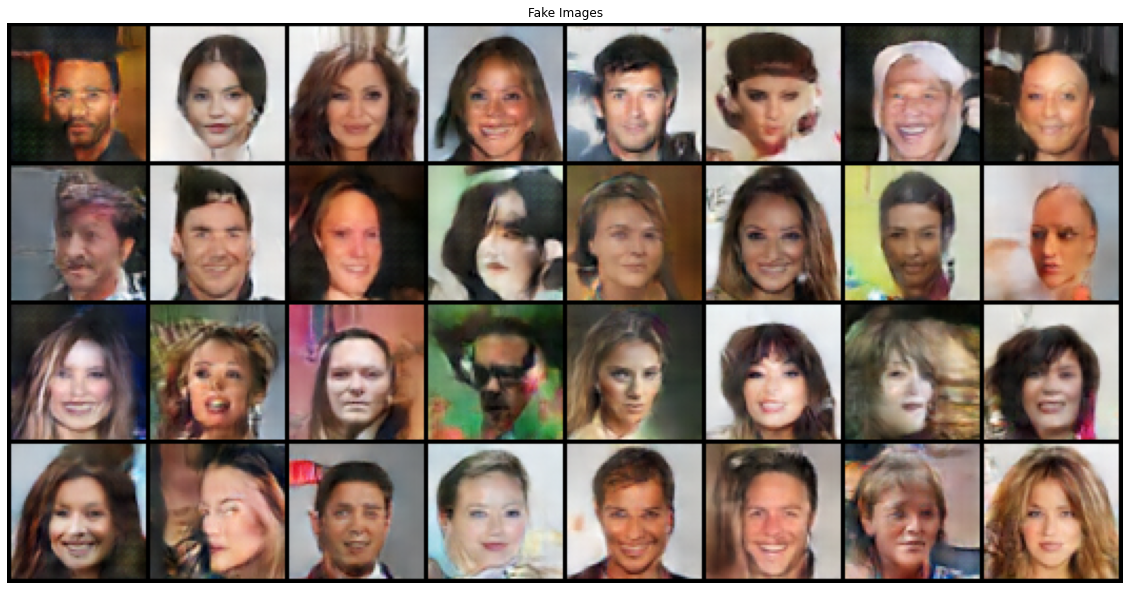

In [46]:
grid = torchvision.utils.make_grid(generated_images, scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## ULA for https://github.com/Natsu6767/DCGAN-PyTorch

In [5]:
z_dim = params['nz']
loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob,
                     z_transform = unsqueeze_transform)

In [7]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 100
n = 50000
n_steps = 500
grad_step = 0.001
eps_scale = 0.01
method_name = 'ula_dcgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 10
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  0%|          | 0/500 [00:00<?, ?it/s]/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  0%|          | 1/500 [00:23<3:11:48, 23.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_0.npy was saved, file shape = (51, 100, 100)


  0%|          | 2/500 [00:46<3:11:43, 23.10s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_100.npy was saved, file shape = (51, 100, 100)


  1%|          | 3/500 [01:09<3:12:47, 23.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_200.npy was saved, file shape = (51, 100, 100)


  1%|          | 4/500 [01:34<3:14:22, 23.51s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_300.npy was saved, file shape = (51, 100, 100)


  1%|          | 5/500 [01:58<3:16:15, 23.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_400.npy was saved, file shape = (51, 100, 100)


  1%|          | 6/500 [02:23<3:19:08, 24.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_500.npy was saved, file shape = (51, 100, 100)


  1%|▏         | 7/500 [02:48<3:21:40, 24.55s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_600.npy was saved, file shape = (51, 100, 100)


  2%|▏         | 8/500 [03:14<3:23:41, 24.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_700.npy was saved, file shape = (51, 100, 100)


  2%|▏         | 9/500 [03:40<3:25:17, 25.09s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_800.npy was saved, file shape = (51, 100, 100)


  2%|▏         | 10/500 [04:05<3:26:00, 25.23s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_900.npy was saved, file shape = (51, 100, 100)


  2%|▏         | 11/500 [04:31<3:26:23, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1000.npy was saved, file shape = (51, 100, 100)


  2%|▏         | 12/500 [04:56<3:26:30, 25.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1100.npy was saved, file shape = (51, 100, 100)


  3%|▎         | 13/500 [05:22<3:26:15, 25.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1200.npy was saved, file shape = (51, 100, 100)


  3%|▎         | 14/500 [05:47<3:26:07, 25.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1300.npy was saved, file shape = (51, 100, 100)


  3%|▎         | 15/500 [06:13<3:25:48, 25.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1400.npy was saved, file shape = (51, 100, 100)


  3%|▎         | 16/500 [06:38<3:25:21, 25.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1500.npy was saved, file shape = (51, 100, 100)


  3%|▎         | 17/500 [07:04<3:24:55, 25.46s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1600.npy was saved, file shape = (51, 100, 100)


  4%|▎         | 18/500 [07:29<3:24:25, 25.45s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1700.npy was saved, file shape = (51, 100, 100)


  4%|▍         | 19/500 [07:54<3:23:51, 25.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1800.npy was saved, file shape = (51, 100, 100)


  4%|▍         | 20/500 [08:20<3:23:28, 25.43s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_1900.npy was saved, file shape = (51, 100, 100)


  4%|▍         | 21/500 [08:45<3:22:53, 25.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2000.npy was saved, file shape = (51, 100, 100)


  4%|▍         | 22/500 [09:11<3:22:25, 25.41s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2100.npy was saved, file shape = (51, 100, 100)


  5%|▍         | 23/500 [09:36<3:21:50, 25.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2200.npy was saved, file shape = (51, 100, 100)


  5%|▍         | 24/500 [10:01<3:21:15, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2300.npy was saved, file shape = (51, 100, 100)


  5%|▌         | 25/500 [10:27<3:20:45, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2400.npy was saved, file shape = (51, 100, 100)


  5%|▌         | 26/500 [10:52<3:20:16, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2500.npy was saved, file shape = (51, 100, 100)


  5%|▌         | 27/500 [11:17<3:19:42, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2600.npy was saved, file shape = (51, 100, 100)


  6%|▌         | 28/500 [11:43<3:19:11, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2700.npy was saved, file shape = (51, 100, 100)


  6%|▌         | 29/500 [12:08<3:18:44, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2800.npy was saved, file shape = (51, 100, 100)


  6%|▌         | 30/500 [12:33<3:18:12, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_2900.npy was saved, file shape = (51, 100, 100)


  6%|▌         | 31/500 [12:58<3:17:46, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3000.npy was saved, file shape = (51, 100, 100)


  6%|▋         | 32/500 [13:24<3:17:18, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3100.npy was saved, file shape = (51, 100, 100)


  7%|▋         | 33/500 [13:49<3:16:54, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3200.npy was saved, file shape = (51, 100, 100)


  7%|▋         | 34/500 [14:14<3:16:29, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3300.npy was saved, file shape = (51, 100, 100)


  7%|▋         | 35/500 [14:40<3:16:03, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3400.npy was saved, file shape = (51, 100, 100)


  7%|▋         | 36/500 [15:05<3:15:31, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3500.npy was saved, file shape = (51, 100, 100)


  7%|▋         | 37/500 [15:30<3:15:01, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3600.npy was saved, file shape = (51, 100, 100)


  8%|▊         | 38/500 [15:55<3:14:38, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3700.npy was saved, file shape = (51, 100, 100)


  8%|▊         | 39/500 [16:21<3:14:13, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3800.npy was saved, file shape = (51, 100, 100)


  8%|▊         | 40/500 [16:46<3:13:45, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_3900.npy was saved, file shape = (51, 100, 100)


  8%|▊         | 41/500 [17:11<3:13:17, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4000.npy was saved, file shape = (51, 100, 100)


  8%|▊         | 42/500 [17:36<3:12:51, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4100.npy was saved, file shape = (51, 100, 100)


  9%|▊         | 43/500 [18:02<3:12:23, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4200.npy was saved, file shape = (51, 100, 100)


  9%|▉         | 44/500 [18:27<3:11:57, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4300.npy was saved, file shape = (51, 100, 100)


  9%|▉         | 45/500 [18:52<3:11:32, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4400.npy was saved, file shape = (51, 100, 100)


  9%|▉         | 46/500 [19:18<3:11:08, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4500.npy was saved, file shape = (51, 100, 100)


  9%|▉         | 47/500 [19:43<3:10:39, 25.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4600.npy was saved, file shape = (51, 100, 100)


 10%|▉         | 48/500 [20:08<3:10:09, 25.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4700.npy was saved, file shape = (51, 100, 100)


 10%|▉         | 49/500 [20:33<3:09:47, 25.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4800.npy was saved, file shape = (51, 100, 100)


 10%|█         | 50/500 [20:59<3:09:25, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_4900.npy was saved, file shape = (51, 100, 100)


 10%|█         | 51/500 [21:24<3:08:59, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5000.npy was saved, file shape = (51, 100, 100)


 10%|█         | 52/500 [21:49<3:08:36, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5100.npy was saved, file shape = (51, 100, 100)


 11%|█         | 53/500 [22:14<3:08:08, 25.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5200.npy was saved, file shape = (51, 100, 100)


 11%|█         | 54/500 [22:40<3:07:42, 25.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5300.npy was saved, file shape = (51, 100, 100)


 11%|█         | 55/500 [23:05<3:07:20, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5400.npy was saved, file shape = (51, 100, 100)


 11%|█         | 56/500 [23:30<3:06:55, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5500.npy was saved, file shape = (51, 100, 100)


 11%|█▏        | 57/500 [23:55<3:06:32, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5600.npy was saved, file shape = (51, 100, 100)


 12%|█▏        | 58/500 [24:21<3:06:05, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5700.npy was saved, file shape = (51, 100, 100)


 12%|█▏        | 59/500 [24:46<3:05:40, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5800.npy was saved, file shape = (51, 100, 100)


 12%|█▏        | 60/500 [25:11<3:05:13, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_5900.npy was saved, file shape = (51, 100, 100)


 12%|█▏        | 61/500 [25:36<3:04:50, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6000.npy was saved, file shape = (51, 100, 100)


 12%|█▏        | 62/500 [26:02<3:04:28, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6100.npy was saved, file shape = (51, 100, 100)


 13%|█▎        | 63/500 [26:27<3:03:56, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6200.npy was saved, file shape = (51, 100, 100)


 13%|█▎        | 64/500 [26:52<3:03:37, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6300.npy was saved, file shape = (51, 100, 100)


 13%|█▎        | 65/500 [27:17<3:03:08, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6400.npy was saved, file shape = (51, 100, 100)


 13%|█▎        | 66/500 [27:43<3:02:45, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6500.npy was saved, file shape = (51, 100, 100)


 13%|█▎        | 67/500 [28:08<3:02:15, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6600.npy was saved, file shape = (51, 100, 100)


 14%|█▎        | 68/500 [28:33<3:01:49, 25.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6700.npy was saved, file shape = (51, 100, 100)


 14%|█▍        | 69/500 [28:58<3:01:24, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6800.npy was saved, file shape = (51, 100, 100)


 14%|█▍        | 70/500 [29:24<3:01:05, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_6900.npy was saved, file shape = (51, 100, 100)


 14%|█▍        | 71/500 [29:49<3:00:41, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7000.npy was saved, file shape = (51, 100, 100)


 14%|█▍        | 72/500 [30:14<3:00:09, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7100.npy was saved, file shape = (51, 100, 100)


 15%|█▍        | 73/500 [30:40<2:59:47, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7200.npy was saved, file shape = (51, 100, 100)


 15%|█▍        | 74/500 [31:05<2:59:22, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7300.npy was saved, file shape = (51, 100, 100)


 15%|█▌        | 75/500 [31:30<2:58:54, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7400.npy was saved, file shape = (51, 100, 100)


 15%|█▌        | 76/500 [31:55<2:58:31, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7500.npy was saved, file shape = (51, 100, 100)


 15%|█▌        | 77/500 [32:21<2:58:03, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7600.npy was saved, file shape = (51, 100, 100)


 16%|█▌        | 78/500 [32:46<2:57:37, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7700.npy was saved, file shape = (51, 100, 100)


 16%|█▌        | 79/500 [33:11<2:57:13, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7800.npy was saved, file shape = (51, 100, 100)


 16%|█▌        | 80/500 [33:36<2:56:48, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_7900.npy was saved, file shape = (51, 100, 100)


 16%|█▌        | 81/500 [34:02<2:56:20, 25.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8000.npy was saved, file shape = (51, 100, 100)


 16%|█▋        | 82/500 [34:27<2:55:52, 25.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8100.npy was saved, file shape = (51, 100, 100)


 17%|█▋        | 83/500 [34:52<2:55:33, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8200.npy was saved, file shape = (51, 100, 100)


 17%|█▋        | 84/500 [35:17<2:55:07, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8300.npy was saved, file shape = (51, 100, 100)


 17%|█▋        | 85/500 [35:43<2:54:44, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8400.npy was saved, file shape = (51, 100, 100)


 17%|█▋        | 86/500 [36:08<2:54:18, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8500.npy was saved, file shape = (51, 100, 100)


 17%|█▋        | 87/500 [36:33<2:53:55, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8600.npy was saved, file shape = (51, 100, 100)


 18%|█▊        | 88/500 [36:58<2:53:28, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8700.npy was saved, file shape = (51, 100, 100)


 18%|█▊        | 89/500 [37:24<2:53:01, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8800.npy was saved, file shape = (51, 100, 100)


 18%|█▊        | 90/500 [37:49<2:52:39, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_8900.npy was saved, file shape = (51, 100, 100)


 18%|█▊        | 91/500 [38:14<2:52:16, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9000.npy was saved, file shape = (51, 100, 100)


 18%|█▊        | 92/500 [38:39<2:51:46, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9100.npy was saved, file shape = (51, 100, 100)


 19%|█▊        | 93/500 [39:05<2:51:22, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9200.npy was saved, file shape = (51, 100, 100)


 19%|█▉        | 94/500 [39:30<2:51:00, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9300.npy was saved, file shape = (51, 100, 100)


 19%|█▉        | 95/500 [39:55<2:50:32, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9400.npy was saved, file shape = (51, 100, 100)


 19%|█▉        | 96/500 [40:21<2:50:07, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9500.npy was saved, file shape = (51, 100, 100)


 19%|█▉        | 97/500 [40:46<2:49:47, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9600.npy was saved, file shape = (51, 100, 100)


 20%|█▉        | 98/500 [41:11<2:49:17, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9700.npy was saved, file shape = (51, 100, 100)


 20%|█▉        | 99/500 [41:36<2:48:48, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9800.npy was saved, file shape = (51, 100, 100)


 20%|██        | 100/500 [42:02<2:48:24, 25.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_9900.npy was saved, file shape = (51, 100, 100)


 20%|██        | 101/500 [42:27<2:48:00, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10000.npy was saved, file shape = (51, 100, 100)


 20%|██        | 102/500 [42:52<2:47:37, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10100.npy was saved, file shape = (51, 100, 100)


 21%|██        | 103/500 [43:17<2:47:11, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10200.npy was saved, file shape = (51, 100, 100)


 21%|██        | 104/500 [43:43<2:46:46, 25.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10300.npy was saved, file shape = (51, 100, 100)


 21%|██        | 105/500 [44:08<2:46:24, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10400.npy was saved, file shape = (51, 100, 100)


 21%|██        | 106/500 [44:33<2:46:00, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10500.npy was saved, file shape = (51, 100, 100)


 21%|██▏       | 107/500 [44:59<2:45:33, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10600.npy was saved, file shape = (51, 100, 100)


 22%|██▏       | 108/500 [45:24<2:45:10, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10700.npy was saved, file shape = (51, 100, 100)


 22%|██▏       | 109/500 [45:49<2:44:43, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10800.npy was saved, file shape = (51, 100, 100)


 22%|██▏       | 110/500 [46:14<2:44:21, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_10900.npy was saved, file shape = (51, 100, 100)


 22%|██▏       | 111/500 [46:40<2:43:57, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11000.npy was saved, file shape = (51, 100, 100)


 22%|██▏       | 112/500 [47:05<2:43:30, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11100.npy was saved, file shape = (51, 100, 100)


 23%|██▎       | 113/500 [47:30<2:43:03, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11200.npy was saved, file shape = (51, 100, 100)


 23%|██▎       | 114/500 [47:56<2:42:42, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11300.npy was saved, file shape = (51, 100, 100)


 23%|██▎       | 115/500 [48:21<2:42:17, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11400.npy was saved, file shape = (51, 100, 100)


 23%|██▎       | 116/500 [48:46<2:41:48, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11500.npy was saved, file shape = (51, 100, 100)


 23%|██▎       | 117/500 [49:11<2:41:22, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11600.npy was saved, file shape = (51, 100, 100)


 24%|██▎       | 118/500 [49:37<2:40:56, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11700.npy was saved, file shape = (51, 100, 100)


 24%|██▍       | 119/500 [50:02<2:40:35, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11800.npy was saved, file shape = (51, 100, 100)


 24%|██▍       | 120/500 [50:27<2:40:08, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_11900.npy was saved, file shape = (51, 100, 100)


 24%|██▍       | 121/500 [50:53<2:39:43, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12000.npy was saved, file shape = (51, 100, 100)


 24%|██▍       | 122/500 [51:18<2:39:17, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12100.npy was saved, file shape = (51, 100, 100)


 25%|██▍       | 123/500 [51:43<2:38:52, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12200.npy was saved, file shape = (51, 100, 100)


 25%|██▍       | 124/500 [52:08<2:38:29, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12300.npy was saved, file shape = (51, 100, 100)


 25%|██▌       | 125/500 [52:34<2:38:00, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12400.npy was saved, file shape = (51, 100, 100)


 25%|██▌       | 126/500 [52:59<2:37:37, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12500.npy was saved, file shape = (51, 100, 100)


 25%|██▌       | 127/500 [53:24<2:37:11, 25.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12600.npy was saved, file shape = (51, 100, 100)


 26%|██▌       | 128/500 [53:50<2:36:51, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12700.npy was saved, file shape = (51, 100, 100)


 26%|██▌       | 129/500 [54:15<2:36:24, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12800.npy was saved, file shape = (51, 100, 100)


 26%|██▌       | 130/500 [54:40<2:35:59, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_12900.npy was saved, file shape = (51, 100, 100)


 26%|██▌       | 131/500 [55:05<2:35:31, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13000.npy was saved, file shape = (51, 100, 100)


 26%|██▋       | 132/500 [55:31<2:35:06, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13100.npy was saved, file shape = (51, 100, 100)


 27%|██▋       | 133/500 [55:56<2:34:44, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13200.npy was saved, file shape = (51, 100, 100)


 27%|██▋       | 134/500 [56:21<2:34:17, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13300.npy was saved, file shape = (51, 100, 100)


 27%|██▋       | 135/500 [56:47<2:33:52, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13400.npy was saved, file shape = (51, 100, 100)


 27%|██▋       | 136/500 [57:12<2:33:27, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13500.npy was saved, file shape = (51, 100, 100)


 27%|██▋       | 137/500 [57:37<2:33:03, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13600.npy was saved, file shape = (51, 100, 100)


 28%|██▊       | 138/500 [58:03<2:32:35, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13700.npy was saved, file shape = (51, 100, 100)


 28%|██▊       | 139/500 [58:28<2:32:09, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13800.npy was saved, file shape = (51, 100, 100)


 28%|██▊       | 140/500 [58:53<2:31:47, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_13900.npy was saved, file shape = (51, 100, 100)


 28%|██▊       | 141/500 [59:18<2:31:18, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14000.npy was saved, file shape = (51, 100, 100)


 28%|██▊       | 142/500 [59:44<2:30:53, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14100.npy was saved, file shape = (51, 100, 100)


 29%|██▊       | 143/500 [1:00:09<2:30:28, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14200.npy was saved, file shape = (51, 100, 100)


 29%|██▉       | 144/500 [1:00:34<2:30:06, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14300.npy was saved, file shape = (51, 100, 100)


 29%|██▉       | 145/500 [1:01:00<2:29:40, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14400.npy was saved, file shape = (51, 100, 100)


 29%|██▉       | 146/500 [1:01:25<2:29:15, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14500.npy was saved, file shape = (51, 100, 100)


 29%|██▉       | 147/500 [1:01:50<2:28:50, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14600.npy was saved, file shape = (51, 100, 100)


 30%|██▉       | 148/500 [1:02:15<2:28:23, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14700.npy was saved, file shape = (51, 100, 100)


 30%|██▉       | 149/500 [1:02:41<2:27:59, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14800.npy was saved, file shape = (51, 100, 100)


 30%|███       | 150/500 [1:03:06<2:27:34, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_14900.npy was saved, file shape = (51, 100, 100)


 30%|███       | 151/500 [1:03:31<2:27:10, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15000.npy was saved, file shape = (51, 100, 100)


 30%|███       | 152/500 [1:03:57<2:26:49, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15100.npy was saved, file shape = (51, 100, 100)


 31%|███       | 153/500 [1:04:22<2:26:22, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15200.npy was saved, file shape = (51, 100, 100)


 31%|███       | 154/500 [1:04:47<2:25:57, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15300.npy was saved, file shape = (51, 100, 100)


 31%|███       | 155/500 [1:05:13<2:25:32, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15400.npy was saved, file shape = (51, 100, 100)


 31%|███       | 156/500 [1:05:38<2:25:03, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15500.npy was saved, file shape = (51, 100, 100)


 31%|███▏      | 157/500 [1:06:03<2:24:44, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15600.npy was saved, file shape = (51, 100, 100)


 32%|███▏      | 158/500 [1:06:29<2:24:18, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15700.npy was saved, file shape = (51, 100, 100)


 32%|███▏      | 159/500 [1:06:54<2:23:53, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15800.npy was saved, file shape = (51, 100, 100)


 32%|███▏      | 160/500 [1:07:19<2:23:27, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_15900.npy was saved, file shape = (51, 100, 100)


 32%|███▏      | 161/500 [1:07:45<2:22:59, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16000.npy was saved, file shape = (51, 100, 100)


 32%|███▏      | 162/500 [1:08:10<2:22:34, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16100.npy was saved, file shape = (51, 100, 100)


 33%|███▎      | 163/500 [1:08:35<2:22:11, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16200.npy was saved, file shape = (51, 100, 100)


 33%|███▎      | 164/500 [1:09:01<2:21:46, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16300.npy was saved, file shape = (51, 100, 100)


 33%|███▎      | 165/500 [1:09:26<2:21:21, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16400.npy was saved, file shape = (51, 100, 100)


 33%|███▎      | 166/500 [1:09:51<2:20:55, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16500.npy was saved, file shape = (51, 100, 100)


 33%|███▎      | 167/500 [1:10:16<2:20:30, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16600.npy was saved, file shape = (51, 100, 100)


 34%|███▎      | 168/500 [1:10:42<2:20:04, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16700.npy was saved, file shape = (51, 100, 100)


 34%|███▍      | 169/500 [1:11:07<2:19:38, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16800.npy was saved, file shape = (51, 100, 100)


 34%|███▍      | 170/500 [1:11:32<2:19:09, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_16900.npy was saved, file shape = (51, 100, 100)


 34%|███▍      | 171/500 [1:11:58<2:18:49, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17000.npy was saved, file shape = (51, 100, 100)


 34%|███▍      | 172/500 [1:12:23<2:18:23, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17100.npy was saved, file shape = (51, 100, 100)


 35%|███▍      | 173/500 [1:12:48<2:17:59, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17200.npy was saved, file shape = (51, 100, 100)


 35%|███▍      | 174/500 [1:13:14<2:17:33, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17300.npy was saved, file shape = (51, 100, 100)


 35%|███▌      | 175/500 [1:13:39<2:17:07, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17400.npy was saved, file shape = (51, 100, 100)


 35%|███▌      | 176/500 [1:14:04<2:16:40, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17500.npy was saved, file shape = (51, 100, 100)


 35%|███▌      | 177/500 [1:14:30<2:16:17, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17600.npy was saved, file shape = (51, 100, 100)


 36%|███▌      | 178/500 [1:14:55<2:15:48, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17700.npy was saved, file shape = (51, 100, 100)


 36%|███▌      | 179/500 [1:15:20<2:15:26, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17800.npy was saved, file shape = (51, 100, 100)


 36%|███▌      | 180/500 [1:15:46<2:15:03, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_17900.npy was saved, file shape = (51, 100, 100)


 36%|███▌      | 181/500 [1:16:11<2:14:38, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18000.npy was saved, file shape = (51, 100, 100)


 36%|███▋      | 182/500 [1:16:36<2:14:14, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18100.npy was saved, file shape = (51, 100, 100)


 37%|███▋      | 183/500 [1:17:02<2:13:46, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18200.npy was saved, file shape = (51, 100, 100)


 37%|███▋      | 184/500 [1:17:27<2:13:20, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18300.npy was saved, file shape = (51, 100, 100)


 37%|███▋      | 185/500 [1:17:52<2:12:56, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18400.npy was saved, file shape = (51, 100, 100)


 37%|███▋      | 186/500 [1:18:17<2:12:30, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18500.npy was saved, file shape = (51, 100, 100)


 37%|███▋      | 187/500 [1:18:43<2:12:07, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18600.npy was saved, file shape = (51, 100, 100)


 38%|███▊      | 188/500 [1:19:08<2:11:43, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18700.npy was saved, file shape = (51, 100, 100)


 38%|███▊      | 189/500 [1:19:33<2:11:15, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18800.npy was saved, file shape = (51, 100, 100)


 38%|███▊      | 190/500 [1:19:59<2:10:52, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_18900.npy was saved, file shape = (51, 100, 100)


 38%|███▊      | 191/500 [1:20:24<2:10:27, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19000.npy was saved, file shape = (51, 100, 100)


 38%|███▊      | 192/500 [1:20:49<2:09:58, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19100.npy was saved, file shape = (51, 100, 100)


 39%|███▊      | 193/500 [1:21:15<2:09:31, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19200.npy was saved, file shape = (51, 100, 100)


 39%|███▉      | 194/500 [1:21:40<2:09:09, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19300.npy was saved, file shape = (51, 100, 100)


 39%|███▉      | 195/500 [1:22:05<2:08:39, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19400.npy was saved, file shape = (51, 100, 100)


 39%|███▉      | 196/500 [1:22:31<2:08:14, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19500.npy was saved, file shape = (51, 100, 100)


 39%|███▉      | 197/500 [1:22:56<2:07:48, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19600.npy was saved, file shape = (51, 100, 100)


 40%|███▉      | 198/500 [1:23:21<2:07:27, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19700.npy was saved, file shape = (51, 100, 100)


 40%|███▉      | 199/500 [1:23:47<2:06:59, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19800.npy was saved, file shape = (51, 100, 100)


 40%|████      | 200/500 [1:24:12<2:06:34, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_19900.npy was saved, file shape = (51, 100, 100)


 40%|████      | 201/500 [1:24:37<2:06:08, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20000.npy was saved, file shape = (51, 100, 100)


 40%|████      | 202/500 [1:25:03<2:05:43, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20100.npy was saved, file shape = (51, 100, 100)


 41%|████      | 203/500 [1:25:28<2:05:17, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20200.npy was saved, file shape = (51, 100, 100)


 41%|████      | 204/500 [1:25:53<2:04:51, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20300.npy was saved, file shape = (51, 100, 100)


 41%|████      | 205/500 [1:26:19<2:04:28, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20400.npy was saved, file shape = (51, 100, 100)


 41%|████      | 206/500 [1:26:44<2:04:00, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20500.npy was saved, file shape = (51, 100, 100)


 41%|████▏     | 207/500 [1:27:09<2:03:34, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20600.npy was saved, file shape = (51, 100, 100)


 42%|████▏     | 208/500 [1:27:34<2:03:10, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20700.npy was saved, file shape = (51, 100, 100)


 42%|████▏     | 209/500 [1:28:00<2:02:43, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20800.npy was saved, file shape = (51, 100, 100)


 42%|████▏     | 210/500 [1:28:25<2:02:19, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_20900.npy was saved, file shape = (51, 100, 100)


 42%|████▏     | 211/500 [1:28:50<2:01:53, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21000.npy was saved, file shape = (51, 100, 100)


 42%|████▏     | 212/500 [1:29:16<2:01:28, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21100.npy was saved, file shape = (51, 100, 100)


 43%|████▎     | 213/500 [1:29:41<2:01:02, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21200.npy was saved, file shape = (51, 100, 100)


 43%|████▎     | 214/500 [1:30:06<2:00:38, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21300.npy was saved, file shape = (51, 100, 100)


 43%|████▎     | 215/500 [1:30:32<2:00:12, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21400.npy was saved, file shape = (51, 100, 100)


 43%|████▎     | 216/500 [1:30:57<1:59:45, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21500.npy was saved, file shape = (51, 100, 100)


 43%|████▎     | 217/500 [1:31:22<1:59:20, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21600.npy was saved, file shape = (51, 100, 100)


 44%|████▎     | 218/500 [1:31:47<1:58:55, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21700.npy was saved, file shape = (51, 100, 100)


 44%|████▍     | 219/500 [1:32:13<1:58:29, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21800.npy was saved, file shape = (51, 100, 100)


 44%|████▍     | 220/500 [1:32:38<1:58:03, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_21900.npy was saved, file shape = (51, 100, 100)


 44%|████▍     | 221/500 [1:33:03<1:57:40, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22000.npy was saved, file shape = (51, 100, 100)


 44%|████▍     | 222/500 [1:33:29<1:57:16, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22100.npy was saved, file shape = (51, 100, 100)


 45%|████▍     | 223/500 [1:33:54<1:56:47, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22200.npy was saved, file shape = (51, 100, 100)


 45%|████▍     | 224/500 [1:34:19<1:56:25, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22300.npy was saved, file shape = (51, 100, 100)


 45%|████▌     | 225/500 [1:34:45<1:55:58, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22400.npy was saved, file shape = (51, 100, 100)


 45%|████▌     | 226/500 [1:35:10<1:55:32, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22500.npy was saved, file shape = (51, 100, 100)


 45%|████▌     | 227/500 [1:35:35<1:55:08, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22600.npy was saved, file shape = (51, 100, 100)


 46%|████▌     | 228/500 [1:36:01<1:54:42, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22700.npy was saved, file shape = (51, 100, 100)


 46%|████▌     | 229/500 [1:36:26<1:54:18, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22800.npy was saved, file shape = (51, 100, 100)


 46%|████▌     | 230/500 [1:36:51<1:53:52, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_22900.npy was saved, file shape = (51, 100, 100)


 46%|████▌     | 231/500 [1:37:16<1:53:25, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23000.npy was saved, file shape = (51, 100, 100)


 46%|████▋     | 232/500 [1:37:42<1:53:00, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23100.npy was saved, file shape = (51, 100, 100)


 47%|████▋     | 233/500 [1:38:07<1:52:36, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23200.npy was saved, file shape = (51, 100, 100)


 47%|████▋     | 234/500 [1:38:32<1:52:11, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23300.npy was saved, file shape = (51, 100, 100)


 47%|████▋     | 235/500 [1:38:58<1:51:44, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23400.npy was saved, file shape = (51, 100, 100)


 47%|████▋     | 236/500 [1:39:23<1:51:21, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23500.npy was saved, file shape = (51, 100, 100)


 47%|████▋     | 237/500 [1:39:48<1:50:54, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23600.npy was saved, file shape = (51, 100, 100)


 48%|████▊     | 238/500 [1:40:14<1:50:28, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23700.npy was saved, file shape = (51, 100, 100)


 48%|████▊     | 239/500 [1:40:39<1:50:04, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23800.npy was saved, file shape = (51, 100, 100)


 48%|████▊     | 240/500 [1:41:04<1:49:39, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_23900.npy was saved, file shape = (51, 100, 100)


 48%|████▊     | 241/500 [1:41:29<1:49:14, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24000.npy was saved, file shape = (51, 100, 100)


 48%|████▊     | 242/500 [1:41:55<1:48:48, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24100.npy was saved, file shape = (51, 100, 100)


 49%|████▊     | 243/500 [1:42:20<1:48:23, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24200.npy was saved, file shape = (51, 100, 100)


 49%|████▉     | 244/500 [1:42:45<1:47:58, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24300.npy was saved, file shape = (51, 100, 100)


 49%|████▉     | 245/500 [1:43:11<1:47:31, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24400.npy was saved, file shape = (51, 100, 100)


 49%|████▉     | 246/500 [1:43:36<1:47:05, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24500.npy was saved, file shape = (51, 100, 100)


 49%|████▉     | 247/500 [1:44:01<1:46:42, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24600.npy was saved, file shape = (51, 100, 100)


 50%|████▉     | 248/500 [1:44:27<1:46:15, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24700.npy was saved, file shape = (51, 100, 100)


 50%|████▉     | 249/500 [1:44:52<1:45:52, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24800.npy was saved, file shape = (51, 100, 100)


 50%|█████     | 250/500 [1:45:17<1:45:23, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_24900.npy was saved, file shape = (51, 100, 100)


 50%|█████     | 251/500 [1:45:42<1:44:57, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25000.npy was saved, file shape = (51, 100, 100)


 50%|█████     | 252/500 [1:46:08<1:44:32, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25100.npy was saved, file shape = (51, 100, 100)


 51%|█████     | 253/500 [1:46:33<1:44:08, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25200.npy was saved, file shape = (51, 100, 100)


 51%|█████     | 254/500 [1:46:58<1:43:42, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25300.npy was saved, file shape = (51, 100, 100)


 51%|█████     | 255/500 [1:47:24<1:43:16, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25400.npy was saved, file shape = (51, 100, 100)


 51%|█████     | 256/500 [1:47:49<1:42:53, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25500.npy was saved, file shape = (51, 100, 100)


 51%|█████▏    | 257/500 [1:48:14<1:42:28, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25600.npy was saved, file shape = (51, 100, 100)


 52%|█████▏    | 258/500 [1:48:40<1:42:00, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25700.npy was saved, file shape = (51, 100, 100)


 52%|█████▏    | 259/500 [1:49:05<1:41:38, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25800.npy was saved, file shape = (51, 100, 100)


 52%|█████▏    | 260/500 [1:49:30<1:41:12, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_25900.npy was saved, file shape = (51, 100, 100)


 52%|█████▏    | 261/500 [1:49:55<1:40:44, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26000.npy was saved, file shape = (51, 100, 100)


 52%|█████▏    | 262/500 [1:50:21<1:40:19, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26100.npy was saved, file shape = (51, 100, 100)


 53%|█████▎    | 263/500 [1:50:46<1:39:56, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26200.npy was saved, file shape = (51, 100, 100)


 53%|█████▎    | 264/500 [1:51:11<1:39:29, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26300.npy was saved, file shape = (51, 100, 100)


 53%|█████▎    | 265/500 [1:51:37<1:39:02, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26400.npy was saved, file shape = (51, 100, 100)


 53%|█████▎    | 266/500 [1:52:02<1:38:40, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26500.npy was saved, file shape = (51, 100, 100)


 53%|█████▎    | 267/500 [1:52:27<1:38:12, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26600.npy was saved, file shape = (51, 100, 100)


 54%|█████▎    | 268/500 [1:52:53<1:37:49, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26700.npy was saved, file shape = (51, 100, 100)


 54%|█████▍    | 269/500 [1:53:18<1:37:22, 25.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26800.npy was saved, file shape = (51, 100, 100)


 54%|█████▍    | 270/500 [1:53:43<1:37:00, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_26900.npy was saved, file shape = (51, 100, 100)


 54%|█████▍    | 271/500 [1:54:08<1:36:34, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27000.npy was saved, file shape = (51, 100, 100)


 54%|█████▍    | 272/500 [1:54:34<1:36:09, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27100.npy was saved, file shape = (51, 100, 100)


 55%|█████▍    | 273/500 [1:54:59<1:35:43, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27200.npy was saved, file shape = (51, 100, 100)


 55%|█████▍    | 274/500 [1:55:24<1:35:17, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27300.npy was saved, file shape = (51, 100, 100)


 55%|█████▌    | 275/500 [1:55:50<1:34:53, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27400.npy was saved, file shape = (51, 100, 100)


 55%|█████▌    | 276/500 [1:56:15<1:34:28, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27500.npy was saved, file shape = (51, 100, 100)


 55%|█████▌    | 277/500 [1:56:40<1:34:02, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27600.npy was saved, file shape = (51, 100, 100)


 56%|█████▌    | 278/500 [1:57:06<1:33:37, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27700.npy was saved, file shape = (51, 100, 100)


 56%|█████▌    | 279/500 [1:57:31<1:33:12, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27800.npy was saved, file shape = (51, 100, 100)


 56%|█████▌    | 280/500 [1:57:56<1:32:49, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_27900.npy was saved, file shape = (51, 100, 100)


 56%|█████▌    | 281/500 [1:58:21<1:32:22, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28000.npy was saved, file shape = (51, 100, 100)


 56%|█████▋    | 282/500 [1:58:47<1:31:56, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28100.npy was saved, file shape = (51, 100, 100)


 57%|█████▋    | 283/500 [1:59:12<1:31:31, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28200.npy was saved, file shape = (51, 100, 100)


 57%|█████▋    | 284/500 [1:59:37<1:31:04, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28300.npy was saved, file shape = (51, 100, 100)


 57%|█████▋    | 285/500 [2:00:03<1:30:41, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28400.npy was saved, file shape = (51, 100, 100)


 57%|█████▋    | 286/500 [2:00:28<1:30:13, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28500.npy was saved, file shape = (51, 100, 100)


 57%|█████▋    | 287/500 [2:00:53<1:29:50, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28600.npy was saved, file shape = (51, 100, 100)


 58%|█████▊    | 288/500 [2:01:19<1:29:24, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28700.npy was saved, file shape = (51, 100, 100)


 58%|█████▊    | 289/500 [2:01:44<1:29:00, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28800.npy was saved, file shape = (51, 100, 100)


 58%|█████▊    | 290/500 [2:02:09<1:28:34, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_28900.npy was saved, file shape = (51, 100, 100)


 58%|█████▊    | 291/500 [2:02:35<1:28:07, 25.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29000.npy was saved, file shape = (51, 100, 100)


 58%|█████▊    | 292/500 [2:03:00<1:27:44, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29100.npy was saved, file shape = (51, 100, 100)


 59%|█████▊    | 293/500 [2:03:25<1:27:18, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29200.npy was saved, file shape = (51, 100, 100)


 59%|█████▉    | 294/500 [2:03:50<1:26:52, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29300.npy was saved, file shape = (51, 100, 100)


 59%|█████▉    | 295/500 [2:04:16<1:26:29, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29400.npy was saved, file shape = (51, 100, 100)


 59%|█████▉    | 296/500 [2:04:41<1:26:04, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29500.npy was saved, file shape = (51, 100, 100)


 59%|█████▉    | 297/500 [2:05:06<1:25:39, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29600.npy was saved, file shape = (51, 100, 100)


 60%|█████▉    | 298/500 [2:05:32<1:25:14, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29700.npy was saved, file shape = (51, 100, 100)


 60%|█████▉    | 299/500 [2:05:57<1:24:51, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29800.npy was saved, file shape = (51, 100, 100)


 60%|██████    | 300/500 [2:06:22<1:24:25, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_29900.npy was saved, file shape = (51, 100, 100)


 60%|██████    | 301/500 [2:06:48<1:23:57, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30000.npy was saved, file shape = (51, 100, 100)


 60%|██████    | 302/500 [2:07:13<1:23:31, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30100.npy was saved, file shape = (51, 100, 100)


 61%|██████    | 303/500 [2:07:38<1:23:06, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30200.npy was saved, file shape = (51, 100, 100)


 61%|██████    | 304/500 [2:08:04<1:22:43, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30300.npy was saved, file shape = (51, 100, 100)


 61%|██████    | 305/500 [2:08:29<1:22:18, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30400.npy was saved, file shape = (51, 100, 100)


 61%|██████    | 306/500 [2:08:54<1:21:51, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30500.npy was saved, file shape = (51, 100, 100)


 61%|██████▏   | 307/500 [2:09:20<1:21:26, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30600.npy was saved, file shape = (51, 100, 100)


 62%|██████▏   | 308/500 [2:09:45<1:21:00, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30700.npy was saved, file shape = (51, 100, 100)


 62%|██████▏   | 309/500 [2:10:10<1:20:35, 25.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30800.npy was saved, file shape = (51, 100, 100)


 62%|██████▏   | 310/500 [2:10:36<1:20:14, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_30900.npy was saved, file shape = (51, 100, 100)


 62%|██████▏   | 311/500 [2:11:01<1:19:46, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31000.npy was saved, file shape = (51, 100, 100)


 62%|██████▏   | 312/500 [2:11:26<1:19:23, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31100.npy was saved, file shape = (51, 100, 100)


 63%|██████▎   | 313/500 [2:11:52<1:18:58, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31200.npy was saved, file shape = (51, 100, 100)


 63%|██████▎   | 314/500 [2:12:17<1:18:31, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31300.npy was saved, file shape = (51, 100, 100)


 63%|██████▎   | 315/500 [2:12:42<1:18:07, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31400.npy was saved, file shape = (51, 100, 100)


 63%|██████▎   | 316/500 [2:13:08<1:17:41, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31500.npy was saved, file shape = (51, 100, 100)


 63%|██████▎   | 317/500 [2:13:33<1:17:19, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31600.npy was saved, file shape = (51, 100, 100)


 64%|██████▎   | 318/500 [2:13:58<1:16:52, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31700.npy was saved, file shape = (51, 100, 100)


 64%|██████▍   | 319/500 [2:14:24<1:16:26, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31800.npy was saved, file shape = (51, 100, 100)


 64%|██████▍   | 320/500 [2:14:49<1:16:02, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_31900.npy was saved, file shape = (51, 100, 100)


 64%|██████▍   | 321/500 [2:15:14<1:15:36, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32000.npy was saved, file shape = (51, 100, 100)


 64%|██████▍   | 322/500 [2:15:40<1:15:12, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32100.npy was saved, file shape = (51, 100, 100)


 65%|██████▍   | 323/500 [2:16:05<1:14:45, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32200.npy was saved, file shape = (51, 100, 100)


 65%|██████▍   | 324/500 [2:16:30<1:14:19, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32300.npy was saved, file shape = (51, 100, 100)


 65%|██████▌   | 325/500 [2:16:56<1:13:54, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32400.npy was saved, file shape = (51, 100, 100)


 65%|██████▌   | 326/500 [2:17:21<1:13:29, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32500.npy was saved, file shape = (51, 100, 100)


 65%|██████▌   | 327/500 [2:17:46<1:13:05, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32600.npy was saved, file shape = (51, 100, 100)


 66%|██████▌   | 328/500 [2:18:12<1:12:38, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32700.npy was saved, file shape = (51, 100, 100)


 66%|██████▌   | 329/500 [2:18:37<1:12:13, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32800.npy was saved, file shape = (51, 100, 100)


 66%|██████▌   | 330/500 [2:19:02<1:11:48, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_32900.npy was saved, file shape = (51, 100, 100)


 66%|██████▌   | 331/500 [2:19:28<1:11:24, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33000.npy was saved, file shape = (51, 100, 100)


 66%|██████▋   | 332/500 [2:19:53<1:10:58, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33100.npy was saved, file shape = (51, 100, 100)


 67%|██████▋   | 333/500 [2:20:19<1:10:33, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33200.npy was saved, file shape = (51, 100, 100)


 67%|██████▋   | 334/500 [2:20:44<1:10:07, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33300.npy was saved, file shape = (51, 100, 100)


 67%|██████▋   | 335/500 [2:21:09<1:09:42, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33400.npy was saved, file shape = (51, 100, 100)


 67%|██████▋   | 336/500 [2:21:35<1:09:16, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33500.npy was saved, file shape = (51, 100, 100)


 67%|██████▋   | 337/500 [2:22:00<1:08:51, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33600.npy was saved, file shape = (51, 100, 100)


 68%|██████▊   | 338/500 [2:22:25<1:08:27, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33700.npy was saved, file shape = (51, 100, 100)


 68%|██████▊   | 339/500 [2:22:51<1:08:01, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33800.npy was saved, file shape = (51, 100, 100)


 68%|██████▊   | 340/500 [2:23:16<1:07:35, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_33900.npy was saved, file shape = (51, 100, 100)


 68%|██████▊   | 341/500 [2:23:41<1:07:09, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34000.npy was saved, file shape = (51, 100, 100)


 68%|██████▊   | 342/500 [2:24:07<1:06:45, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34100.npy was saved, file shape = (51, 100, 100)


 69%|██████▊   | 343/500 [2:24:32<1:06:20, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34200.npy was saved, file shape = (51, 100, 100)


 69%|██████▉   | 344/500 [2:24:57<1:05:54, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34300.npy was saved, file shape = (51, 100, 100)


 69%|██████▉   | 345/500 [2:25:23<1:05:29, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34400.npy was saved, file shape = (51, 100, 100)


 69%|██████▉   | 346/500 [2:25:48<1:05:02, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34500.npy was saved, file shape = (51, 100, 100)


 69%|██████▉   | 347/500 [2:26:13<1:04:38, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34600.npy was saved, file shape = (51, 100, 100)


 70%|██████▉   | 348/500 [2:26:39<1:04:13, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34700.npy was saved, file shape = (51, 100, 100)


 70%|██████▉   | 349/500 [2:27:04<1:03:49, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34800.npy was saved, file shape = (51, 100, 100)


 70%|███████   | 350/500 [2:27:29<1:03:23, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_34900.npy was saved, file shape = (51, 100, 100)


 70%|███████   | 351/500 [2:27:55<1:02:58, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35000.npy was saved, file shape = (51, 100, 100)


 70%|███████   | 352/500 [2:28:20<1:02:32, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35100.npy was saved, file shape = (51, 100, 100)


 71%|███████   | 353/500 [2:28:46<1:02:08, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35200.npy was saved, file shape = (51, 100, 100)


 71%|███████   | 354/500 [2:29:11<1:01:42, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35300.npy was saved, file shape = (51, 100, 100)


 71%|███████   | 355/500 [2:29:36<1:01:16, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35400.npy was saved, file shape = (51, 100, 100)


 71%|███████   | 356/500 [2:30:02<1:00:52, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35500.npy was saved, file shape = (51, 100, 100)


 71%|███████▏  | 357/500 [2:30:27<1:00:25, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35600.npy was saved, file shape = (51, 100, 100)


 72%|███████▏  | 358/500 [2:30:52<1:00:01, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35700.npy was saved, file shape = (51, 100, 100)


 72%|███████▏  | 359/500 [2:31:18<59:35, 25.36s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35800.npy was saved, file shape = (51, 100, 100)


 72%|███████▏  | 360/500 [2:31:43<59:09, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_35900.npy was saved, file shape = (51, 100, 100)


 72%|███████▏  | 361/500 [2:32:08<58:43, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36000.npy was saved, file shape = (51, 100, 100)


 72%|███████▏  | 362/500 [2:32:34<58:19, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36100.npy was saved, file shape = (51, 100, 100)


 73%|███████▎  | 363/500 [2:32:59<57:53, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36200.npy was saved, file shape = (51, 100, 100)


 73%|███████▎  | 364/500 [2:33:24<57:27, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36300.npy was saved, file shape = (51, 100, 100)


 73%|███████▎  | 365/500 [2:33:50<57:02, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36400.npy was saved, file shape = (51, 100, 100)


 73%|███████▎  | 366/500 [2:34:15<56:38, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36500.npy was saved, file shape = (51, 100, 100)


 73%|███████▎  | 367/500 [2:34:41<56:11, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36600.npy was saved, file shape = (51, 100, 100)


 74%|███████▎  | 368/500 [2:35:06<55:46, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36700.npy was saved, file shape = (51, 100, 100)


 74%|███████▍  | 369/500 [2:35:31<55:21, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36800.npy was saved, file shape = (51, 100, 100)


 74%|███████▍  | 370/500 [2:35:57<54:56, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_36900.npy was saved, file shape = (51, 100, 100)


 74%|███████▍  | 371/500 [2:36:22<54:30, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37000.npy was saved, file shape = (51, 100, 100)


 74%|███████▍  | 372/500 [2:36:47<54:06, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37100.npy was saved, file shape = (51, 100, 100)


 75%|███████▍  | 373/500 [2:37:13<53:39, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37200.npy was saved, file shape = (51, 100, 100)


 75%|███████▍  | 374/500 [2:37:38<53:16, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37300.npy was saved, file shape = (51, 100, 100)


 75%|███████▌  | 375/500 [2:38:03<52:50, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37400.npy was saved, file shape = (51, 100, 100)


 75%|███████▌  | 376/500 [2:38:29<52:25, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37500.npy was saved, file shape = (51, 100, 100)


 75%|███████▌  | 377/500 [2:38:54<51:59, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37600.npy was saved, file shape = (51, 100, 100)


 76%|███████▌  | 378/500 [2:39:20<51:35, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37700.npy was saved, file shape = (51, 100, 100)


 76%|███████▌  | 379/500 [2:39:45<51:10, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37800.npy was saved, file shape = (51, 100, 100)


 76%|███████▌  | 380/500 [2:40:10<50:44, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_37900.npy was saved, file shape = (51, 100, 100)


 76%|███████▌  | 381/500 [2:40:36<50:19, 25.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38000.npy was saved, file shape = (51, 100, 100)


 76%|███████▋  | 382/500 [2:41:01<49:54, 25.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38100.npy was saved, file shape = (51, 100, 100)


 77%|███████▋  | 383/500 [2:41:26<49:28, 25.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38200.npy was saved, file shape = (51, 100, 100)


 77%|███████▋  | 384/500 [2:41:52<49:03, 25.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38300.npy was saved, file shape = (51, 100, 100)


 77%|███████▋  | 385/500 [2:42:17<48:38, 25.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38400.npy was saved, file shape = (51, 100, 100)


 77%|███████▋  | 386/500 [2:42:43<48:11, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38500.npy was saved, file shape = (51, 100, 100)


 77%|███████▋  | 387/500 [2:43:08<47:47, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38600.npy was saved, file shape = (51, 100, 100)


 78%|███████▊  | 388/500 [2:43:33<47:20, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38700.npy was saved, file shape = (51, 100, 100)


 78%|███████▊  | 389/500 [2:43:59<46:55, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38800.npy was saved, file shape = (51, 100, 100)


 78%|███████▊  | 390/500 [2:44:24<46:30, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_38900.npy was saved, file shape = (51, 100, 100)


 78%|███████▊  | 391/500 [2:44:49<46:03, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39000.npy was saved, file shape = (51, 100, 100)


 78%|███████▊  | 392/500 [2:45:15<45:39, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39100.npy was saved, file shape = (51, 100, 100)


 79%|███████▊  | 393/500 [2:45:40<45:14, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39200.npy was saved, file shape = (51, 100, 100)


 79%|███████▉  | 394/500 [2:46:05<44:48, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39300.npy was saved, file shape = (51, 100, 100)


 79%|███████▉  | 395/500 [2:46:31<44:23, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39400.npy was saved, file shape = (51, 100, 100)


 79%|███████▉  | 396/500 [2:46:56<43:58, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39500.npy was saved, file shape = (51, 100, 100)


 79%|███████▉  | 397/500 [2:47:22<43:32, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39600.npy was saved, file shape = (51, 100, 100)


 80%|███████▉  | 398/500 [2:47:47<43:06, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39700.npy was saved, file shape = (51, 100, 100)


 80%|███████▉  | 399/500 [2:48:12<42:40, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39800.npy was saved, file shape = (51, 100, 100)


 80%|████████  | 400/500 [2:48:38<42:15, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_39900.npy was saved, file shape = (51, 100, 100)


 80%|████████  | 401/500 [2:49:03<41:51, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40000.npy was saved, file shape = (51, 100, 100)


 80%|████████  | 402/500 [2:49:28<41:25, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40100.npy was saved, file shape = (51, 100, 100)


 81%|████████  | 403/500 [2:49:54<41:00, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40200.npy was saved, file shape = (51, 100, 100)


 81%|████████  | 404/500 [2:50:19<40:34, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40300.npy was saved, file shape = (51, 100, 100)


 81%|████████  | 405/500 [2:50:44<40:10, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40400.npy was saved, file shape = (51, 100, 100)


 81%|████████  | 406/500 [2:51:10<39:44, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40500.npy was saved, file shape = (51, 100, 100)


 81%|████████▏ | 407/500 [2:51:35<39:18, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40600.npy was saved, file shape = (51, 100, 100)


 82%|████████▏ | 408/500 [2:52:01<38:53, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40700.npy was saved, file shape = (51, 100, 100)


 82%|████████▏ | 409/500 [2:52:26<38:28, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40800.npy was saved, file shape = (51, 100, 100)


 82%|████████▏ | 410/500 [2:52:51<38:02, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_40900.npy was saved, file shape = (51, 100, 100)


 82%|████████▏ | 411/500 [2:53:17<37:37, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41000.npy was saved, file shape = (51, 100, 100)


 82%|████████▏ | 412/500 [2:53:42<37:12, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41100.npy was saved, file shape = (51, 100, 100)


 83%|████████▎ | 413/500 [2:54:07<36:46, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41200.npy was saved, file shape = (51, 100, 100)


 83%|████████▎ | 414/500 [2:54:33<36:21, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41300.npy was saved, file shape = (51, 100, 100)


 83%|████████▎ | 415/500 [2:54:58<35:55, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41400.npy was saved, file shape = (51, 100, 100)


 83%|████████▎ | 416/500 [2:55:23<35:29, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41500.npy was saved, file shape = (51, 100, 100)


 83%|████████▎ | 417/500 [2:55:49<35:03, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41600.npy was saved, file shape = (51, 100, 100)


 84%|████████▎ | 418/500 [2:56:14<34:37, 25.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41700.npy was saved, file shape = (51, 100, 100)


 84%|████████▍ | 419/500 [2:56:39<34:13, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41800.npy was saved, file shape = (51, 100, 100)


 84%|████████▍ | 420/500 [2:57:05<33:48, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_41900.npy was saved, file shape = (51, 100, 100)


 84%|████████▍ | 421/500 [2:57:30<33:22, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42000.npy was saved, file shape = (51, 100, 100)


 84%|████████▍ | 422/500 [2:57:56<32:57, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42100.npy was saved, file shape = (51, 100, 100)


 85%|████████▍ | 423/500 [2:58:21<32:32, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42200.npy was saved, file shape = (51, 100, 100)


 85%|████████▍ | 424/500 [2:58:46<32:07, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42300.npy was saved, file shape = (51, 100, 100)


 85%|████████▌ | 425/500 [2:59:12<31:42, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42400.npy was saved, file shape = (51, 100, 100)


 85%|████████▌ | 426/500 [2:59:37<31:16, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42500.npy was saved, file shape = (51, 100, 100)


 85%|████████▌ | 427/500 [3:00:02<30:50, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42600.npy was saved, file shape = (51, 100, 100)


 86%|████████▌ | 428/500 [3:00:28<30:25, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42700.npy was saved, file shape = (51, 100, 100)


 86%|████████▌ | 429/500 [3:00:53<29:59, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42800.npy was saved, file shape = (51, 100, 100)


 86%|████████▌ | 430/500 [3:01:18<29:34, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_42900.npy was saved, file shape = (51, 100, 100)


 86%|████████▌ | 431/500 [3:01:44<29:09, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43000.npy was saved, file shape = (51, 100, 100)


 86%|████████▋ | 432/500 [3:02:09<28:43, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43100.npy was saved, file shape = (51, 100, 100)


 87%|████████▋ | 433/500 [3:02:34<28:18, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43200.npy was saved, file shape = (51, 100, 100)


 87%|████████▋ | 434/500 [3:03:00<27:52, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43300.npy was saved, file shape = (51, 100, 100)


 87%|████████▋ | 435/500 [3:03:25<27:27, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43400.npy was saved, file shape = (51, 100, 100)


 87%|████████▋ | 436/500 [3:03:50<27:02, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43500.npy was saved, file shape = (51, 100, 100)


 87%|████████▋ | 437/500 [3:04:16<26:37, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43600.npy was saved, file shape = (51, 100, 100)


 88%|████████▊ | 438/500 [3:04:41<26:11, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43700.npy was saved, file shape = (51, 100, 100)


 88%|████████▊ | 439/500 [3:05:06<25:46, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43800.npy was saved, file shape = (51, 100, 100)


 88%|████████▊ | 440/500 [3:05:32<25:21, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_43900.npy was saved, file shape = (51, 100, 100)


 88%|████████▊ | 441/500 [3:05:57<24:55, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44000.npy was saved, file shape = (51, 100, 100)


 88%|████████▊ | 442/500 [3:06:23<24:30, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44100.npy was saved, file shape = (51, 100, 100)


 89%|████████▊ | 443/500 [3:06:48<24:04, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44200.npy was saved, file shape = (51, 100, 100)


 89%|████████▉ | 444/500 [3:07:13<23:39, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44300.npy was saved, file shape = (51, 100, 100)


 89%|████████▉ | 445/500 [3:07:39<23:14, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44400.npy was saved, file shape = (51, 100, 100)


 89%|████████▉ | 446/500 [3:08:04<22:49, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44500.npy was saved, file shape = (51, 100, 100)


 89%|████████▉ | 447/500 [3:08:29<22:23, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44600.npy was saved, file shape = (51, 100, 100)


 90%|████████▉ | 448/500 [3:08:55<21:58, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44700.npy was saved, file shape = (51, 100, 100)


 90%|████████▉ | 449/500 [3:09:20<21:32, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44800.npy was saved, file shape = (51, 100, 100)


 90%|█████████ | 450/500 [3:09:45<21:07, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_44900.npy was saved, file shape = (51, 100, 100)


 90%|█████████ | 451/500 [3:10:11<20:42, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45000.npy was saved, file shape = (51, 100, 100)


 90%|█████████ | 452/500 [3:10:36<20:17, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45100.npy was saved, file shape = (51, 100, 100)


 91%|█████████ | 453/500 [3:11:01<19:51, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45200.npy was saved, file shape = (51, 100, 100)


 91%|█████████ | 454/500 [3:11:27<19:26, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45300.npy was saved, file shape = (51, 100, 100)


 91%|█████████ | 455/500 [3:11:52<19:01, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45400.npy was saved, file shape = (51, 100, 100)


 91%|█████████ | 456/500 [3:12:18<18:36, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45500.npy was saved, file shape = (51, 100, 100)


 91%|█████████▏| 457/500 [3:12:43<18:10, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45600.npy was saved, file shape = (51, 100, 100)


 92%|█████████▏| 458/500 [3:13:08<17:44, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45700.npy was saved, file shape = (51, 100, 100)


 92%|█████████▏| 459/500 [3:13:34<17:19, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45800.npy was saved, file shape = (51, 100, 100)


 92%|█████████▏| 460/500 [3:13:59<16:54, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_45900.npy was saved, file shape = (51, 100, 100)


 92%|█████████▏| 461/500 [3:14:24<16:28, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46000.npy was saved, file shape = (51, 100, 100)


 92%|█████████▏| 462/500 [3:14:50<16:03, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46100.npy was saved, file shape = (51, 100, 100)


 93%|█████████▎| 463/500 [3:15:15<15:37, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46200.npy was saved, file shape = (51, 100, 100)


 93%|█████████▎| 464/500 [3:15:40<15:12, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46300.npy was saved, file shape = (51, 100, 100)


 93%|█████████▎| 465/500 [3:16:06<14:47, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46400.npy was saved, file shape = (51, 100, 100)


 93%|█████████▎| 466/500 [3:16:31<14:22, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46500.npy was saved, file shape = (51, 100, 100)


 93%|█████████▎| 467/500 [3:16:56<13:56, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46600.npy was saved, file shape = (51, 100, 100)


 94%|█████████▎| 468/500 [3:17:22<13:31, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46700.npy was saved, file shape = (51, 100, 100)


 94%|█████████▍| 469/500 [3:17:47<13:06, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46800.npy was saved, file shape = (51, 100, 100)


 94%|█████████▍| 470/500 [3:18:12<12:40, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_46900.npy was saved, file shape = (51, 100, 100)


 94%|█████████▍| 471/500 [3:18:38<12:15, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47000.npy was saved, file shape = (51, 100, 100)


 94%|█████████▍| 472/500 [3:19:03<11:50, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47100.npy was saved, file shape = (51, 100, 100)


 95%|█████████▍| 473/500 [3:19:29<11:24, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47200.npy was saved, file shape = (51, 100, 100)


 95%|█████████▍| 474/500 [3:19:54<10:59, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47300.npy was saved, file shape = (51, 100, 100)


 95%|█████████▌| 475/500 [3:20:19<10:33, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47400.npy was saved, file shape = (51, 100, 100)


 95%|█████████▌| 476/500 [3:20:45<10:08, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47500.npy was saved, file shape = (51, 100, 100)


 95%|█████████▌| 477/500 [3:21:10<09:42, 25.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47600.npy was saved, file shape = (51, 100, 100)


 96%|█████████▌| 478/500 [3:21:35<09:17, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47700.npy was saved, file shape = (51, 100, 100)


 96%|█████████▌| 479/500 [3:22:01<08:52, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47800.npy was saved, file shape = (51, 100, 100)


 96%|█████████▌| 480/500 [3:22:26<08:27, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_47900.npy was saved, file shape = (51, 100, 100)


 96%|█████████▌| 481/500 [3:22:51<08:01, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48000.npy was saved, file shape = (51, 100, 100)


 96%|█████████▋| 482/500 [3:23:17<07:36, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48100.npy was saved, file shape = (51, 100, 100)


 97%|█████████▋| 483/500 [3:23:42<07:10, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48200.npy was saved, file shape = (51, 100, 100)


 97%|█████████▋| 484/500 [3:24:07<06:45, 25.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48300.npy was saved, file shape = (51, 100, 100)


 97%|█████████▋| 485/500 [3:24:33<06:20, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48400.npy was saved, file shape = (51, 100, 100)


 97%|█████████▋| 486/500 [3:24:58<05:54, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48500.npy was saved, file shape = (51, 100, 100)


 97%|█████████▋| 487/500 [3:25:23<05:29, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48600.npy was saved, file shape = (51, 100, 100)


 98%|█████████▊| 488/500 [3:25:49<05:04, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48700.npy was saved, file shape = (51, 100, 100)


 98%|█████████▊| 489/500 [3:26:14<04:38, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48800.npy was saved, file shape = (51, 100, 100)


 98%|█████████▊| 490/500 [3:26:40<04:13, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_48900.npy was saved, file shape = (51, 100, 100)


 98%|█████████▊| 491/500 [3:27:05<03:48, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49000.npy was saved, file shape = (51, 100, 100)


 98%|█████████▊| 492/500 [3:27:30<03:22, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49100.npy was saved, file shape = (51, 100, 100)


 99%|█████████▊| 493/500 [3:27:56<02:57, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49200.npy was saved, file shape = (51, 100, 100)


 99%|█████████▉| 494/500 [3:28:21<02:32, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49300.npy was saved, file shape = (51, 100, 100)


 99%|█████████▉| 495/500 [3:28:46<02:06, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49400.npy was saved, file shape = (51, 100, 100)


 99%|█████████▉| 496/500 [3:29:12<01:41, 25.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49500.npy was saved, file shape = (51, 100, 100)


 99%|█████████▉| 497/500 [3:29:37<01:16, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49600.npy was saved, file shape = (51, 100, 100)


100%|█████████▉| 498/500 [3:30:02<00:50, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49700.npy was saved, file shape = (51, 100, 100)


100%|█████████▉| 499/500 [3:30:28<00:25, 25.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49800.npy was saved, file shape = (51, 100, 100)


100%|██████████| 500/500 [3:30:53<00:00, 25.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_eps_0.001_noise_scale_0.01_nsteps_500_batch_num_49900.npy was saved, file shape = (51, 100, 100)


In [10]:
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
batch_size = 100
n = 50000
method_name = 'ula_dcgan'
grad_step = 0.001
eps_scale = 0.01
n_steps = 500
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

100%|██████████| 500/500 [00:00<00:00, 2229.10it/s]


In [ ]:
method_name = 'ula_dcgan_celeba_50k_0.001_eps'
random_seed = 42
every_step = 10
batch_size = 100
calculate_is = False
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
normalize_imgs = False,
use_clamp = False
z_transform = unsqueeze_transform
ula_scores = calculate_celeba_statistics(load_np, 
                                         G,
                                         device, 
                                         batch_size,
                                         path_to_save_np,
                                         method_name,
                                         image_size,
                                         dataroot,
                                         calculate_is=calculate_is,
                                         random_seed=random_seed,
                                         every_step=every_step,
                                         normalize_imgs=normalize_imgs,
                                         use_clamp=use_clamp,
                                         z_transform=z_transform)

------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...


499it [00:13, 38.10it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:25,  5.84it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_0.001_eps_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.38s/it, mean=19.1]

FID score for train Celeba with ula_dcgan_celeba_50k_0.001_eps: mean 19.081706927731496, score 0.1130084267031382
time for FID calculation on train = 293.156s
------------------------------------
step = 10
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



499it [00:12, 38.66it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:26,  5.79it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_0.001_eps_pretrained_fake_train_step_10.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.46s/it, mean=19.3]

FID score for train Celeba with ula_dcgan_celeba_50k_0.001_eps: mean 19.251046776087072, score 0.11393201145309995
time for FID calculation on train = 274.348s
------------------------------------
step = 20
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



0it [00:00, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f26d05a2280>Exception ignored in: Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f26d05a2280><function _MultiProcessingDataLoaderIter.__del__ at 0x7f26d05a2280>  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__


Traceback (most recent call last):
Exception ignored in: Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f26d05a2280>
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", lin

shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:26,  5.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_0.001_eps_pretrained_fake_train_step_20.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.35s/it, mean=19.4]

FID score for train Celeba with ula_dcgan_celeba_50k_0.001_eps: mean 19.43740817975152, score 0.11112031227312208
time for FID calculation on train = 273.545s
------------------------------------
step = 30
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



499it [00:12, 38.87it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:25,  5.81it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_0.001_eps_pretrained_fake_train_step_30.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.32s/it, mean=19.6]

FID score for train Celeba with ula_dcgan_celeba_50k_0.001_eps: mean 19.649254793539775, score 0.11017778953196021
time for FID calculation on train = 297.526s
------------------------------------
step = 40
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



499it [00:13, 37.78it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:25,  5.80it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_0.001_eps_pretrained_fake_train_step_40.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.21s/it, mean=19.9]

FID score for train Celeba with ula_dcgan_celeba_50k_0.001_eps: mean 19.856092071869135, score 0.10715337816539966
time for FID calculation on train = 294.482s
------------------------------------
step = 50
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



499it [00:13, 37.61it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:26,  5.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_0.001_eps_pretrained_fake_train_step_50.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.29s/it, mean=20.1]

FID score for train Celeba with ula_dcgan_celeba_50k_0.001_eps: mean 20.08381045950135, score 0.1122463230806716
time for FID calculation on train = 275.665s
------------------------------------
step = 60
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



372it [00:10, 27.97it/s]

In [5]:
batch_size = 200
n = 50000
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_dcgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 10

load_np = []

for i in tqdm(range(0, n, batch_size)):
    cur_file_name = file_name + f"_batch_num_{i}.npy"
    cur_path_to_save = os.path.join(path_to_save, cur_file_name)
    cur_zs = np.load(cur_path_to_save)
    load_np.append(cur_zs)
    
load_np = np.array(load_np)
load_np = np.concatenate(load_np.transpose(0, 2, 1, 3), axis = 0).transpose(1, 0, 2)

100%|██████████| 250/250 [00:00<00:00, 506.79it/s]


In [7]:
load_np_part = load_np[::2, :, :]

In [ ]:
method_name = 'ula_dcgan_celeba_50k'
random_seed = 42
every_step = 20
batch_size = 200
calculate_is = False
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
normalize_imgs = False,
use_clamp = False
z_transform = unsqueeze_transform
ula_scores = calculate_celeba_statistics(load_np_part, 
                                         G,
                                         device, 
                                         batch_size,
                                         path_to_save_np,
                                         method_name,
                                         image_size,
                                         dataroot,
                                         calculate_is=calculate_is,
                                         random_seed=random_seed,
                                         every_step=every_step,
                                         normalize_imgs=normalize_imgs,
                                         use_clamp=use_clamp,
                                         z_transform=z_transform)

------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...


249it [00:10, 22.69it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.44s/it, mean=18.9]

FID score for train Celeba with ula_dcgan_celeba_50k: mean 18.916661328366562, score 0.12413459004144813
time for FID calculation on train = 291.26s
------------------------------------
step = 20
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:11, 21.74it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_20.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.36s/it, mean=21] 

FID score for train Celeba with ula_dcgan_celeba_50k: mean 21.0269917987195, score 0.0634872959345329
time for FID calculation on train = 291.939s
------------------------------------
step = 40
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:11, 21.52it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_40.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.40s/it, mean=23.4]

FID score for train Celeba with ula_dcgan_celeba_50k: mean 23.44738065015882, score 0.07186727500331803
time for FID calculation on train = 271.653s
------------------------------------
step = 60
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:11, 21.52it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_60.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.25s/it, mean=25.8]

FID score for train Celeba with ula_dcgan_celeba_50k: mean 25.82778144296674, score 0.0886055956776882
time for FID calculation on train = 313.277s
------------------------------------
step = 80
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:12, 20.09it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_80.npy


FID: 100%|██████████| 10/10 [01:26<00:00,  8.68s/it, mean=27.8]

FID score for train Celeba with ula_dcgan_celeba_50k: mean 27.79871878141759, score 0.051935950291464396
time for FID calculation on train = 294.175s
------------------------------------
step = 100
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:11, 21.63it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_100.npy


FID: 100%|██████████| 10/10 [01:25<00:00,  8.51s/it, mean=29.7]

FID score for train Celeba with ula_dcgan_celeba_50k: mean 29.71798987402998, score 0.08687166099813996
time for FID calculation on train = 272.279s
------------------------------------
step = 120
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:11, 21.63it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_120.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.39s/it, mean=31] 

FID score for train Celeba with ula_dcgan_celeba_50k: mean 30.978422304049115, score 0.08516332194037686
time for FID calculation on train = 313.246s
------------------------------------
step = 140
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:11, 21.17it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_140.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.44s/it, mean=32] 

FID score for train Celeba with ula_dcgan_celeba_50k: mean 31.97252024265771, score 0.1059959811907971
time for FID calculation on train = 291.197s
------------------------------------
step = 160
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:11, 21.65it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_160.npy


FID: 100%|██████████| 10/10 [01:27<00:00,  8.72s/it, mean=33] 

FID score for train Celeba with ula_dcgan_celeba_50k: mean 32.968923967238915, score 0.11294888760373832
time for FID calculation on train = 274.337s
------------------------------------
step = 180
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:11, 21.67it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 0/250 [00:00<?, ?it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_dcgan_celeba_50k_pretrained_fake_train_step_180.npy


FID: 100%|██████████| 10/10 [01:26<00:00,  8.66s/it, mean=33.4]

FID score for train Celeba with ula_dcgan_celeba_50k: mean 33.39999674535848, score 0.0877537910553581
time for FID calculation on train = 277.595s
------------------------------------
step = 200
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



249it [00:12, 19.95it/s]


In [ ]:
method_name = 'ula_dcgan_celeba_50k'
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_fid_mean_train = f'{method_name}_fid_scores_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
name_fid_std_train = f'{method_name}_fid_scores_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)

fid_scores_mean_train = np.load(path_to_save_fid_mean_train)
fid_scores_std_train = np.load(path_to_save_fid_std_train)

scores = {'fid_scores_mean_train': fid_scores_mean_train,
    'fid_scores_std_train': fid_scores_std_train
}

In [ ]:
method_name = 'ULA on Celeba'
every_step = 20
figsize = (10, 8)
grad_step = 0.01
eps_scale = 0.1
path_to_save = "/home/daniil/gans-mcmc/gans_sampling/figs"
plot_scores_cifar10_dynamics(scores,
                             every_step, 
                             method_name,
                             figsize,
                             path_to_save,
                             grad_step,
                             eps_scale,
                             coef = 2.0,
                             plot_is = False,
                             plot_fid_train = True,
                             plot_fid_test = False)

# MALA for https://github.com/Natsu6767/DCGAN-PyTorch

In [9]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 100
n = 50000
n_steps = 300
N = 5

method_name = 'sir_dcgan_celeba'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_N_{N}_nsteps_{n_steps}'
every_step = 20
continue_z = None

z_last_np, zs = sir_independent_sampling(target_gan, proposal, batch_size, n,
                                         path_to_save, file_name, every_step,
                                         continue_z, n_steps, N)

  0%|          | 1/500 [00:32<4:34:18, 32.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_0.npy was saved, file shape = (16, 100, 100)


  0%|          | 2/500 [01:07<4:37:05, 33.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_100.npy was saved, file shape = (16, 100, 100)


  1%|          | 3/500 [01:41<4:39:19, 33.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_200.npy was saved, file shape = (16, 100, 100)


  1%|          | 4/500 [02:16<4:40:14, 33.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_300.npy was saved, file shape = (16, 100, 100)


  1%|          | 5/500 [02:50<4:40:48, 34.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_400.npy was saved, file shape = (16, 100, 100)


  1%|          | 6/500 [03:24<4:41:10, 34.15s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_500.npy was saved, file shape = (16, 100, 100)


  1%|▏         | 7/500 [03:59<4:40:57, 34.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_600.npy was saved, file shape = (16, 100, 100)


  2%|▏         | 8/500 [04:33<4:40:35, 34.22s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_700.npy was saved, file shape = (16, 100, 100)


  2%|▏         | 9/500 [05:07<4:40:16, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_800.npy was saved, file shape = (16, 100, 100)


  2%|▏         | 10/500 [05:42<4:40:00, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_900.npy was saved, file shape = (16, 100, 100)


  2%|▏         | 11/500 [06:16<4:39:38, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1000.npy was saved, file shape = (16, 100, 100)


  2%|▏         | 12/500 [06:50<4:39:16, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1100.npy was saved, file shape = (16, 100, 100)


  3%|▎         | 13/500 [07:25<4:38:50, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1200.npy was saved, file shape = (16, 100, 100)


  3%|▎         | 14/500 [07:59<4:38:24, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1300.npy was saved, file shape = (16, 100, 100)


  3%|▎         | 15/500 [08:34<4:37:53, 34.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1400.npy was saved, file shape = (16, 100, 100)


  3%|▎         | 16/500 [09:08<4:37:21, 34.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1500.npy was saved, file shape = (16, 100, 100)


  3%|▎         | 17/500 [09:42<4:36:54, 34.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1600.npy was saved, file shape = (16, 100, 100)


  4%|▎         | 18/500 [10:17<4:36:19, 34.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1700.npy was saved, file shape = (16, 100, 100)


  4%|▍         | 19/500 [10:51<4:35:46, 34.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1800.npy was saved, file shape = (16, 100, 100)


  4%|▍         | 20/500 [11:26<4:35:12, 34.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_1900.npy was saved, file shape = (16, 100, 100)


  4%|▍         | 21/500 [12:00<4:34:37, 34.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2000.npy was saved, file shape = (16, 100, 100)


  4%|▍         | 22/500 [12:34<4:34:02, 34.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2100.npy was saved, file shape = (16, 100, 100)


  5%|▍         | 23/500 [13:09<4:33:26, 34.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2200.npy was saved, file shape = (16, 100, 100)


  5%|▍         | 24/500 [13:43<4:32:53, 34.40s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2300.npy was saved, file shape = (16, 100, 100)


  5%|▌         | 25/500 [14:18<4:32:13, 34.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2400.npy was saved, file shape = (16, 100, 100)


  5%|▌         | 26/500 [14:52<4:31:39, 34.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2500.npy was saved, file shape = (16, 100, 100)


  5%|▌         | 27/500 [15:26<4:31:03, 34.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2600.npy was saved, file shape = (16, 100, 100)


  6%|▌         | 28/500 [16:01<4:30:32, 34.39s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2700.npy was saved, file shape = (16, 100, 100)


  6%|▌         | 29/500 [16:35<4:29:53, 34.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2800.npy was saved, file shape = (16, 100, 100)


  6%|▌         | 30/500 [17:10<4:29:20, 34.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_2900.npy was saved, file shape = (16, 100, 100)


  6%|▌         | 31/500 [17:44<4:28:43, 34.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3000.npy was saved, file shape = (16, 100, 100)


  6%|▋         | 32/500 [18:18<4:28:07, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3100.npy was saved, file shape = (16, 100, 100)


  7%|▋         | 33/500 [18:53<4:27:31, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3200.npy was saved, file shape = (16, 100, 100)


  7%|▋         | 34/500 [19:27<4:26:58, 34.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3300.npy was saved, file shape = (16, 100, 100)


  7%|▋         | 35/500 [20:01<4:26:20, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3400.npy was saved, file shape = (16, 100, 100)


  7%|▋         | 36/500 [20:36<4:25:38, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3500.npy was saved, file shape = (16, 100, 100)


  7%|▋         | 37/500 [21:10<4:25:05, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3600.npy was saved, file shape = (16, 100, 100)


  8%|▊         | 38/500 [21:44<4:24:29, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3700.npy was saved, file shape = (16, 100, 100)


  8%|▊         | 39/500 [22:19<4:23:59, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3800.npy was saved, file shape = (16, 100, 100)


  8%|▊         | 40/500 [22:53<4:23:19, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_3900.npy was saved, file shape = (16, 100, 100)


  8%|▊         | 41/500 [23:27<4:22:50, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4000.npy was saved, file shape = (16, 100, 100)


  8%|▊         | 42/500 [24:02<4:22:14, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4100.npy was saved, file shape = (16, 100, 100)


  9%|▊         | 43/500 [24:36<4:21:38, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4200.npy was saved, file shape = (16, 100, 100)


  9%|▉         | 44/500 [25:11<4:21:06, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4300.npy was saved, file shape = (16, 100, 100)


  9%|▉         | 45/500 [25:45<4:20:30, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4400.npy was saved, file shape = (16, 100, 100)


  9%|▉         | 46/500 [26:19<4:19:54, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4500.npy was saved, file shape = (16, 100, 100)


  9%|▉         | 47/500 [26:54<4:19:15, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4600.npy was saved, file shape = (16, 100, 100)


 10%|▉         | 48/500 [27:28<4:18:40, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4700.npy was saved, file shape = (16, 100, 100)


 10%|▉         | 49/500 [28:02<4:18:10, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4800.npy was saved, file shape = (16, 100, 100)


 10%|█         | 50/500 [28:37<4:17:36, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_4900.npy was saved, file shape = (16, 100, 100)


 10%|█         | 51/500 [29:11<4:17:05, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5000.npy was saved, file shape = (16, 100, 100)


 10%|█         | 52/500 [29:45<4:16:28, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5100.npy was saved, file shape = (16, 100, 100)


 11%|█         | 53/500 [30:20<4:15:55, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5200.npy was saved, file shape = (16, 100, 100)


 11%|█         | 54/500 [30:54<4:15:21, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5300.npy was saved, file shape = (16, 100, 100)


 11%|█         | 55/500 [31:28<4:14:45, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5400.npy was saved, file shape = (16, 100, 100)


 11%|█         | 56/500 [32:03<4:14:11, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5500.npy was saved, file shape = (16, 100, 100)


 11%|█▏        | 57/500 [32:37<4:13:38, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5600.npy was saved, file shape = (16, 100, 100)


 12%|█▏        | 58/500 [33:11<4:13:04, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5700.npy was saved, file shape = (16, 100, 100)


 12%|█▏        | 59/500 [33:46<4:12:26, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5800.npy was saved, file shape = (16, 100, 100)


 12%|█▏        | 60/500 [34:20<4:11:53, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_5900.npy was saved, file shape = (16, 100, 100)


 12%|█▏        | 61/500 [34:54<4:11:19, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6000.npy was saved, file shape = (16, 100, 100)


 12%|█▏        | 62/500 [35:29<4:10:47, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6100.npy was saved, file shape = (16, 100, 100)


 13%|█▎        | 63/500 [36:03<4:10:11, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6200.npy was saved, file shape = (16, 100, 100)


 13%|█▎        | 64/500 [36:38<4:09:39, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6300.npy was saved, file shape = (16, 100, 100)


 13%|█▎        | 65/500 [37:12<4:09:07, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6400.npy was saved, file shape = (16, 100, 100)


 13%|█▎        | 66/500 [37:46<4:08:27, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6500.npy was saved, file shape = (16, 100, 100)


 13%|█▎        | 67/500 [38:21<4:07:53, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6600.npy was saved, file shape = (16, 100, 100)


 14%|█▎        | 68/500 [38:55<4:07:15, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6700.npy was saved, file shape = (16, 100, 100)


 14%|█▍        | 69/500 [39:29<4:06:40, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6800.npy was saved, file shape = (16, 100, 100)


 14%|█▍        | 70/500 [40:04<4:06:06, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_6900.npy was saved, file shape = (16, 100, 100)


 14%|█▍        | 71/500 [40:38<4:05:30, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7000.npy was saved, file shape = (16, 100, 100)


 14%|█▍        | 72/500 [41:12<4:04:59, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7100.npy was saved, file shape = (16, 100, 100)


 15%|█▍        | 73/500 [41:47<4:04:24, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7200.npy was saved, file shape = (16, 100, 100)


 15%|█▍        | 74/500 [42:21<4:03:50, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7300.npy was saved, file shape = (16, 100, 100)


 15%|█▌        | 75/500 [42:55<4:03:18, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7400.npy was saved, file shape = (16, 100, 100)


 15%|█▌        | 76/500 [43:30<4:02:39, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7500.npy was saved, file shape = (16, 100, 100)


 15%|█▌        | 77/500 [44:04<4:02:05, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7600.npy was saved, file shape = (16, 100, 100)


 16%|█▌        | 78/500 [44:38<4:01:32, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7700.npy was saved, file shape = (16, 100, 100)


 16%|█▌        | 79/500 [45:13<4:00:58, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7800.npy was saved, file shape = (16, 100, 100)


 16%|█▌        | 80/500 [45:47<4:00:21, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_7900.npy was saved, file shape = (16, 100, 100)


 16%|█▌        | 81/500 [46:21<3:59:53, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8000.npy was saved, file shape = (16, 100, 100)


 16%|█▋        | 82/500 [46:56<3:59:21, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8100.npy was saved, file shape = (16, 100, 100)


 17%|█▋        | 83/500 [47:30<3:58:45, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8200.npy was saved, file shape = (16, 100, 100)


 17%|█▋        | 84/500 [48:04<3:58:14, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8300.npy was saved, file shape = (16, 100, 100)


 17%|█▋        | 85/500 [48:39<3:57:39, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8400.npy was saved, file shape = (16, 100, 100)


 17%|█▋        | 86/500 [49:13<3:57:04, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8500.npy was saved, file shape = (16, 100, 100)


 17%|█▋        | 87/500 [49:48<3:56:35, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8600.npy was saved, file shape = (16, 100, 100)


 18%|█▊        | 88/500 [50:22<3:55:57, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8700.npy was saved, file shape = (16, 100, 100)


 18%|█▊        | 89/500 [50:56<3:55:25, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8800.npy was saved, file shape = (16, 100, 100)


 18%|█▊        | 90/500 [51:31<3:54:50, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_8900.npy was saved, file shape = (16, 100, 100)


 18%|█▊        | 91/500 [52:05<3:54:16, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9000.npy was saved, file shape = (16, 100, 100)


 18%|█▊        | 92/500 [52:39<3:53:45, 34.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9100.npy was saved, file shape = (16, 100, 100)


 19%|█▊        | 93/500 [53:14<3:53:08, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9200.npy was saved, file shape = (16, 100, 100)


 19%|█▉        | 94/500 [53:48<3:52:34, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9300.npy was saved, file shape = (16, 100, 100)


 19%|█▉        | 95/500 [54:23<3:51:59, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9400.npy was saved, file shape = (16, 100, 100)


 19%|█▉        | 96/500 [54:57<3:51:21, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9500.npy was saved, file shape = (16, 100, 100)


 19%|█▉        | 97/500 [55:31<3:50:49, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9600.npy was saved, file shape = (16, 100, 100)


 20%|█▉        | 98/500 [56:06<3:50:12, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9700.npy was saved, file shape = (16, 100, 100)


 20%|█▉        | 99/500 [56:40<3:49:40, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9800.npy was saved, file shape = (16, 100, 100)


 20%|██        | 100/500 [57:14<3:49:05, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_9900.npy was saved, file shape = (16, 100, 100)


 20%|██        | 101/500 [57:49<3:48:30, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10000.npy was saved, file shape = (16, 100, 100)


 20%|██        | 102/500 [58:23<3:47:52, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10100.npy was saved, file shape = (16, 100, 100)


 21%|██        | 103/500 [58:57<3:47:19, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10200.npy was saved, file shape = (16, 100, 100)


 21%|██        | 104/500 [59:32<3:46:47, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10300.npy was saved, file shape = (16, 100, 100)


 21%|██        | 105/500 [1:00:06<3:46:10, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10400.npy was saved, file shape = (16, 100, 100)


 21%|██        | 106/500 [1:00:40<3:45:35, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10500.npy was saved, file shape = (16, 100, 100)


 21%|██▏       | 107/500 [1:01:15<3:45:03, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10600.npy was saved, file shape = (16, 100, 100)


 22%|██▏       | 108/500 [1:01:49<3:44:29, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10700.npy was saved, file shape = (16, 100, 100)


 22%|██▏       | 109/500 [1:02:24<3:43:55, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10800.npy was saved, file shape = (16, 100, 100)


 22%|██▏       | 110/500 [1:02:58<3:43:22, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_10900.npy was saved, file shape = (16, 100, 100)


 22%|██▏       | 111/500 [1:03:32<3:42:47, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11000.npy was saved, file shape = (16, 100, 100)


 22%|██▏       | 112/500 [1:04:07<3:42:12, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11100.npy was saved, file shape = (16, 100, 100)


 23%|██▎       | 113/500 [1:04:41<3:41:34, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11200.npy was saved, file shape = (16, 100, 100)


 23%|██▎       | 114/500 [1:05:15<3:41:02, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11300.npy was saved, file shape = (16, 100, 100)


 23%|██▎       | 115/500 [1:05:50<3:40:23, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11400.npy was saved, file shape = (16, 100, 100)


 23%|██▎       | 116/500 [1:06:24<3:39:48, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11500.npy was saved, file shape = (16, 100, 100)


 23%|██▎       | 117/500 [1:06:58<3:39:16, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11600.npy was saved, file shape = (16, 100, 100)


 24%|██▎       | 118/500 [1:07:33<3:38:40, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11700.npy was saved, file shape = (16, 100, 100)


 24%|██▍       | 119/500 [1:08:07<3:38:04, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11800.npy was saved, file shape = (16, 100, 100)


 24%|██▍       | 120/500 [1:08:41<3:37:32, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_11900.npy was saved, file shape = (16, 100, 100)


 24%|██▍       | 121/500 [1:09:16<3:37:02, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12000.npy was saved, file shape = (16, 100, 100)


 24%|██▍       | 122/500 [1:09:50<3:36:27, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12100.npy was saved, file shape = (16, 100, 100)


 25%|██▍       | 123/500 [1:10:24<3:35:51, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12200.npy was saved, file shape = (16, 100, 100)


 25%|██▍       | 124/500 [1:10:59<3:35:18, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12300.npy was saved, file shape = (16, 100, 100)


 25%|██▌       | 125/500 [1:11:33<3:34:45, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12400.npy was saved, file shape = (16, 100, 100)


 25%|██▌       | 126/500 [1:12:08<3:34:10, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12500.npy was saved, file shape = (16, 100, 100)


 25%|██▌       | 127/500 [1:12:42<3:33:37, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12600.npy was saved, file shape = (16, 100, 100)


 26%|██▌       | 128/500 [1:13:16<3:33:02, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12700.npy was saved, file shape = (16, 100, 100)


 26%|██▌       | 129/500 [1:13:51<3:32:27, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12800.npy was saved, file shape = (16, 100, 100)


 26%|██▌       | 130/500 [1:14:25<3:31:53, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_12900.npy was saved, file shape = (16, 100, 100)


 26%|██▌       | 131/500 [1:14:59<3:31:19, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13000.npy was saved, file shape = (16, 100, 100)


 26%|██▋       | 132/500 [1:15:34<3:30:45, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13100.npy was saved, file shape = (16, 100, 100)


 27%|██▋       | 133/500 [1:16:08<3:30:09, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13200.npy was saved, file shape = (16, 100, 100)


 27%|██▋       | 134/500 [1:16:42<3:29:38, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13300.npy was saved, file shape = (16, 100, 100)


 27%|██▋       | 135/500 [1:17:17<3:29:01, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13400.npy was saved, file shape = (16, 100, 100)


 27%|██▋       | 136/500 [1:17:51<3:28:27, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13500.npy was saved, file shape = (16, 100, 100)


 27%|██▋       | 137/500 [1:18:26<3:27:56, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13600.npy was saved, file shape = (16, 100, 100)


 28%|██▊       | 138/500 [1:19:00<3:27:19, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13700.npy was saved, file shape = (16, 100, 100)


 28%|██▊       | 139/500 [1:19:34<3:26:46, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13800.npy was saved, file shape = (16, 100, 100)


 28%|██▊       | 140/500 [1:20:09<3:26:11, 34.37s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_13900.npy was saved, file shape = (16, 100, 100)


 28%|██▊       | 141/500 [1:20:43<3:25:35, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14000.npy was saved, file shape = (16, 100, 100)


 28%|██▊       | 142/500 [1:21:17<3:25:00, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14100.npy was saved, file shape = (16, 100, 100)


 29%|██▊       | 143/500 [1:21:52<3:24:24, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14200.npy was saved, file shape = (16, 100, 100)


 29%|██▉       | 144/500 [1:22:26<3:23:52, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14300.npy was saved, file shape = (16, 100, 100)


 29%|██▉       | 145/500 [1:23:00<3:23:15, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14400.npy was saved, file shape = (16, 100, 100)


 29%|██▉       | 146/500 [1:23:35<3:22:40, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14500.npy was saved, file shape = (16, 100, 100)


 29%|██▉       | 147/500 [1:24:09<3:22:09, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14600.npy was saved, file shape = (16, 100, 100)


 30%|██▉       | 148/500 [1:24:43<3:21:31, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14700.npy was saved, file shape = (16, 100, 100)


 30%|██▉       | 149/500 [1:25:18<3:20:55, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14800.npy was saved, file shape = (16, 100, 100)


 30%|███       | 150/500 [1:25:52<3:20:22, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_14900.npy was saved, file shape = (16, 100, 100)


 30%|███       | 151/500 [1:26:26<3:19:41, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15000.npy was saved, file shape = (16, 100, 100)


 30%|███       | 152/500 [1:27:01<3:19:11, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15100.npy was saved, file shape = (16, 100, 100)


 31%|███       | 153/500 [1:27:35<3:18:38, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15200.npy was saved, file shape = (16, 100, 100)


 31%|███       | 154/500 [1:28:10<3:18:05, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15300.npy was saved, file shape = (16, 100, 100)


 31%|███       | 155/500 [1:28:44<3:17:30, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15400.npy was saved, file shape = (16, 100, 100)


 31%|███       | 156/500 [1:29:18<3:16:56, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15500.npy was saved, file shape = (16, 100, 100)


 31%|███▏      | 157/500 [1:29:53<3:16:24, 34.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15600.npy was saved, file shape = (16, 100, 100)


 32%|███▏      | 158/500 [1:30:27<3:15:47, 34.35s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15700.npy was saved, file shape = (16, 100, 100)


 32%|███▏      | 159/500 [1:31:01<3:15:11, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15800.npy was saved, file shape = (16, 100, 100)


 32%|███▏      | 160/500 [1:31:36<3:14:35, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_15900.npy was saved, file shape = (16, 100, 100)


 32%|███▏      | 161/500 [1:32:10<3:13:59, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16000.npy was saved, file shape = (16, 100, 100)


 32%|███▏      | 162/500 [1:32:44<3:13:25, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16100.npy was saved, file shape = (16, 100, 100)


 33%|███▎      | 163/500 [1:33:19<3:12:50, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16200.npy was saved, file shape = (16, 100, 100)


 33%|███▎      | 164/500 [1:33:53<3:12:15, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16300.npy was saved, file shape = (16, 100, 100)


 33%|███▎      | 165/500 [1:34:27<3:11:39, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16400.npy was saved, file shape = (16, 100, 100)


 33%|███▎      | 166/500 [1:35:02<3:11:06, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16500.npy was saved, file shape = (16, 100, 100)


 33%|███▎      | 167/500 [1:35:36<3:10:32, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16600.npy was saved, file shape = (16, 100, 100)


 34%|███▎      | 168/500 [1:36:10<3:09:56, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16700.npy was saved, file shape = (16, 100, 100)


 34%|███▍      | 169/500 [1:36:45<3:09:22, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16800.npy was saved, file shape = (16, 100, 100)


 34%|███▍      | 170/500 [1:37:19<3:08:46, 34.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_16900.npy was saved, file shape = (16, 100, 100)


 34%|███▍      | 171/500 [1:37:53<3:08:11, 34.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17000.npy was saved, file shape = (16, 100, 100)


 34%|███▍      | 172/500 [1:38:28<3:07:38, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17100.npy was saved, file shape = (16, 100, 100)


 35%|███▍      | 173/500 [1:39:02<3:07:04, 34.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17200.npy was saved, file shape = (16, 100, 100)


 35%|███▍      | 174/500 [1:39:36<3:06:30, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17300.npy was saved, file shape = (16, 100, 100)


 35%|███▌      | 175/500 [1:40:11<3:05:59, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17400.npy was saved, file shape = (16, 100, 100)


 35%|███▌      | 176/500 [1:40:45<3:05:25, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17500.npy was saved, file shape = (16, 100, 100)


 35%|███▌      | 177/500 [1:41:19<3:04:52, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17600.npy was saved, file shape = (16, 100, 100)


 36%|███▌      | 178/500 [1:41:54<3:04:17, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17700.npy was saved, file shape = (16, 100, 100)


 36%|███▌      | 179/500 [1:42:28<3:03:44, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17800.npy was saved, file shape = (16, 100, 100)


 36%|███▌      | 180/500 [1:43:02<3:03:08, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_17900.npy was saved, file shape = (16, 100, 100)


 36%|███▌      | 181/500 [1:43:37<3:02:34, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18000.npy was saved, file shape = (16, 100, 100)


 36%|███▋      | 182/500 [1:44:11<3:02:01, 34.34s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18100.npy was saved, file shape = (16, 100, 100)


 37%|███▋      | 183/500 [1:44:45<3:01:22, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18200.npy was saved, file shape = (16, 100, 100)


 37%|███▋      | 184/500 [1:45:20<3:00:47, 34.33s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18300.npy was saved, file shape = (16, 100, 100)


 37%|███▋      | 185/500 [1:45:54<3:00:10, 34.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18400.npy was saved, file shape = (16, 100, 100)


 37%|███▋      | 186/500 [1:46:28<2:59:34, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18500.npy was saved, file shape = (16, 100, 100)


 37%|███▋      | 187/500 [1:47:02<2:58:58, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18600.npy was saved, file shape = (16, 100, 100)


 38%|███▊      | 188/500 [1:47:37<2:58:24, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18700.npy was saved, file shape = (16, 100, 100)


 38%|███▊      | 189/500 [1:48:11<2:57:50, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18800.npy was saved, file shape = (16, 100, 100)


 38%|███▊      | 190/500 [1:48:45<2:57:18, 34.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_18900.npy was saved, file shape = (16, 100, 100)


 38%|███▊      | 191/500 [1:49:20<2:56:39, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19000.npy was saved, file shape = (16, 100, 100)


 38%|███▊      | 192/500 [1:49:54<2:56:09, 34.32s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19100.npy was saved, file shape = (16, 100, 100)


 39%|███▊      | 193/500 [1:50:28<2:55:34, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19200.npy was saved, file shape = (16, 100, 100)


 39%|███▉      | 194/500 [1:51:03<2:54:57, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19300.npy was saved, file shape = (16, 100, 100)


 39%|███▉      | 195/500 [1:51:37<2:54:23, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19400.npy was saved, file shape = (16, 100, 100)


 39%|███▉      | 196/500 [1:52:11<2:53:48, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19500.npy was saved, file shape = (16, 100, 100)


 39%|███▉      | 197/500 [1:52:46<2:53:13, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19600.npy was saved, file shape = (16, 100, 100)


 40%|███▉      | 198/500 [1:53:20<2:52:35, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19700.npy was saved, file shape = (16, 100, 100)


 40%|███▉      | 199/500 [1:53:54<2:52:03, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19800.npy was saved, file shape = (16, 100, 100)


 40%|████      | 200/500 [1:54:28<2:51:27, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_19900.npy was saved, file shape = (16, 100, 100)


 40%|████      | 201/500 [1:55:03<2:50:54, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20000.npy was saved, file shape = (16, 100, 100)


 40%|████      | 202/500 [1:55:37<2:50:20, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20100.npy was saved, file shape = (16, 100, 100)


 41%|████      | 203/500 [1:56:11<2:49:48, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20200.npy was saved, file shape = (16, 100, 100)


 41%|████      | 204/500 [1:56:46<2:49:12, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20300.npy was saved, file shape = (16, 100, 100)


 41%|████      | 205/500 [1:57:20<2:48:38, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20400.npy was saved, file shape = (16, 100, 100)


 41%|████      | 206/500 [1:57:54<2:48:03, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20500.npy was saved, file shape = (16, 100, 100)


 41%|████▏     | 207/500 [1:58:29<2:47:29, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20600.npy was saved, file shape = (16, 100, 100)


 42%|████▏     | 208/500 [1:59:03<2:46:56, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20700.npy was saved, file shape = (16, 100, 100)


 42%|████▏     | 209/500 [1:59:37<2:46:19, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20800.npy was saved, file shape = (16, 100, 100)


 42%|████▏     | 210/500 [2:00:11<2:45:46, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_20900.npy was saved, file shape = (16, 100, 100)


 42%|████▏     | 211/500 [2:00:46<2:45:07, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21000.npy was saved, file shape = (16, 100, 100)


 42%|████▏     | 212/500 [2:01:20<2:44:34, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21100.npy was saved, file shape = (16, 100, 100)


 43%|████▎     | 213/500 [2:01:54<2:43:57, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21200.npy was saved, file shape = (16, 100, 100)


 43%|████▎     | 214/500 [2:02:28<2:43:24, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21300.npy was saved, file shape = (16, 100, 100)


 43%|████▎     | 215/500 [2:03:03<2:42:48, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21400.npy was saved, file shape = (16, 100, 100)


 43%|████▎     | 216/500 [2:03:37<2:42:17, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21500.npy was saved, file shape = (16, 100, 100)


 43%|████▎     | 217/500 [2:04:11<2:41:43, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21600.npy was saved, file shape = (16, 100, 100)


 44%|████▎     | 218/500 [2:04:46<2:41:09, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21700.npy was saved, file shape = (16, 100, 100)


 44%|████▍     | 219/500 [2:05:20<2:40:33, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21800.npy was saved, file shape = (16, 100, 100)


 44%|████▍     | 220/500 [2:05:54<2:39:58, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_21900.npy was saved, file shape = (16, 100, 100)


 44%|████▍     | 221/500 [2:06:28<2:39:23, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22000.npy was saved, file shape = (16, 100, 100)


 44%|████▍     | 222/500 [2:07:03<2:38:50, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22100.npy was saved, file shape = (16, 100, 100)


 45%|████▍     | 223/500 [2:07:37<2:38:14, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22200.npy was saved, file shape = (16, 100, 100)


 45%|████▍     | 224/500 [2:08:11<2:37:40, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22300.npy was saved, file shape = (16, 100, 100)


 45%|████▌     | 225/500 [2:08:46<2:37:05, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22400.npy was saved, file shape = (16, 100, 100)


 45%|████▌     | 226/500 [2:09:20<2:36:33, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22500.npy was saved, file shape = (16, 100, 100)


 45%|████▌     | 227/500 [2:09:54<2:36:01, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22600.npy was saved, file shape = (16, 100, 100)


 46%|████▌     | 228/500 [2:10:28<2:35:21, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22700.npy was saved, file shape = (16, 100, 100)


 46%|████▌     | 229/500 [2:11:03<2:34:48, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22800.npy was saved, file shape = (16, 100, 100)


 46%|████▌     | 230/500 [2:11:37<2:34:13, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_22900.npy was saved, file shape = (16, 100, 100)


 46%|████▌     | 231/500 [2:12:11<2:33:38, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23000.npy was saved, file shape = (16, 100, 100)


 46%|████▋     | 232/500 [2:12:45<2:33:04, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23100.npy was saved, file shape = (16, 100, 100)


 47%|████▋     | 233/500 [2:13:20<2:32:31, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23200.npy was saved, file shape = (16, 100, 100)


 47%|████▋     | 234/500 [2:13:54<2:31:57, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23300.npy was saved, file shape = (16, 100, 100)


 47%|████▋     | 235/500 [2:14:28<2:31:21, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23400.npy was saved, file shape = (16, 100, 100)


 47%|████▋     | 236/500 [2:15:03<2:30:46, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23500.npy was saved, file shape = (16, 100, 100)


 47%|████▋     | 237/500 [2:15:37<2:30:13, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23600.npy was saved, file shape = (16, 100, 100)


 48%|████▊     | 238/500 [2:16:11<2:29:40, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23700.npy was saved, file shape = (16, 100, 100)


 48%|████▊     | 239/500 [2:16:45<2:29:04, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23800.npy was saved, file shape = (16, 100, 100)


 48%|████▊     | 240/500 [2:17:20<2:28:32, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_23900.npy was saved, file shape = (16, 100, 100)


 48%|████▊     | 241/500 [2:17:54<2:27:58, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24000.npy was saved, file shape = (16, 100, 100)


 48%|████▊     | 242/500 [2:18:28<2:27:23, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24100.npy was saved, file shape = (16, 100, 100)


 49%|████▊     | 243/500 [2:19:03<2:26:52, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24200.npy was saved, file shape = (16, 100, 100)


 49%|████▉     | 244/500 [2:19:37<2:26:16, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24300.npy was saved, file shape = (16, 100, 100)


 49%|████▉     | 245/500 [2:20:11<2:25:42, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24400.npy was saved, file shape = (16, 100, 100)


 49%|████▉     | 246/500 [2:20:45<2:25:09, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24500.npy was saved, file shape = (16, 100, 100)


 49%|████▉     | 247/500 [2:21:20<2:24:37, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24600.npy was saved, file shape = (16, 100, 100)


 50%|████▉     | 248/500 [2:21:54<2:24:02, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24700.npy was saved, file shape = (16, 100, 100)


 50%|████▉     | 249/500 [2:22:28<2:23:29, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24800.npy was saved, file shape = (16, 100, 100)


 50%|█████     | 250/500 [2:23:03<2:22:55, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_24900.npy was saved, file shape = (16, 100, 100)


 50%|█████     | 251/500 [2:23:37<2:22:20, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25000.npy was saved, file shape = (16, 100, 100)


 50%|█████     | 252/500 [2:24:11<2:21:46, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25100.npy was saved, file shape = (16, 100, 100)


 51%|█████     | 253/500 [2:24:46<2:21:12, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25200.npy was saved, file shape = (16, 100, 100)


 51%|█████     | 254/500 [2:25:20<2:20:37, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25300.npy was saved, file shape = (16, 100, 100)


 51%|█████     | 255/500 [2:25:54<2:20:01, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25400.npy was saved, file shape = (16, 100, 100)


 51%|█████     | 256/500 [2:26:28<2:19:29, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25500.npy was saved, file shape = (16, 100, 100)


 51%|█████▏    | 257/500 [2:27:03<2:18:53, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25600.npy was saved, file shape = (16, 100, 100)


 52%|█████▏    | 258/500 [2:27:37<2:18:18, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25700.npy was saved, file shape = (16, 100, 100)


 52%|█████▏    | 259/500 [2:28:11<2:17:44, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25800.npy was saved, file shape = (16, 100, 100)


 52%|█████▏    | 260/500 [2:28:46<2:17:10, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_25900.npy was saved, file shape = (16, 100, 100)


 52%|█████▏    | 261/500 [2:29:20<2:16:35, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26000.npy was saved, file shape = (16, 100, 100)


 52%|█████▏    | 262/500 [2:29:54<2:16:01, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26100.npy was saved, file shape = (16, 100, 100)


 53%|█████▎    | 263/500 [2:30:28<2:15:26, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26200.npy was saved, file shape = (16, 100, 100)


 53%|█████▎    | 264/500 [2:31:03<2:14:51, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26300.npy was saved, file shape = (16, 100, 100)


 53%|█████▎    | 265/500 [2:31:37<2:14:19, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26400.npy was saved, file shape = (16, 100, 100)


 53%|█████▎    | 266/500 [2:32:11<2:13:45, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26500.npy was saved, file shape = (16, 100, 100)


 53%|█████▎    | 267/500 [2:32:46<2:13:12, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26600.npy was saved, file shape = (16, 100, 100)


 54%|█████▎    | 268/500 [2:33:20<2:12:37, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26700.npy was saved, file shape = (16, 100, 100)


 54%|█████▍    | 269/500 [2:33:54<2:12:02, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26800.npy was saved, file shape = (16, 100, 100)


 54%|█████▍    | 270/500 [2:34:29<2:11:29, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_26900.npy was saved, file shape = (16, 100, 100)


 54%|█████▍    | 271/500 [2:35:03<2:10:54, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27000.npy was saved, file shape = (16, 100, 100)


 54%|█████▍    | 272/500 [2:35:37<2:10:21, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27100.npy was saved, file shape = (16, 100, 100)


 55%|█████▍    | 273/500 [2:36:11<2:09:45, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27200.npy was saved, file shape = (16, 100, 100)


 55%|█████▍    | 274/500 [2:36:46<2:09:12, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27300.npy was saved, file shape = (16, 100, 100)


 55%|█████▌    | 275/500 [2:37:20<2:08:38, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27400.npy was saved, file shape = (16, 100, 100)


 55%|█████▌    | 276/500 [2:37:54<2:08:03, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27500.npy was saved, file shape = (16, 100, 100)


 55%|█████▌    | 277/500 [2:38:29<2:07:29, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27600.npy was saved, file shape = (16, 100, 100)


 56%|█████▌    | 278/500 [2:39:03<2:06:53, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27700.npy was saved, file shape = (16, 100, 100)


 56%|█████▌    | 279/500 [2:39:37<2:06:20, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27800.npy was saved, file shape = (16, 100, 100)


 56%|█████▌    | 280/500 [2:40:12<2:05:45, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_27900.npy was saved, file shape = (16, 100, 100)


 56%|█████▌    | 281/500 [2:40:46<2:05:10, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28000.npy was saved, file shape = (16, 100, 100)


 56%|█████▋    | 282/500 [2:41:20<2:04:37, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28100.npy was saved, file shape = (16, 100, 100)


 57%|█████▋    | 283/500 [2:41:54<2:04:02, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28200.npy was saved, file shape = (16, 100, 100)


 57%|█████▋    | 284/500 [2:42:29<2:03:28, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28300.npy was saved, file shape = (16, 100, 100)


 57%|█████▋    | 285/500 [2:43:03<2:02:57, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28400.npy was saved, file shape = (16, 100, 100)


 57%|█████▋    | 286/500 [2:43:37<2:02:21, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28500.npy was saved, file shape = (16, 100, 100)


 57%|█████▋    | 287/500 [2:44:12<2:01:47, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28600.npy was saved, file shape = (16, 100, 100)


 58%|█████▊    | 288/500 [2:44:46<2:01:11, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28700.npy was saved, file shape = (16, 100, 100)


 58%|█████▊    | 289/500 [2:45:20<2:00:37, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28800.npy was saved, file shape = (16, 100, 100)


 58%|█████▊    | 290/500 [2:45:55<2:00:02, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_28900.npy was saved, file shape = (16, 100, 100)


 58%|█████▊    | 291/500 [2:46:29<1:59:27, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29000.npy was saved, file shape = (16, 100, 100)


 58%|█████▊    | 292/500 [2:47:03<1:58:54, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29100.npy was saved, file shape = (16, 100, 100)


 59%|█████▊    | 293/500 [2:47:37<1:58:19, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29200.npy was saved, file shape = (16, 100, 100)


 59%|█████▉    | 294/500 [2:48:12<1:57:45, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29300.npy was saved, file shape = (16, 100, 100)


 59%|█████▉    | 295/500 [2:48:46<1:57:12, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29400.npy was saved, file shape = (16, 100, 100)


 59%|█████▉    | 296/500 [2:49:20<1:56:36, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29500.npy was saved, file shape = (16, 100, 100)


 59%|█████▉    | 297/500 [2:49:55<1:56:04, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29600.npy was saved, file shape = (16, 100, 100)


 60%|█████▉    | 298/500 [2:50:29<1:55:29, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29700.npy was saved, file shape = (16, 100, 100)


 60%|█████▉    | 299/500 [2:51:03<1:54:53, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29800.npy was saved, file shape = (16, 100, 100)


 60%|██████    | 300/500 [2:51:38<1:54:18, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_29900.npy was saved, file shape = (16, 100, 100)


 60%|██████    | 301/500 [2:52:12<1:53:45, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30000.npy was saved, file shape = (16, 100, 100)


 60%|██████    | 302/500 [2:52:46<1:53:10, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30100.npy was saved, file shape = (16, 100, 100)


 61%|██████    | 303/500 [2:53:20<1:52:37, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30200.npy was saved, file shape = (16, 100, 100)


 61%|██████    | 304/500 [2:53:55<1:52:03, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30300.npy was saved, file shape = (16, 100, 100)


 61%|██████    | 305/500 [2:54:29<1:51:28, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30400.npy was saved, file shape = (16, 100, 100)


 61%|██████    | 306/500 [2:55:03<1:50:52, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30500.npy was saved, file shape = (16, 100, 100)


 61%|██████▏   | 307/500 [2:55:38<1:50:19, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30600.npy was saved, file shape = (16, 100, 100)


 62%|██████▏   | 308/500 [2:56:12<1:49:46, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30700.npy was saved, file shape = (16, 100, 100)


 62%|██████▏   | 309/500 [2:56:46<1:49:09, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30800.npy was saved, file shape = (16, 100, 100)


 62%|██████▏   | 310/500 [2:57:21<1:48:36, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_30900.npy was saved, file shape = (16, 100, 100)


 62%|██████▏   | 311/500 [2:57:55<1:48:04, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31000.npy was saved, file shape = (16, 100, 100)


 62%|██████▏   | 312/500 [2:58:29<1:47:28, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31100.npy was saved, file shape = (16, 100, 100)


 63%|██████▎   | 313/500 [2:59:03<1:46:53, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31200.npy was saved, file shape = (16, 100, 100)


 63%|██████▎   | 314/500 [2:59:38<1:46:20, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31300.npy was saved, file shape = (16, 100, 100)


 63%|██████▎   | 315/500 [3:00:12<1:45:44, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31400.npy was saved, file shape = (16, 100, 100)


 63%|██████▎   | 316/500 [3:00:46<1:45:09, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31500.npy was saved, file shape = (16, 100, 100)


 63%|██████▎   | 317/500 [3:01:21<1:44:36, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31600.npy was saved, file shape = (16, 100, 100)


 64%|██████▎   | 318/500 [3:01:55<1:44:02, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31700.npy was saved, file shape = (16, 100, 100)


 64%|██████▍   | 319/500 [3:02:29<1:43:28, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31800.npy was saved, file shape = (16, 100, 100)


 64%|██████▍   | 320/500 [3:03:04<1:42:54, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_31900.npy was saved, file shape = (16, 100, 100)


 64%|██████▍   | 321/500 [3:03:38<1:42:19, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32000.npy was saved, file shape = (16, 100, 100)


 64%|██████▍   | 322/500 [3:04:12<1:41:46, 34.31s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32100.npy was saved, file shape = (16, 100, 100)


 65%|██████▍   | 323/500 [3:04:46<1:41:09, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32200.npy was saved, file shape = (16, 100, 100)


 65%|██████▍   | 324/500 [3:05:21<1:40:34, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32300.npy was saved, file shape = (16, 100, 100)


 65%|██████▌   | 325/500 [3:05:55<1:40:01, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32400.npy was saved, file shape = (16, 100, 100)


 65%|██████▌   | 326/500 [3:06:29<1:39:27, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32500.npy was saved, file shape = (16, 100, 100)


 65%|██████▌   | 327/500 [3:07:04<1:38:53, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32600.npy was saved, file shape = (16, 100, 100)


 66%|██████▌   | 328/500 [3:07:38<1:38:18, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32700.npy was saved, file shape = (16, 100, 100)


 66%|██████▌   | 329/500 [3:08:12<1:37:44, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32800.npy was saved, file shape = (16, 100, 100)


 66%|██████▌   | 330/500 [3:08:46<1:37:09, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_32900.npy was saved, file shape = (16, 100, 100)


 66%|██████▌   | 331/500 [3:09:21<1:36:33, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33000.npy was saved, file shape = (16, 100, 100)


 66%|██████▋   | 332/500 [3:09:55<1:35:59, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33100.npy was saved, file shape = (16, 100, 100)


 67%|██████▋   | 333/500 [3:10:29<1:35:26, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33200.npy was saved, file shape = (16, 100, 100)


 67%|██████▋   | 334/500 [3:11:04<1:34:51, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33300.npy was saved, file shape = (16, 100, 100)


 67%|██████▋   | 335/500 [3:11:38<1:34:17, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33400.npy was saved, file shape = (16, 100, 100)


 67%|██████▋   | 336/500 [3:12:12<1:33:41, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33500.npy was saved, file shape = (16, 100, 100)


 67%|██████▋   | 337/500 [3:12:46<1:33:07, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33600.npy was saved, file shape = (16, 100, 100)


 68%|██████▊   | 338/500 [3:13:21<1:32:32, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33700.npy was saved, file shape = (16, 100, 100)


 68%|██████▊   | 339/500 [3:13:55<1:31:56, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33800.npy was saved, file shape = (16, 100, 100)


 68%|██████▊   | 340/500 [3:14:29<1:31:21, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_33900.npy was saved, file shape = (16, 100, 100)


 68%|██████▊   | 341/500 [3:15:03<1:30:47, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34000.npy was saved, file shape = (16, 100, 100)


 68%|██████▊   | 342/500 [3:15:38<1:30:13, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34100.npy was saved, file shape = (16, 100, 100)


 69%|██████▊   | 343/500 [3:16:12<1:29:38, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34200.npy was saved, file shape = (16, 100, 100)


 69%|██████▉   | 344/500 [3:16:46<1:29:04, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34300.npy was saved, file shape = (16, 100, 100)


 69%|██████▉   | 345/500 [3:17:20<1:28:30, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34400.npy was saved, file shape = (16, 100, 100)


 69%|██████▉   | 346/500 [3:17:55<1:27:55, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34500.npy was saved, file shape = (16, 100, 100)


 69%|██████▉   | 347/500 [3:18:29<1:27:21, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34600.npy was saved, file shape = (16, 100, 100)


 70%|██████▉   | 348/500 [3:19:03<1:26:48, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34700.npy was saved, file shape = (16, 100, 100)


 70%|██████▉   | 349/500 [3:19:38<1:26:13, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34800.npy was saved, file shape = (16, 100, 100)


 70%|███████   | 350/500 [3:20:12<1:25:40, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_34900.npy was saved, file shape = (16, 100, 100)


 70%|███████   | 351/500 [3:20:46<1:25:06, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35000.npy was saved, file shape = (16, 100, 100)


 70%|███████   | 352/500 [3:21:20<1:24:30, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35100.npy was saved, file shape = (16, 100, 100)


 71%|███████   | 353/500 [3:21:55<1:23:56, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35200.npy was saved, file shape = (16, 100, 100)


 71%|███████   | 354/500 [3:22:29<1:23:20, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35300.npy was saved, file shape = (16, 100, 100)


 71%|███████   | 355/500 [3:23:03<1:22:46, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35400.npy was saved, file shape = (16, 100, 100)


 71%|███████   | 356/500 [3:23:37<1:22:11, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35500.npy was saved, file shape = (16, 100, 100)


 71%|███████▏  | 357/500 [3:24:12<1:21:36, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35600.npy was saved, file shape = (16, 100, 100)


 72%|███████▏  | 358/500 [3:24:46<1:21:03, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35700.npy was saved, file shape = (16, 100, 100)


 72%|███████▏  | 359/500 [3:25:20<1:20:28, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35800.npy was saved, file shape = (16, 100, 100)


 72%|███████▏  | 360/500 [3:25:54<1:19:54, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_35900.npy was saved, file shape = (16, 100, 100)


 72%|███████▏  | 361/500 [3:26:29<1:19:20, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36000.npy was saved, file shape = (16, 100, 100)


 72%|███████▏  | 362/500 [3:27:03<1:18:46, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36100.npy was saved, file shape = (16, 100, 100)


 73%|███████▎  | 363/500 [3:27:37<1:18:12, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36200.npy was saved, file shape = (16, 100, 100)


 73%|███████▎  | 364/500 [3:28:11<1:17:38, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36300.npy was saved, file shape = (16, 100, 100)


 73%|███████▎  | 365/500 [3:28:46<1:17:04, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36400.npy was saved, file shape = (16, 100, 100)


 73%|███████▎  | 366/500 [3:29:20<1:16:29, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36500.npy was saved, file shape = (16, 100, 100)


 73%|███████▎  | 367/500 [3:29:54<1:15:55, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36600.npy was saved, file shape = (16, 100, 100)


 74%|███████▎  | 368/500 [3:30:28<1:15:21, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36700.npy was saved, file shape = (16, 100, 100)


 74%|███████▍  | 369/500 [3:31:03<1:14:47, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36800.npy was saved, file shape = (16, 100, 100)


 74%|███████▍  | 370/500 [3:31:37<1:14:13, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_36900.npy was saved, file shape = (16, 100, 100)


 74%|███████▍  | 371/500 [3:32:11<1:13:37, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37000.npy was saved, file shape = (16, 100, 100)


 74%|███████▍  | 372/500 [3:32:45<1:13:03, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37100.npy was saved, file shape = (16, 100, 100)


 75%|███████▍  | 373/500 [3:33:20<1:12:30, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37200.npy was saved, file shape = (16, 100, 100)


 75%|███████▍  | 374/500 [3:33:54<1:11:55, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37300.npy was saved, file shape = (16, 100, 100)


 75%|███████▌  | 375/500 [3:34:28<1:11:20, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37400.npy was saved, file shape = (16, 100, 100)


 75%|███████▌  | 376/500 [3:35:02<1:10:46, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37500.npy was saved, file shape = (16, 100, 100)


 75%|███████▌  | 377/500 [3:35:37<1:10:12, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37600.npy was saved, file shape = (16, 100, 100)


 76%|███████▌  | 378/500 [3:36:11<1:09:37, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37700.npy was saved, file shape = (16, 100, 100)


 76%|███████▌  | 379/500 [3:36:45<1:09:04, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37800.npy was saved, file shape = (16, 100, 100)


 76%|███████▌  | 380/500 [3:37:19<1:08:29, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_37900.npy was saved, file shape = (16, 100, 100)


 76%|███████▌  | 381/500 [3:37:54<1:07:54, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38000.npy was saved, file shape = (16, 100, 100)


 76%|███████▋  | 382/500 [3:38:28<1:07:20, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38100.npy was saved, file shape = (16, 100, 100)


 77%|███████▋  | 383/500 [3:39:02<1:06:46, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38200.npy was saved, file shape = (16, 100, 100)


 77%|███████▋  | 384/500 [3:39:36<1:06:13, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38300.npy was saved, file shape = (16, 100, 100)


 77%|███████▋  | 385/500 [3:40:11<1:05:38, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38400.npy was saved, file shape = (16, 100, 100)


 77%|███████▋  | 386/500 [3:40:45<1:05:04, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38500.npy was saved, file shape = (16, 100, 100)


 77%|███████▋  | 387/500 [3:41:19<1:04:30, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38600.npy was saved, file shape = (16, 100, 100)


 78%|███████▊  | 388/500 [3:41:53<1:03:56, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38700.npy was saved, file shape = (16, 100, 100)


 78%|███████▊  | 389/500 [3:42:28<1:03:22, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38800.npy was saved, file shape = (16, 100, 100)


 78%|███████▊  | 390/500 [3:43:02<1:02:47, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_38900.npy was saved, file shape = (16, 100, 100)


 78%|███████▊  | 391/500 [3:43:36<1:02:12, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39000.npy was saved, file shape = (16, 100, 100)


 78%|███████▊  | 392/500 [3:44:10<1:01:39, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39100.npy was saved, file shape = (16, 100, 100)


 79%|███████▊  | 393/500 [3:44:45<1:01:04, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39200.npy was saved, file shape = (16, 100, 100)


 79%|███████▉  | 394/500 [3:45:19<1:00:30, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39300.npy was saved, file shape = (16, 100, 100)


 79%|███████▉  | 395/500 [3:45:53<59:55, 34.24s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39400.npy was saved, file shape = (16, 100, 100)


 79%|███████▉  | 396/500 [3:46:27<59:21, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39500.npy was saved, file shape = (16, 100, 100)


 79%|███████▉  | 397/500 [3:47:01<58:46, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39600.npy was saved, file shape = (16, 100, 100)


 80%|███████▉  | 398/500 [3:47:36<58:13, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39700.npy was saved, file shape = (16, 100, 100)


 80%|███████▉  | 399/500 [3:48:10<57:38, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39800.npy was saved, file shape = (16, 100, 100)


 80%|████████  | 400/500 [3:48:44<57:05, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_39900.npy was saved, file shape = (16, 100, 100)


 80%|████████  | 401/500 [3:49:19<56:31, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40000.npy was saved, file shape = (16, 100, 100)


 80%|████████  | 402/500 [3:49:53<55:56, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40100.npy was saved, file shape = (16, 100, 100)


 81%|████████  | 403/500 [3:50:27<55:23, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40200.npy was saved, file shape = (16, 100, 100)


 81%|████████  | 404/500 [3:51:01<54:48, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40300.npy was saved, file shape = (16, 100, 100)


 81%|████████  | 405/500 [3:51:36<54:13, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40400.npy was saved, file shape = (16, 100, 100)


 81%|████████  | 406/500 [3:52:10<53:39, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40500.npy was saved, file shape = (16, 100, 100)


 81%|████████▏ | 407/500 [3:52:44<53:05, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40600.npy was saved, file shape = (16, 100, 100)


 82%|████████▏ | 408/500 [3:53:18<52:30, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40700.npy was saved, file shape = (16, 100, 100)


 82%|████████▏ | 409/500 [3:53:53<51:56, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40800.npy was saved, file shape = (16, 100, 100)


 82%|████████▏ | 410/500 [3:54:27<51:22, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_40900.npy was saved, file shape = (16, 100, 100)


 82%|████████▏ | 411/500 [3:55:01<50:48, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41000.npy was saved, file shape = (16, 100, 100)


 82%|████████▏ | 412/500 [3:55:35<50:14, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41100.npy was saved, file shape = (16, 100, 100)


 83%|████████▎ | 413/500 [3:56:10<49:40, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41200.npy was saved, file shape = (16, 100, 100)


 83%|████████▎ | 414/500 [3:56:44<49:05, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41300.npy was saved, file shape = (16, 100, 100)


 83%|████████▎ | 415/500 [3:57:18<48:31, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41400.npy was saved, file shape = (16, 100, 100)


 83%|████████▎ | 416/500 [3:57:52<47:56, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41500.npy was saved, file shape = (16, 100, 100)


 83%|████████▎ | 417/500 [3:58:27<47:23, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41600.npy was saved, file shape = (16, 100, 100)


 84%|████████▎ | 418/500 [3:59:01<46:49, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41700.npy was saved, file shape = (16, 100, 100)


 84%|████████▍ | 419/500 [3:59:35<46:15, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41800.npy was saved, file shape = (16, 100, 100)


 84%|████████▍ | 420/500 [4:00:09<45:40, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_41900.npy was saved, file shape = (16, 100, 100)


 84%|████████▍ | 421/500 [4:00:44<45:05, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42000.npy was saved, file shape = (16, 100, 100)


 84%|████████▍ | 422/500 [4:01:18<44:31, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42100.npy was saved, file shape = (16, 100, 100)


 85%|████████▍ | 423/500 [4:01:52<43:57, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42200.npy was saved, file shape = (16, 100, 100)


 85%|████████▍ | 424/500 [4:02:26<43:22, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42300.npy was saved, file shape = (16, 100, 100)


 85%|████████▌ | 425/500 [4:03:01<42:48, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42400.npy was saved, file shape = (16, 100, 100)


 85%|████████▌ | 426/500 [4:03:35<42:13, 34.24s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42500.npy was saved, file shape = (16, 100, 100)


 85%|████████▌ | 427/500 [4:04:09<41:40, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42600.npy was saved, file shape = (16, 100, 100)


 86%|████████▌ | 428/500 [4:04:43<41:06, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42700.npy was saved, file shape = (16, 100, 100)


 86%|████████▌ | 429/500 [4:05:18<40:31, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42800.npy was saved, file shape = (16, 100, 100)


 86%|████████▌ | 430/500 [4:05:52<39:57, 34.25s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_42900.npy was saved, file shape = (16, 100, 100)


 86%|████████▌ | 431/500 [4:06:26<39:24, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43000.npy was saved, file shape = (16, 100, 100)


 86%|████████▋ | 432/500 [4:07:00<38:49, 34.26s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43100.npy was saved, file shape = (16, 100, 100)


 87%|████████▋ | 433/500 [4:07:35<38:16, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43200.npy was saved, file shape = (16, 100, 100)


 87%|████████▋ | 434/500 [4:08:09<37:42, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43300.npy was saved, file shape = (16, 100, 100)


 87%|████████▋ | 435/500 [4:08:43<37:08, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43400.npy was saved, file shape = (16, 100, 100)


 87%|████████▋ | 436/500 [4:09:17<36:33, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43500.npy was saved, file shape = (16, 100, 100)


 87%|████████▋ | 437/500 [4:09:52<35:59, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43600.npy was saved, file shape = (16, 100, 100)


 88%|████████▊ | 438/500 [4:10:26<35:24, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43700.npy was saved, file shape = (16, 100, 100)


 88%|████████▊ | 439/500 [4:11:00<34:50, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43800.npy was saved, file shape = (16, 100, 100)


 88%|████████▊ | 440/500 [4:11:35<34:16, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_43900.npy was saved, file shape = (16, 100, 100)


 88%|████████▊ | 441/500 [4:12:09<33:42, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44000.npy was saved, file shape = (16, 100, 100)


 88%|████████▊ | 442/500 [4:12:43<33:07, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44100.npy was saved, file shape = (16, 100, 100)


 89%|████████▊ | 443/500 [4:13:17<32:33, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44200.npy was saved, file shape = (16, 100, 100)


 89%|████████▉ | 444/500 [4:13:52<31:59, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44300.npy was saved, file shape = (16, 100, 100)


 89%|████████▉ | 445/500 [4:14:26<31:25, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44400.npy was saved, file shape = (16, 100, 100)


 89%|████████▉ | 446/500 [4:15:00<30:51, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44500.npy was saved, file shape = (16, 100, 100)


 89%|████████▉ | 447/500 [4:15:35<30:16, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44600.npy was saved, file shape = (16, 100, 100)


 90%|████████▉ | 448/500 [4:16:09<29:42, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44700.npy was saved, file shape = (16, 100, 100)


 90%|████████▉ | 449/500 [4:16:43<29:08, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44800.npy was saved, file shape = (16, 100, 100)


 90%|█████████ | 450/500 [4:17:17<28:33, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_44900.npy was saved, file shape = (16, 100, 100)


 90%|█████████ | 451/500 [4:17:52<27:59, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45000.npy was saved, file shape = (16, 100, 100)


 90%|█████████ | 452/500 [4:18:26<27:25, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45100.npy was saved, file shape = (16, 100, 100)


 91%|█████████ | 453/500 [4:19:00<26:51, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45200.npy was saved, file shape = (16, 100, 100)


 91%|█████████ | 454/500 [4:19:34<26:16, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45300.npy was saved, file shape = (16, 100, 100)


 91%|█████████ | 455/500 [4:20:09<25:42, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45400.npy was saved, file shape = (16, 100, 100)


 91%|█████████ | 456/500 [4:20:43<25:08, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45500.npy was saved, file shape = (16, 100, 100)


 91%|█████████▏| 457/500 [4:21:17<24:33, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45600.npy was saved, file shape = (16, 100, 100)


 92%|█████████▏| 458/500 [4:21:52<23:59, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45700.npy was saved, file shape = (16, 100, 100)


 92%|█████████▏| 459/500 [4:22:26<23:25, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45800.npy was saved, file shape = (16, 100, 100)


 92%|█████████▏| 460/500 [4:23:00<22:51, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_45900.npy was saved, file shape = (16, 100, 100)


 92%|█████████▏| 461/500 [4:23:34<22:16, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46000.npy was saved, file shape = (16, 100, 100)


 92%|█████████▏| 462/500 [4:24:09<21:42, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46100.npy was saved, file shape = (16, 100, 100)


 93%|█████████▎| 463/500 [4:24:43<21:08, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46200.npy was saved, file shape = (16, 100, 100)


 93%|█████████▎| 464/500 [4:25:17<20:34, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46300.npy was saved, file shape = (16, 100, 100)


 93%|█████████▎| 465/500 [4:25:52<19:59, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46400.npy was saved, file shape = (16, 100, 100)


 93%|█████████▎| 466/500 [4:26:26<19:25, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46500.npy was saved, file shape = (16, 100, 100)


 93%|█████████▎| 467/500 [4:27:00<18:51, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46600.npy was saved, file shape = (16, 100, 100)


 94%|█████████▎| 468/500 [4:27:34<18:17, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46700.npy was saved, file shape = (16, 100, 100)


 94%|█████████▍| 469/500 [4:28:09<17:43, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46800.npy was saved, file shape = (16, 100, 100)


 94%|█████████▍| 470/500 [4:28:43<17:08, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_46900.npy was saved, file shape = (16, 100, 100)


 94%|█████████▍| 471/500 [4:29:17<16:34, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47000.npy was saved, file shape = (16, 100, 100)


 94%|█████████▍| 472/500 [4:29:52<15:59, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47100.npy was saved, file shape = (16, 100, 100)


 95%|█████████▍| 473/500 [4:30:26<15:25, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47200.npy was saved, file shape = (16, 100, 100)


 95%|█████████▍| 474/500 [4:31:00<14:51, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47300.npy was saved, file shape = (16, 100, 100)


 95%|█████████▌| 475/500 [4:31:34<14:17, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47400.npy was saved, file shape = (16, 100, 100)


 95%|█████████▌| 476/500 [4:32:09<13:42, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47500.npy was saved, file shape = (16, 100, 100)


 95%|█████████▌| 477/500 [4:32:43<13:08, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47600.npy was saved, file shape = (16, 100, 100)


 96%|█████████▌| 478/500 [4:33:17<12:34, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47700.npy was saved, file shape = (16, 100, 100)


 96%|█████████▌| 479/500 [4:33:52<12:00, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47800.npy was saved, file shape = (16, 100, 100)


 96%|█████████▌| 480/500 [4:34:26<11:25, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_47900.npy was saved, file shape = (16, 100, 100)


 96%|█████████▌| 481/500 [4:35:00<10:51, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48000.npy was saved, file shape = (16, 100, 100)


 96%|█████████▋| 482/500 [4:35:34<10:17, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48100.npy was saved, file shape = (16, 100, 100)


 97%|█████████▋| 483/500 [4:36:09<09:42, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48200.npy was saved, file shape = (16, 100, 100)


 97%|█████████▋| 484/500 [4:36:43<09:08, 34.29s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48300.npy was saved, file shape = (16, 100, 100)


 97%|█████████▋| 485/500 [4:37:17<08:34, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48400.npy was saved, file shape = (16, 100, 100)


 97%|█████████▋| 486/500 [4:37:52<07:59, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48500.npy was saved, file shape = (16, 100, 100)


 97%|█████████▋| 487/500 [4:38:26<07:25, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48600.npy was saved, file shape = (16, 100, 100)


 98%|█████████▊| 488/500 [4:39:00<06:51, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48700.npy was saved, file shape = (16, 100, 100)


 98%|█████████▊| 489/500 [4:39:34<06:17, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48800.npy was saved, file shape = (16, 100, 100)


 98%|█████████▊| 490/500 [4:40:09<05:42, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_48900.npy was saved, file shape = (16, 100, 100)


 98%|█████████▊| 491/500 [4:40:43<05:08, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49000.npy was saved, file shape = (16, 100, 100)


 98%|█████████▊| 492/500 [4:41:17<04:34, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49100.npy was saved, file shape = (16, 100, 100)


 99%|█████████▊| 493/500 [4:41:51<03:59, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49200.npy was saved, file shape = (16, 100, 100)


 99%|█████████▉| 494/500 [4:42:26<03:25, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49300.npy was saved, file shape = (16, 100, 100)


 99%|█████████▉| 495/500 [4:43:00<02:51, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49400.npy was saved, file shape = (16, 100, 100)


 99%|█████████▉| 496/500 [4:43:34<02:17, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49500.npy was saved, file shape = (16, 100, 100)


 99%|█████████▉| 497/500 [4:44:09<01:42, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49600.npy was saved, file shape = (16, 100, 100)


100%|█████████▉| 498/500 [4:44:43<01:08, 34.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49700.npy was saved, file shape = (16, 100, 100)


100%|█████████▉| 499/500 [4:45:17<00:34, 34.27s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49800.npy was saved, file shape = (16, 100, 100)


100%|██████████| 500/500 [4:45:51<00:00, 34.30s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_N_5_nsteps_300_batch_num_49900.npy was saved, file shape = (16, 100, 100)


In [10]:
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
batch_size = 100
n = 50000
method_name = 'sir_dcgan_celeba'
n_steps = 300
N = 5
file_name = f'{method_name}_N_{N}_nsteps_{n_steps}'
load_np = load_data_from_batches(n, batch_size,
                                 path_to_save, file_name)

100%|██████████| 500/500 [00:00<00:00, 4000.53it/s]


In [11]:
method_name = 'sir_dcgan_celeba_50k'
random_seed = 42
every_step = 20
batch_size = 100
calculate_is = False
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
normalize_imgs = False,
use_clamp = False
z_transform = unsqueeze_transform
sir_scores = calculate_celeba_statistics(load_np, 
                                         G,
                                         device, 
                                         batch_size,
                                         path_to_save_np,
                                         method_name,
                                         image_size,
                                         dataroot,
                                         calculate_is=calculate_is,
                                         random_seed=random_seed,
                                         every_step=every_step,
                                         normalize_imgs=normalize_imgs,
                                         use_clamp=use_clamp,
                                         z_transform=z_transform)

------------------------------------
step = 0
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...


499it [00:13, 36.74it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:26,  5.77it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_50k_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.38s/it, mean=19.1]

FID score for train Celeba with sir_dcgan_celeba_50k: mean 19.093551943609768, score 0.08549645980119669
time for FID calculation on train = 302.044s
------------------------------------
step = 20
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



499it [00:12, 38.98it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:26,  5.77it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_50k_pretrained_fake_train_step_20.npy


FID: 100%|██████████| 10/10 [01:22<00:00,  8.21s/it, mean=19.3]

FID score for train Celeba with sir_dcgan_celeba_50k: mean 19.328259165096718, score 0.07281222088476126
time for FID calculation on train = 292.684s
------------------------------------
step = 40
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



499it [00:12, 39.54it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:26,  5.77it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_50k_pretrained_fake_train_step_40.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.49s/it, mean=19.5]

FID score for train Celeba with sir_dcgan_celeba_50k: mean 19.519932911346523, score 0.0851018943247085
time for FID calculation on train = 294.312s
------------------------------------
step = 60
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



499it [00:12, 39.85it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 1/500 [00:00<01:27,  5.73it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/sir_dcgan_celeba_50k_pretrained_fake_train_step_60.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.45s/it, mean=19.5]

FID score for train Celeba with sir_dcgan_celeba_50k: mean 19.486659936728778, score 0.11639284184226936
time for FID calculation on train = 273.559s
------------------------------------
step = 80
sample size = (50000, 100)
sample size after deleteting nans = (50000, 100)
start to calculate FID score for train Celeba over 50000 images...



0it [00:00, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1488dc280><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1488dc280><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1488dc280><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd1488dc280>



Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", lin

In [6]:
method_name = 'sir_dcgan_celeba_50k'
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_fid_mean_train = f'{method_name}_fid_scores_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
name_fid_std_train = f'{method_name}_fid_scores_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)

fid_scores_mean_train = np.load(path_to_save_fid_mean_train)
fid_scores_std_train = np.load(path_to_save_fid_std_train)

sir_scores = {'fid_scores_mean_train': fid_scores_mean_train,
    'fid_scores_std_train': fid_scores_std_train
}

TypeError: expected str, bytes or os.PathLike object, not NoneType

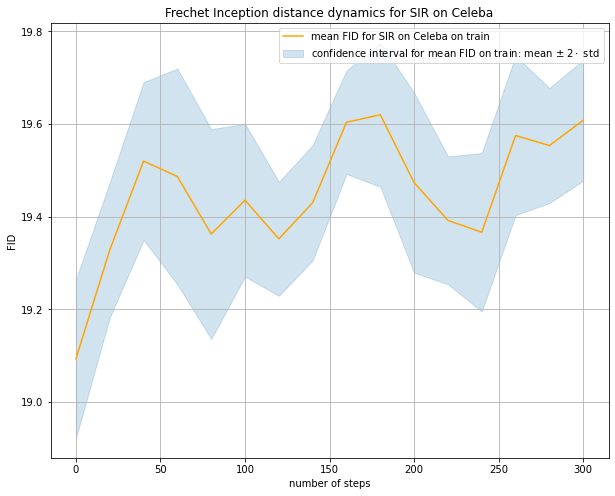

In [7]:
method_name = 'SIR on Celeba'
every_step = 20
figsize = (10, 8)
grad_step = 5
eps_scale = 5
#path_to_save = "/home/daniil/gans-mcmc/gans_sampling/figs"
path_to_save = None
plot_scores_cifar10_dynamics(sir_scores,
                             every_step, 
                             method_name,
                             figsize,
                             path_to_save,
                             grad_step,
                             eps_scale,
                             coef = 2.0,
                             plot_is = False,
                             plot_fid_train = True,
                             plot_fid_test = False)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 200
n = 50000
n_steps = 500
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala_dcgan_celeba'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 20
continue_z = None

z_last_np, zs = mala_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

## Facebook model

In [2]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, use_gpu=False)

Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [3]:
device = torch.device('cuda:1')
D = model.getOriginalD().eval().requires_grad_(False).to(device)
G = model.getOriginalG().eval().requires_grad_(False).to(device)

In [4]:
num_images = 32
noise, _ = model.buildNoiseData(num_images)
noise = noise.to(device)
generated_images = G(noise)

In [5]:
noise.shape

torch.Size([32, 512])

In [6]:
D(generated_images).shape

torch.Size([32, 1])

In [7]:
generated_images.min()

tensor(-1.3186, device='cuda:1')

In [8]:
generated_images.max()

tensor(1.7101, device='cuda:1')

In [11]:
generated_images.shape

torch.Size([32, 3, 128, 128])

In [25]:
image_size = 64
transform = transforms.Compose([transforms.Resize(image_size)])
#generated_images_transform = (transform(generated_images).clamp(min=-1, max=1) + 1.)/2



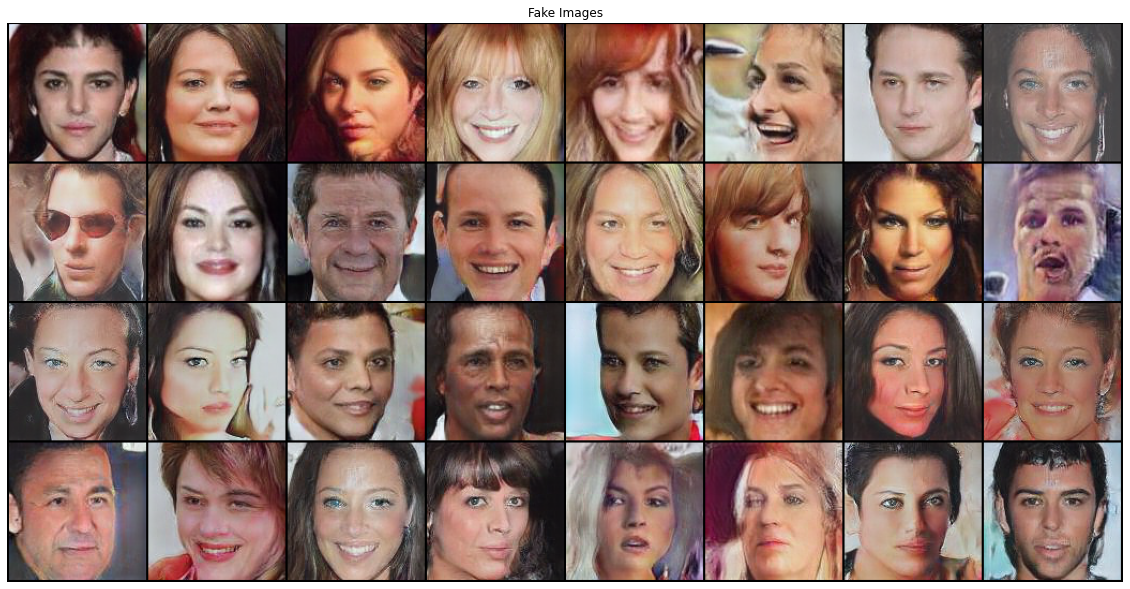

In [26]:
grid = torchvision.utils.make_grid(generated_images, scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [47]:
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
#image_size = 64
#dataset = dset.ImageFolder(root=dataroot,
#                           transform=transforms.Compose([
#                               transforms.Resize(image_size),
#                               transforms.CenterCrop(image_size),
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                           ]))
image_size = 64
dataset = dset.ImageFolder(root=dataroot,
                                         transform=transforms.Compose([
                                             transforms.Resize(image_size),
                                             transforms.CenterCrop(image_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5, 0.5, 0.5),
                                                                  (0.5, 0.5, 0.5)),
                                         ]))
# Create the dataloader
workers = 2
batch_size = 64
real_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

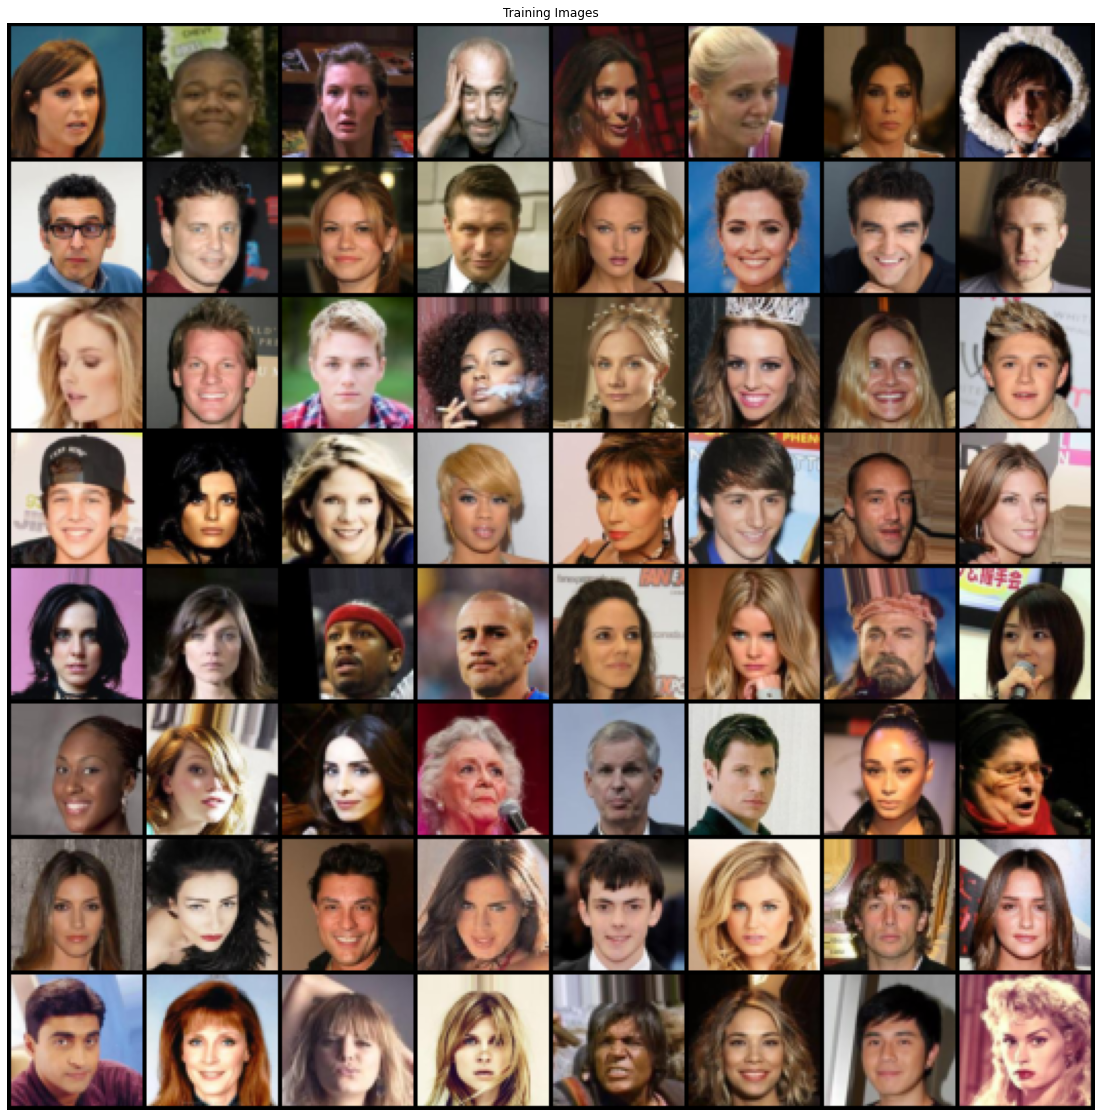

In [48]:
real_batch = next(iter(real_dataloader))
real_images = real_batch[0].to(device)[:64]
plt.figure(figsize=(20, 20))
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_images, 
                                         padding=2, normalize=True).cpu(),
                        (1,2,0))
          )
plt.axis("off")
plt.show()

In [49]:
real_images.min()

tensor(-1., device='cuda:1')

In [50]:
real_images.max()

tensor(1., device='cuda:1')

In [8]:
real_images.shape

torch.Size([64, 3, 128, 128])

In [6]:
nsamples = 50000
noise, _ = model.buildNoiseData(nsamples)
latent_dataset = LatentFixDatasetCeleba(noise, G, 
                                        device, nsamples)

In [6]:
start = time.time()
batch_size = 64
(inception_score_mean, 
 inception_score_std) = inception_score(latent_dataset, 
                                        device, 
                                        batch_size, True)
consumed_time = time.time() - start



Start to make predictions
Start to compute KL divergence


In [7]:
consumed_time


1632.5388934612274

In [9]:
inception_score_mean

3.0295146421481105

In [10]:
inception_score_std

0.01321523786761441

In [52]:
path_to_save_np = "/home/daniil/gans-mcmc/saved_numpy_arrays"
name_fake_train = os.path.join(path_to_save_np, "train_fake_celeba.npy")
name_real_train = os.path.join(path_to_save_np, "train_real_celeba.npy")
#image_size = 64
#transform = transforms.Compose([transforms.Resize(image_size)])
transform = None
random_seed = 42
batch_size = 100

#noise = torch.randn(10000, 512)
nsamples = 50000
#noise, _ = model.buildNoiseData(nsamples)
noise = torch.randn(nsamples, z_dim, 1, 1)

start = time.time()
save_images_for_fid_fix_latent(G,
                               real_dataloader,
                               name_fake_train,
                               name_real_train,
                               noise,
                               device, 
                               transform,
                               random_seed,
                               normalize_imgs=False,
                               use_clamp=False)   
consumed_time = time.time() - start

781it [00:21, 36.72it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


In [12]:
check = np.load(name_fake_train)

In [13]:
check.shape

(10000, 3, 128, 128)

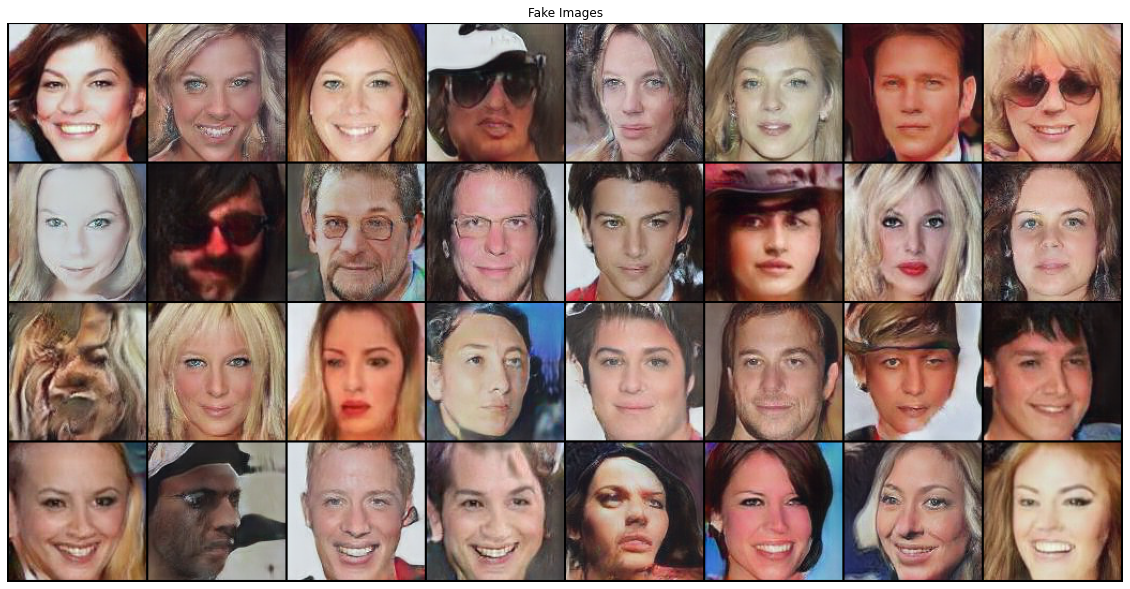

In [14]:
grid = torchvision.utils.make_grid(torch.FloatTensor(check[:32]), scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [15]:
check.min()

-3.5019455

In [16]:
check.max()

4.132348

In [17]:
check = np.load(name_real_train)

In [18]:
check.min()

-1.0

In [19]:
check.max()

1.0

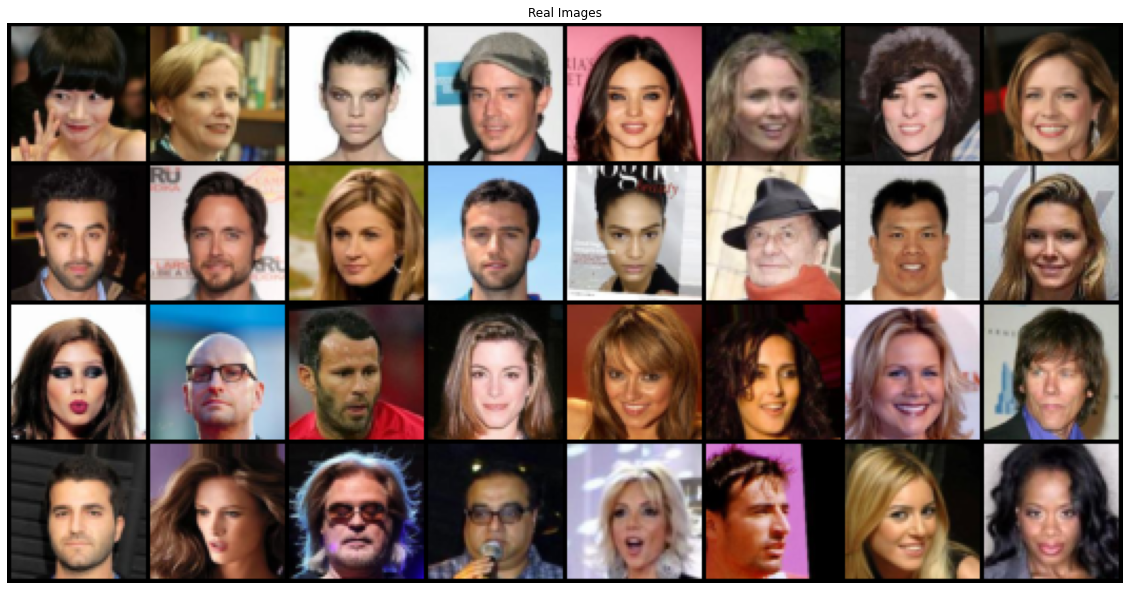

In [20]:
grid = torchvision.utils.make_grid(torch.FloatTensor(chech[:32]), scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Real Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [54]:
batch_size_resnet = 100
dim_resnet = 2048
model_type = 'inception'
cuda = True

paths_to_train_method = [name_real_train, name_fake_train]

results_fid_train = calculate_fid_given_paths(paths_to_train_method, 
                                           batch_size_resnet, 
                                           cuda, 
                                           dim_resnet, 
                                           model_type=model_type)

  0%|          | 1/500 [00:00<01:26,  5.78it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/train_fake_celeba.npy


FID: 100%|██████████| 10/10 [01:24<00:00,  8.42s/it, mean=20.3]


In [55]:
results_fid_train_first = results_fid_train[0]

mean_fid_train = results_fid_train_first[1]
std_fid_train = results_fid_train_first[2]
print(mean_fid_train)
print(std_fid_train)

20.32985932871099
0.10713299823508719


In [36]:
batch_size_resnet = 50
dim_resnet = 2048
model_type = 'inception'
cuda = True

paths_to_train_method = [name_real_train, name_fake_train]

results_fid_train = calculate_fid_given_paths(paths_to_train_method, 
                                           batch_size_resnet, 
                                           cuda, 
                                           dim_resnet, 
                                           model_type=model_type)

  0%|          | 2/1000 [00:00<01:26, 11.50it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/train_fake_celeba.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.20s/it, mean=19]


In [37]:
results_fid_train_first = results_fid_train[0]

mean_fid_train = results_fid_train_first[1]
std_fid_train = results_fid_train_first[2]
print(mean_fid_train)
print(std_fid_train)

19.04734363852969
0.08064274583875268


# ULA

In [20]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

device = torch.device('cuda:1')
D = model.getOriginalD().eval().requires_grad_(False).to(device)
G = model.getOriginalG().eval().requires_grad_(False).to(device)


Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [3]:
noise, _ = model.buildNoiseData(1)
z_dim = noise.shape[1]

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [4]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 45
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  0%|          | 1/223 [01:23<5:08:30, 83.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_0.npy was saved, file shape = (21, 45, 512)


  1%|          | 2/223 [02:49<5:09:53, 84.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_45.npy was saved, file shape = (21, 45, 512)


  1%|▏         | 3/223 [04:15<5:10:39, 84.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_90.npy was saved, file shape = (21, 45, 512)


  2%|▏         | 4/223 [05:41<5:10:39, 85.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_135.npy was saved, file shape = (21, 45, 512)


  2%|▏         | 5/223 [07:07<5:10:13, 85.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_180.npy was saved, file shape = (21, 45, 512)


  3%|▎         | 6/223 [08:33<5:09:29, 85.58s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_225.npy was saved, file shape = (21, 45, 512)


  3%|▎         | 7/223 [09:59<5:08:38, 85.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_270.npy was saved, file shape = (21, 45, 512)


  4%|▎         | 8/223 [11:25<5:07:38, 85.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_315.npy was saved, file shape = (21, 45, 512)


  4%|▍         | 9/223 [12:51<5:06:23, 85.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_360.npy was saved, file shape = (21, 45, 512)


  4%|▍         | 10/223 [14:17<5:05:07, 85.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_405.npy was saved, file shape = (21, 45, 512)


  5%|▍         | 11/223 [15:43<5:03:48, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_450.npy was saved, file shape = (21, 45, 512)


  5%|▌         | 12/223 [17:09<5:02:27, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_495.npy was saved, file shape = (21, 45, 512)


  6%|▌         | 13/223 [18:35<5:01:04, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_540.npy was saved, file shape = (21, 45, 512)


  6%|▋         | 14/223 [20:01<4:59:40, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_585.npy was saved, file shape = (21, 45, 512)


  7%|▋         | 15/223 [21:28<4:58:16, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_630.npy was saved, file shape = (21, 45, 512)


  7%|▋         | 16/223 [22:54<4:56:51, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_675.npy was saved, file shape = (21, 45, 512)


  8%|▊         | 17/223 [24:20<4:55:26, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_720.npy was saved, file shape = (21, 45, 512)


  8%|▊         | 18/223 [25:46<4:54:00, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_765.npy was saved, file shape = (21, 45, 512)


  9%|▊         | 19/223 [27:12<4:52:33, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_810.npy was saved, file shape = (21, 45, 512)


  9%|▉         | 20/223 [28:38<4:51:07, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_855.npy was saved, file shape = (21, 45, 512)


  9%|▉         | 21/223 [30:04<4:49:42, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_900.npy was saved, file shape = (21, 45, 512)


 10%|▉         | 22/223 [31:30<4:48:17, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_945.npy was saved, file shape = (21, 45, 512)


 10%|█         | 23/223 [32:56<4:46:51, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_990.npy was saved, file shape = (21, 45, 512)


 11%|█         | 24/223 [34:22<4:45:24, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1035.npy was saved, file shape = (21, 45, 512)


 11%|█         | 25/223 [35:48<4:43:56, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1080.npy was saved, file shape = (21, 45, 512)


 12%|█▏        | 26/223 [37:14<4:42:28, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1125.npy was saved, file shape = (21, 45, 512)


 12%|█▏        | 27/223 [38:40<4:41:02, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1170.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 28/223 [40:06<4:39:34, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1215.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 29/223 [41:32<4:38:08, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1260.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 30/223 [42:58<4:36:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1305.npy was saved, file shape = (21, 45, 512)


 14%|█▍        | 31/223 [44:24<4:35:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1350.npy was saved, file shape = (21, 45, 512)


 14%|█▍        | 32/223 [45:50<4:33:50, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1395.npy was saved, file shape = (21, 45, 512)


 15%|█▍        | 33/223 [47:16<4:32:24, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1440.npy was saved, file shape = (21, 45, 512)


 15%|█▌        | 34/223 [48:42<4:31:00, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1485.npy was saved, file shape = (21, 45, 512)


 16%|█▌        | 35/223 [50:08<4:29:33, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1530.npy was saved, file shape = (21, 45, 512)


 16%|█▌        | 36/223 [51:34<4:28:07, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1575.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 37/223 [53:00<4:26:42, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1620.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 38/223 [54:26<4:25:18, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1665.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 39/223 [55:53<4:23:53, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1710.npy was saved, file shape = (21, 45, 512)


 18%|█▊        | 40/223 [57:19<4:22:29, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1755.npy was saved, file shape = (21, 45, 512)


 18%|█▊        | 41/223 [58:45<4:21:03, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1800.npy was saved, file shape = (21, 45, 512)


 19%|█▉        | 42/223 [1:00:11<4:19:37, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1845.npy was saved, file shape = (21, 45, 512)


 19%|█▉        | 43/223 [1:01:37<4:18:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1890.npy was saved, file shape = (21, 45, 512)


 20%|█▉        | 44/223 [1:03:03<4:16:43, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1935.npy was saved, file shape = (21, 45, 512)


 20%|██        | 45/223 [1:04:29<4:15:17, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1980.npy was saved, file shape = (21, 45, 512)


 21%|██        | 46/223 [1:05:55<4:13:48, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2025.npy was saved, file shape = (21, 45, 512)


 21%|██        | 47/223 [1:07:21<4:12:21, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2070.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 48/223 [1:08:47<4:10:55, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2115.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 49/223 [1:10:13<4:09:29, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2160.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 50/223 [1:11:39<4:08:04, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2205.npy was saved, file shape = (21, 45, 512)


 23%|██▎       | 51/223 [1:13:05<4:06:39, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2250.npy was saved, file shape = (21, 45, 512)


 23%|██▎       | 52/223 [1:14:31<4:05:14, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2295.npy was saved, file shape = (21, 45, 512)


 24%|██▍       | 53/223 [1:15:57<4:03:49, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2340.npy was saved, file shape = (21, 45, 512)


 24%|██▍       | 54/223 [1:17:23<4:02:22, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2385.npy was saved, file shape = (21, 45, 512)


 25%|██▍       | 55/223 [1:18:49<4:00:54, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2430.npy was saved, file shape = (21, 45, 512)


 25%|██▌       | 56/223 [1:20:15<3:59:28, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2475.npy was saved, file shape = (21, 45, 512)


 26%|██▌       | 57/223 [1:21:41<3:58:01, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2520.npy was saved, file shape = (21, 45, 512)


 26%|██▌       | 58/223 [1:23:07<3:56:39, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2565.npy was saved, file shape = (21, 45, 512)


 26%|██▋       | 59/223 [1:24:33<3:55:12, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2610.npy was saved, file shape = (21, 45, 512)


 27%|██▋       | 60/223 [1:26:00<3:53:48, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2655.npy was saved, file shape = (21, 45, 512)


 27%|██▋       | 61/223 [1:27:26<3:52:22, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2700.npy was saved, file shape = (21, 45, 512)


 28%|██▊       | 62/223 [1:28:52<3:50:56, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2745.npy was saved, file shape = (21, 45, 512)


 28%|██▊       | 63/223 [1:30:18<3:49:30, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2790.npy was saved, file shape = (21, 45, 512)


 29%|██▊       | 64/223 [1:31:44<3:48:03, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2835.npy was saved, file shape = (21, 45, 512)


 29%|██▉       | 65/223 [1:33:10<3:46:37, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2880.npy was saved, file shape = (21, 45, 512)


 30%|██▉       | 66/223 [1:34:36<3:45:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2925.npy was saved, file shape = (21, 45, 512)


 30%|███       | 67/223 [1:36:02<3:43:45, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2970.npy was saved, file shape = (21, 45, 512)


 30%|███       | 68/223 [1:37:28<3:42:17, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3015.npy was saved, file shape = (21, 45, 512)


 31%|███       | 69/223 [1:38:54<3:40:51, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3060.npy was saved, file shape = (21, 45, 512)


 31%|███▏      | 70/223 [1:40:20<3:39:26, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3105.npy was saved, file shape = (21, 45, 512)


 32%|███▏      | 71/223 [1:41:46<3:38:02, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3150.npy was saved, file shape = (21, 45, 512)


 32%|███▏      | 72/223 [1:43:12<3:36:37, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3195.npy was saved, file shape = (21, 45, 512)


 33%|███▎      | 73/223 [1:44:38<3:35:11, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3240.npy was saved, file shape = (21, 45, 512)


 33%|███▎      | 74/223 [1:46:04<3:33:44, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3285.npy was saved, file shape = (21, 45, 512)


 34%|███▎      | 75/223 [1:47:30<3:32:17, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3330.npy was saved, file shape = (21, 45, 512)


 34%|███▍      | 76/223 [1:48:57<3:30:51, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3375.npy was saved, file shape = (21, 45, 512)


 35%|███▍      | 77/223 [1:50:23<3:29:25, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3420.npy was saved, file shape = (21, 45, 512)


 35%|███▍      | 78/223 [1:51:49<3:27:58, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3465.npy was saved, file shape = (21, 45, 512)


 35%|███▌      | 79/223 [1:53:15<3:26:31, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3510.npy was saved, file shape = (21, 45, 512)


 36%|███▌      | 80/223 [1:54:41<3:25:05, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3555.npy was saved, file shape = (21, 45, 512)


 36%|███▋      | 81/223 [1:56:07<3:23:39, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3600.npy was saved, file shape = (21, 45, 512)


 37%|███▋      | 82/223 [1:57:33<3:22:12, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3645.npy was saved, file shape = (21, 45, 512)


 37%|███▋      | 83/223 [1:58:59<3:20:46, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3690.npy was saved, file shape = (21, 45, 512)


 38%|███▊      | 84/223 [2:00:25<3:19:21, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3735.npy was saved, file shape = (21, 45, 512)


 38%|███▊      | 85/223 [2:01:51<3:17:55, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3780.npy was saved, file shape = (21, 45, 512)


 39%|███▊      | 86/223 [2:03:17<3:16:28, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3825.npy was saved, file shape = (21, 45, 512)


 39%|███▉      | 87/223 [2:04:43<3:15:02, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3870.npy was saved, file shape = (21, 45, 512)


 39%|███▉      | 88/223 [2:06:09<3:13:36, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3915.npy was saved, file shape = (21, 45, 512)


 40%|███▉      | 89/223 [2:07:35<3:12:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3960.npy was saved, file shape = (21, 45, 512)


 40%|████      | 90/223 [2:09:01<3:10:43, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4005.npy was saved, file shape = (21, 45, 512)


 41%|████      | 91/223 [2:10:27<3:09:16, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4050.npy was saved, file shape = (21, 45, 512)


 41%|████▏     | 92/223 [2:11:53<3:07:49, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4095.npy was saved, file shape = (21, 45, 512)


 42%|████▏     | 93/223 [2:13:19<3:06:23, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4140.npy was saved, file shape = (21, 45, 512)


 42%|████▏     | 94/223 [2:14:45<3:04:58, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4185.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 95/223 [2:16:11<3:03:31, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4230.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 96/223 [2:17:37<3:02:05, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4275.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 97/223 [2:19:03<3:00:38, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4320.npy was saved, file shape = (21, 45, 512)


 44%|████▍     | 98/223 [2:20:29<2:59:13, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4365.npy was saved, file shape = (21, 45, 512)


 44%|████▍     | 99/223 [2:21:55<2:57:46, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4410.npy was saved, file shape = (21, 45, 512)


 45%|████▍     | 100/223 [2:23:21<2:56:20, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4455.npy was saved, file shape = (21, 45, 512)


 45%|████▌     | 101/223 [2:24:47<2:54:54, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4500.npy was saved, file shape = (21, 45, 512)


 46%|████▌     | 102/223 [2:26:13<2:53:28, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4545.npy was saved, file shape = (21, 45, 512)


 46%|████▌     | 103/223 [2:27:39<2:52:01, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4590.npy was saved, file shape = (21, 45, 512)


 47%|████▋     | 104/223 [2:29:05<2:50:34, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4635.npy was saved, file shape = (21, 45, 512)


 47%|████▋     | 105/223 [2:30:31<2:49:07, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4680.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 106/223 [2:31:57<2:47:41, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4725.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 107/223 [2:33:23<2:46:15, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4770.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 108/223 [2:34:49<2:44:49, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4815.npy was saved, file shape = (21, 45, 512)


 49%|████▉     | 109/223 [2:36:15<2:43:23, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4860.npy was saved, file shape = (21, 45, 512)


 49%|████▉     | 110/223 [2:37:41<2:41:58, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4905.npy was saved, file shape = (21, 45, 512)


 50%|████▉     | 111/223 [2:39:07<2:40:33, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4950.npy was saved, file shape = (21, 45, 512)


 50%|█████     | 112/223 [2:40:33<2:39:07, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4995.npy was saved, file shape = (21, 45, 512)


 51%|█████     | 113/223 [2:42:00<2:37:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5040.npy was saved, file shape = (21, 45, 512)


 51%|█████     | 114/223 [2:43:26<2:36:16, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5085.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 115/223 [2:44:52<2:34:50, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5130.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 116/223 [2:46:18<2:33:23, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5175.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 117/223 [2:47:44<2:31:58, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5220.npy was saved, file shape = (21, 45, 512)


 53%|█████▎    | 118/223 [2:49:10<2:30:32, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5265.npy was saved, file shape = (21, 45, 512)


 53%|█████▎    | 119/223 [2:50:36<2:29:07, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5310.npy was saved, file shape = (21, 45, 512)


 54%|█████▍    | 120/223 [2:52:02<2:27:40, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5355.npy was saved, file shape = (21, 45, 512)


 54%|█████▍    | 121/223 [2:53:28<2:26:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5400.npy was saved, file shape = (21, 45, 512)


 55%|█████▍    | 122/223 [2:54:54<2:24:48, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5445.npy was saved, file shape = (21, 45, 512)


 55%|█████▌    | 123/223 [2:56:20<2:23:21, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5490.npy was saved, file shape = (21, 45, 512)


 56%|█████▌    | 124/223 [2:57:46<2:21:55, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5535.npy was saved, file shape = (21, 45, 512)


 56%|█████▌    | 125/223 [2:59:12<2:20:29, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5580.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 126/223 [3:00:38<2:19:03, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5625.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 127/223 [3:02:04<2:17:37, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5670.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 128/223 [3:03:30<2:16:11, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5715.npy was saved, file shape = (21, 45, 512)


 58%|█████▊    | 129/223 [3:04:56<2:14:46, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5760.npy was saved, file shape = (21, 45, 512)


 58%|█████▊    | 130/223 [3:06:22<2:13:21, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5805.npy was saved, file shape = (21, 45, 512)


 59%|█████▊    | 131/223 [3:07:48<2:11:55, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5850.npy was saved, file shape = (21, 45, 512)


 59%|█████▉    | 132/223 [3:09:14<2:10:30, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5895.npy was saved, file shape = (21, 45, 512)


 60%|█████▉    | 133/223 [3:10:40<2:09:03, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5940.npy was saved, file shape = (21, 45, 512)


 60%|██████    | 134/223 [3:12:06<2:07:36, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5985.npy was saved, file shape = (21, 45, 512)


 61%|██████    | 135/223 [3:13:32<2:06:10, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6030.npy was saved, file shape = (21, 45, 512)


 61%|██████    | 136/223 [3:14:58<2:04:44, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6075.npy was saved, file shape = (21, 45, 512)


 61%|██████▏   | 137/223 [3:16:24<2:03:17, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6120.npy was saved, file shape = (21, 45, 512)


 62%|██████▏   | 138/223 [3:17:50<2:01:52, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6165.npy was saved, file shape = (21, 45, 512)


 62%|██████▏   | 139/223 [3:19:16<2:00:24, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6210.npy was saved, file shape = (21, 45, 512)


 63%|██████▎   | 140/223 [3:20:42<1:58:58, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6255.npy was saved, file shape = (21, 45, 512)


 63%|██████▎   | 141/223 [3:22:08<1:57:32, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6300.npy was saved, file shape = (21, 45, 512)


 64%|██████▎   | 142/223 [3:23:34<1:56:07, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6345.npy was saved, file shape = (21, 45, 512)


 64%|██████▍   | 143/223 [3:25:00<1:54:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6390.npy was saved, file shape = (21, 45, 512)


 65%|██████▍   | 144/223 [3:26:26<1:53:15, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6435.npy was saved, file shape = (21, 45, 512)


 65%|██████▌   | 145/223 [3:27:52<1:51:49, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6480.npy was saved, file shape = (21, 45, 512)


 65%|██████▌   | 146/223 [3:29:18<1:50:23, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6525.npy was saved, file shape = (21, 45, 512)


 66%|██████▌   | 147/223 [3:30:44<1:48:57, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6570.npy was saved, file shape = (21, 45, 512)


 66%|██████▋   | 148/223 [3:32:10<1:47:31, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6615.npy was saved, file shape = (21, 45, 512)


 67%|██████▋   | 149/223 [3:33:36<1:46:05, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6660.npy was saved, file shape = (21, 45, 512)


 67%|██████▋   | 150/223 [3:35:02<1:44:39, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6705.npy was saved, file shape = (21, 45, 512)


 68%|██████▊   | 151/223 [3:36:28<1:43:13, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6750.npy was saved, file shape = (21, 45, 512)


 68%|██████▊   | 152/223 [3:37:54<1:41:47, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6795.npy was saved, file shape = (21, 45, 512)


 69%|██████▊   | 153/223 [3:39:20<1:40:22, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6840.npy was saved, file shape = (21, 45, 512)


 69%|██████▉   | 154/223 [3:40:46<1:38:55, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6885.npy was saved, file shape = (21, 45, 512)


 70%|██████▉   | 155/223 [3:42:12<1:37:29, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6930.npy was saved, file shape = (21, 45, 512)


 70%|██████▉   | 156/223 [3:43:38<1:36:03, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6975.npy was saved, file shape = (21, 45, 512)


 70%|███████   | 157/223 [3:45:05<1:34:37, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7020.npy was saved, file shape = (21, 45, 512)


 71%|███████   | 158/223 [3:46:31<1:33:12, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7065.npy was saved, file shape = (21, 45, 512)


 71%|███████▏  | 159/223 [3:47:57<1:31:46, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7110.npy was saved, file shape = (21, 45, 512)


 72%|███████▏  | 160/223 [3:49:23<1:30:20, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7155.npy was saved, file shape = (21, 45, 512)


 72%|███████▏  | 161/223 [3:50:49<1:28:55, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7200.npy was saved, file shape = (21, 45, 512)


 73%|███████▎  | 162/223 [3:52:15<1:27:29, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7245.npy was saved, file shape = (21, 45, 512)


 73%|███████▎  | 163/223 [3:53:41<1:26:02, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7290.npy was saved, file shape = (21, 45, 512)


 74%|███████▎  | 164/223 [3:55:07<1:24:36, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7335.npy was saved, file shape = (21, 45, 512)


 74%|███████▍  | 165/223 [3:56:33<1:23:10, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7380.npy was saved, file shape = (21, 45, 512)


 74%|███████▍  | 166/223 [3:57:59<1:21:43, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7425.npy was saved, file shape = (21, 45, 512)


 75%|███████▍  | 167/223 [3:59:25<1:20:17, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7470.npy was saved, file shape = (21, 45, 512)


 75%|███████▌  | 168/223 [4:00:51<1:18:51, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7515.npy was saved, file shape = (21, 45, 512)


 76%|███████▌  | 169/223 [4:02:17<1:17:25, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7560.npy was saved, file shape = (21, 45, 512)


 76%|███████▌  | 170/223 [4:03:43<1:15:59, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7605.npy was saved, file shape = (21, 45, 512)


 77%|███████▋  | 171/223 [4:05:09<1:14:33, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7650.npy was saved, file shape = (21, 45, 512)


 77%|███████▋  | 172/223 [4:06:35<1:13:06, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7695.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 173/223 [4:08:01<1:11:40, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7740.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 174/223 [4:09:27<1:10:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7785.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 175/223 [4:10:53<1:08:49, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7830.npy was saved, file shape = (21, 45, 512)


 79%|███████▉  | 176/223 [4:12:19<1:07:22, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7875.npy was saved, file shape = (21, 45, 512)


 79%|███████▉  | 177/223 [4:13:45<1:05:56, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7920.npy was saved, file shape = (21, 45, 512)


 80%|███████▉  | 178/223 [4:15:11<1:04:30, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7965.npy was saved, file shape = (21, 45, 512)


 80%|████████  | 179/223 [4:16:37<1:03:04, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8010.npy was saved, file shape = (21, 45, 512)


 81%|████████  | 180/223 [4:18:03<1:01:38, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8055.npy was saved, file shape = (21, 45, 512)


 81%|████████  | 181/223 [4:19:29<1:00:12, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8100.npy was saved, file shape = (21, 45, 512)


 82%|████████▏ | 182/223 [4:20:55<58:46, 86.02s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8145.npy was saved, file shape = (21, 45, 512)


 82%|████████▏ | 183/223 [4:22:21<57:20, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8190.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 184/223 [4:23:47<55:54, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8235.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 185/223 [4:25:13<54:27, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8280.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 186/223 [4:26:39<53:01, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8325.npy was saved, file shape = (21, 45, 512)


 84%|████████▍ | 187/223 [4:28:05<51:35, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8370.npy was saved, file shape = (21, 45, 512)


 84%|████████▍ | 188/223 [4:29:31<50:10, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8415.npy was saved, file shape = (21, 45, 512)


 85%|████████▍ | 189/223 [4:30:57<48:43, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8460.npy was saved, file shape = (21, 45, 512)


 85%|████████▌ | 190/223 [4:32:23<47:17, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8505.npy was saved, file shape = (21, 45, 512)


 86%|████████▌ | 191/223 [4:33:49<45:51, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8550.npy was saved, file shape = (21, 45, 512)


 86%|████████▌ | 192/223 [4:35:15<44:25, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8595.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 193/223 [4:36:41<42:59, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8640.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 194/223 [4:38:07<41:33, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8685.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 195/223 [4:39:33<40:07, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8730.npy was saved, file shape = (21, 45, 512)


 88%|████████▊ | 196/223 [4:40:59<38:41, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8775.npy was saved, file shape = (21, 45, 512)


 88%|████████▊ | 197/223 [4:42:25<37:15, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8820.npy was saved, file shape = (21, 45, 512)


 89%|████████▉ | 198/223 [4:43:51<35:49, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8865.npy was saved, file shape = (21, 45, 512)


 89%|████████▉ | 199/223 [4:45:17<34:23, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8910.npy was saved, file shape = (21, 45, 512)


 90%|████████▉ | 200/223 [4:46:43<32:57, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8955.npy was saved, file shape = (21, 45, 512)


 90%|█████████ | 201/223 [4:48:09<31:31, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9000.npy was saved, file shape = (21, 45, 512)


 91%|█████████ | 202/223 [4:49:35<30:05, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9045.npy was saved, file shape = (21, 45, 512)


 91%|█████████ | 203/223 [4:51:01<28:40, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9090.npy was saved, file shape = (21, 45, 512)


 91%|█████████▏| 204/223 [4:52:27<27:14, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9135.npy was saved, file shape = (21, 45, 512)


 92%|█████████▏| 205/223 [4:53:53<25:48, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9180.npy was saved, file shape = (21, 45, 512)


 92%|█████████▏| 206/223 [4:55:19<24:22, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9225.npy was saved, file shape = (21, 45, 512)


 93%|█████████▎| 207/223 [4:56:45<22:55, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9270.npy was saved, file shape = (21, 45, 512)


 93%|█████████▎| 208/223 [4:58:11<21:30, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9315.npy was saved, file shape = (21, 45, 512)


 94%|█████████▎| 209/223 [4:59:37<20:03, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9360.npy was saved, file shape = (21, 45, 512)


 94%|█████████▍| 210/223 [5:01:03<18:37, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9405.npy was saved, file shape = (21, 45, 512)


 95%|█████████▍| 211/223 [5:02:29<17:11, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9450.npy was saved, file shape = (21, 45, 512)


 95%|█████████▌| 212/223 [5:03:55<15:45, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9495.npy was saved, file shape = (21, 45, 512)


 96%|█████████▌| 213/223 [5:05:21<14:19, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9540.npy was saved, file shape = (21, 45, 512)


 96%|█████████▌| 214/223 [5:06:47<12:53, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9585.npy was saved, file shape = (21, 45, 512)


 96%|█████████▋| 215/223 [5:08:13<11:28, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9630.npy was saved, file shape = (21, 45, 512)


 97%|█████████▋| 216/223 [5:09:39<10:01, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9675.npy was saved, file shape = (21, 45, 512)


 97%|█████████▋| 217/223 [5:11:05<08:35, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9720.npy was saved, file shape = (21, 45, 512)


 98%|█████████▊| 218/223 [5:12:31<07:10, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9765.npy was saved, file shape = (21, 45, 512)


 98%|█████████▊| 219/223 [5:13:57<05:44, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9810.npy was saved, file shape = (21, 45, 512)


 99%|█████████▊| 220/223 [5:15:23<04:18, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9855.npy was saved, file shape = (21, 45, 512)


 99%|█████████▉| 221/223 [5:16:49<02:51, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9900.npy was saved, file shape = (21, 45, 512)


100%|█████████▉| 222/223 [5:18:15<01:25, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9945.npy was saved, file shape = (21, 45, 512)


100%|██████████| 223/223 [5:19:41<00:00, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9990.npy was saved, file shape = (21, 45, 512)


In [36]:
batch_size = 45
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5

load_np = []

for i in tqdm(range(0, n, batch_size)):
    cur_file_name = file_name + f"_batch_num_{i}.npy"
    cur_path_to_save = os.path.join(path_to_save, cur_file_name)
    cur_zs = np.load(cur_path_to_save)
    load_np.append(cur_zs)
    
load_np = np.array(load_np)


100%|██████████| 223/223 [00:00<00:00, 1640.67it/s]


In [37]:
load_np.shape

(223, 21, 45, 512)

In [38]:
load_np = np.concatenate(load_np.transpose(0, 2, 1, 3), axis = 0).transpose(1, 0, 2)



In [39]:
load_np.shape

(21, 10035, 512)

In [44]:
load_np_10k = load_np[:, :10000, :]
array_load = [load_np_10k]
eps = 1e-6
for i in range(4):
    cur_batch = load_np_10k + eps*np.random.rand(21, 10000, 512)
    array_load.append(cur_batch)
    
array_load = np.concatenate(array_load, axis = 1)

In [45]:
array_load.shape

(21, 50000, 512)

In [47]:
method_name = 'ula_pgan_50k'
random_seed = 42
every_step = 5
batch_size = 45
calculate_is = False
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
ula_scores = calculate_celeba_statistics(array_load, 
                                         G,
                                         device, 
                                         batch_size,
                                         path_to_save_np,
                                         method_name,
                                         image_size,
                                         dataroot,
                                         calculate_is=calculate_is,
                                         random_seed=random_seed,
                                         every_step=every_step)


Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/daniil/anaconda3/envs/myenv/lib/

------------------------------------
step = 0
sample size = (50000, 512)
sample size after deleteting nans = (50000, 512)
start to calculate FID score for train Celeba over 50000 images...


1111it [03:57,  4.67it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 2/1111 [00:00<01:39, 11.18it/s]

  0%|          | 2/1111 [00:00<01:28, 12.55it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_50k_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=37.4]

FID score for train Celeba with ula_pgan_50k: mean 37.35781957092759, score 0.05204847402732017
time for FID calculation on train = 521.699s
------------------------------------
step = 5
sample size = (50000, 512)
sample size after deleteting nans = (50000, 512)
start to calculate FID score for train Celeba over 50000 images...



20it [00:04,  4.60it/s]


KeyboardInterrupt: 

In [6]:
method_name = 'ula_pgan'
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_fid_mean_train = f'{method_name}_fid_scores_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
name_fid_std_train = f'{method_name}_fid_scores_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)
fid_scores_mean_train = np.load(path_to_save_fid_mean_train)
fid_scores_std_train = np.load(path_to_save_fid_std_train)
scores = {'fid_scores_mean_train': fid_scores_mean_train,
    'fid_scores_std_train': fid_scores_std_train
}

method_name = 'ULA'
every_step = 5
figsize = (10, 8)
grad_step = 0.01
eps_scale = 0.1
path_to_save = "/home/daniil/gans-mcmc/gans_sampling/figs"
plot_scores_cifar10_dynamics(scores,
                             every_step, 
                             method_name,
                             figsize,
                             path_to_save,
                             grad_step,
                             eps_scale,
                             coef = 2.0,
                             plot_is = False,
                             plot_fid_train = True,
                             plot_fid_test = False)

In [7]:
fid_scores_mean_train = np.load(path_to_save_fid_mean_train)
fid_scores_std_train = np.load(path_to_save_fid_std_train)

In [8]:
fid_scores_mean_train

array([39.47410414, 39.42200162, 39.11849535, 39.02944552, 39.14715682,
       39.18860309, 39.49197625, 39.33660673, 39.41227473, 39.51766066,
       39.58472533, 39.67984042, 39.74531296, 39.60490252, 39.50308661,
       39.9359346 , 39.58073409, 39.95666062, 39.96078014, 40.06380486,
       40.11852305])

In [9]:
fid_scores_std_train

array([0.18392322, 0.24645555, 0.20872488, 0.23448955, 0.24191839,
       0.28929434, 0.26533746, 0.28613128, 0.33196668, 0.33461752,
       0.30531263, 0.23981912, 0.24498712, 0.2825788 , 0.20148745,
       0.22612549, 0.18897553, 0.1770689 , 0.25399552, 0.26304313,
       0.22880605])

In [10]:
scores = {'fid_scores_mean_train': fid_scores_mean_train,
    'fid_scores_std_train': fid_scores_std_train
}

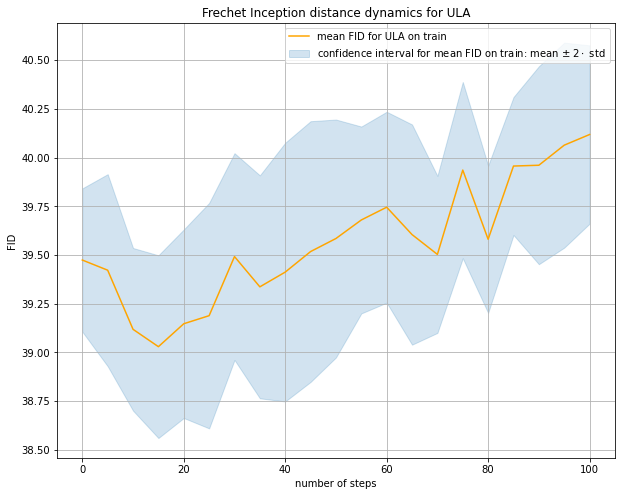

In [19]:
method_name = 'ULA'
every_step = 5
figsize = (10, 8)
grad_step = 0.01
eps_scale = 0.1
path_to_save = "/home/daniil/gans-mcmc/gans_sampling/figs"
plot_scores_cifar10_dynamics(scores,
                             every_step, 
                             method_name,
                             figsize,
                             path_to_save,
                             grad_step,
                             eps_scale,
                             coef = 2.0,
                             plot_is = False,
                             plot_fid_train = True,
                             plot_fid_test = False)

# MALA

In [4]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

device = torch.device('cuda:1')
D = model.getOriginalD().eval().requires_grad_(False).to(device)
G = model.getOriginalG().eval().requires_grad_(False).to(device)

Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [5]:
noise, _ = model.buildNoiseData(1)
z_dim = noise.shape[1]

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [6]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 40
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5
continue_z = None

z_last_np, zs = mala_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  0%|          | 1/250 [02:28<10:14:46, 148.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_0.npy was saved, file shape = (21, 40, 512)


  1%|          | 2/250 [05:00<10:17:02, 149.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_40.npy was saved, file shape = (21, 40, 512)


  1%|          | 3/250 [07:31<10:17:39, 150.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_80.npy was saved, file shape = (21, 40, 512)


  2%|▏         | 4/250 [10:03<10:17:18, 150.56s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_120.npy was saved, file shape = (21, 40, 512)


  2%|▏         | 5/250 [12:35<10:16:18, 150.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_160.npy was saved, file shape = (21, 40, 512)


  2%|▏         | 6/250 [15:07<10:14:50, 151.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_200.npy was saved, file shape = (21, 40, 512)


  3%|▎         | 7/250 [17:39<10:13:00, 151.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_240.npy was saved, file shape = (21, 40, 512)


  3%|▎         | 8/250 [20:10<10:10:57, 151.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_280.npy was saved, file shape = (21, 40, 512)


  4%|▎         | 9/250 [22:42<10:08:43, 151.55s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_320.npy was saved, file shape = (21, 40, 512)


  4%|▍         | 10/250 [25:14<10:06:23, 151.60s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_360.npy was saved, file shape = (21, 40, 512)


  4%|▍         | 11/250 [27:45<10:04:01, 151.64s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_400.npy was saved, file shape = (21, 40, 512)


  5%|▍         | 12/250 [30:17<10:01:39, 151.68s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_440.npy was saved, file shape = (21, 40, 512)


  5%|▌         | 13/250 [32:49<9:59:15, 151.71s/it] 

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_480.npy was saved, file shape = (21, 40, 512)


  6%|▌         | 14/250 [35:21<9:56:48, 151.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_520.npy was saved, file shape = (21, 40, 512)


  6%|▌         | 15/250 [37:53<9:54:20, 151.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_560.npy was saved, file shape = (21, 40, 512)


  6%|▋         | 16/250 [40:24<9:51:51, 151.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_600.npy was saved, file shape = (21, 40, 512)


  7%|▋         | 17/250 [42:56<9:49:20, 151.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_640.npy was saved, file shape = (21, 40, 512)


  7%|▋         | 18/250 [45:28<9:46:52, 151.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_680.npy was saved, file shape = (21, 40, 512)


  8%|▊         | 19/250 [48:00<9:44:24, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_720.npy was saved, file shape = (21, 40, 512)


  8%|▊         | 20/250 [50:32<9:41:52, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_760.npy was saved, file shape = (21, 40, 512)


  8%|▊         | 21/250 [53:03<9:39:20, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_800.npy was saved, file shape = (21, 40, 512)


  9%|▉         | 22/250 [55:35<9:36:49, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_840.npy was saved, file shape = (21, 40, 512)


  9%|▉         | 23/250 [58:07<9:34:18, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_880.npy was saved, file shape = (21, 40, 512)


 10%|▉         | 24/250 [1:00:39<9:31:47, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_920.npy was saved, file shape = (21, 40, 512)


 10%|█         | 25/250 [1:03:11<9:29:16, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_960.npy was saved, file shape = (21, 40, 512)


 10%|█         | 26/250 [1:05:42<9:26:44, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1000.npy was saved, file shape = (21, 40, 512)


 11%|█         | 27/250 [1:08:14<9:24:14, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1040.npy was saved, file shape = (21, 40, 512)


 11%|█         | 28/250 [1:10:46<9:21:43, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1080.npy was saved, file shape = (21, 40, 512)


 12%|█▏        | 29/250 [1:13:18<9:19:11, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1120.npy was saved, file shape = (21, 40, 512)


 12%|█▏        | 30/250 [1:15:50<9:16:40, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1160.npy was saved, file shape = (21, 40, 512)


 12%|█▏        | 31/250 [1:18:21<9:14:07, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1200.npy was saved, file shape = (21, 40, 512)


 13%|█▎        | 32/250 [1:20:53<9:11:37, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1240.npy was saved, file shape = (21, 40, 512)


 13%|█▎        | 33/250 [1:23:25<9:09:01, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1280.npy was saved, file shape = (21, 40, 512)


 14%|█▎        | 34/250 [1:25:57<9:06:26, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1320.npy was saved, file shape = (21, 40, 512)


 14%|█▍        | 35/250 [1:28:29<9:03:54, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1360.npy was saved, file shape = (21, 40, 512)


 14%|█▍        | 36/250 [1:31:00<9:01:22, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1400.npy was saved, file shape = (21, 40, 512)


 15%|█▍        | 37/250 [1:33:32<8:58:51, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1440.npy was saved, file shape = (21, 40, 512)


 15%|█▌        | 38/250 [1:36:04<8:56:23, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1480.npy was saved, file shape = (21, 40, 512)


 16%|█▌        | 39/250 [1:38:36<8:53:56, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1520.npy was saved, file shape = (21, 40, 512)


 16%|█▌        | 40/250 [1:41:08<8:51:29, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1560.npy was saved, file shape = (21, 40, 512)


 16%|█▋        | 41/250 [1:43:40<8:48:58, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1600.npy was saved, file shape = (21, 40, 512)


 17%|█▋        | 42/250 [1:46:12<8:46:27, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1640.npy was saved, file shape = (21, 40, 512)


 17%|█▋        | 43/250 [1:48:43<8:43:56, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1680.npy was saved, file shape = (21, 40, 512)


 18%|█▊        | 44/250 [1:51:15<8:41:25, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1720.npy was saved, file shape = (21, 40, 512)


 18%|█▊        | 45/250 [1:53:47<8:38:53, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1760.npy was saved, file shape = (21, 40, 512)


 18%|█▊        | 46/250 [1:56:19<8:36:23, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1800.npy was saved, file shape = (21, 40, 512)


 19%|█▉        | 47/250 [1:58:51<8:33:53, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1840.npy was saved, file shape = (21, 40, 512)


 19%|█▉        | 48/250 [2:01:23<8:31:16, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1880.npy was saved, file shape = (21, 40, 512)


 20%|█▉        | 49/250 [2:03:55<8:28:41, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1920.npy was saved, file shape = (21, 40, 512)


 20%|██        | 50/250 [2:06:27<8:26:10, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1960.npy was saved, file shape = (21, 40, 512)


 20%|██        | 51/250 [2:08:58<8:23:37, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2000.npy was saved, file shape = (21, 40, 512)


 21%|██        | 52/250 [2:11:30<8:21:04, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2040.npy was saved, file shape = (21, 40, 512)


 21%|██        | 53/250 [2:14:02<8:18:30, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2080.npy was saved, file shape = (21, 40, 512)


 22%|██▏       | 54/250 [2:16:34<8:15:59, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2120.npy was saved, file shape = (21, 40, 512)


 22%|██▏       | 55/250 [2:19:06<8:13:24, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2160.npy was saved, file shape = (21, 40, 512)


 22%|██▏       | 56/250 [2:21:37<8:10:52, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2200.npy was saved, file shape = (21, 40, 512)


 23%|██▎       | 57/250 [2:24:09<8:08:20, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2240.npy was saved, file shape = (21, 40, 512)


 23%|██▎       | 58/250 [2:26:41<8:05:47, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2280.npy was saved, file shape = (21, 40, 512)


 24%|██▎       | 59/250 [2:29:13<8:03:14, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2320.npy was saved, file shape = (21, 40, 512)


 24%|██▍       | 60/250 [2:31:45<8:00:43, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2360.npy was saved, file shape = (21, 40, 512)


 24%|██▍       | 61/250 [2:34:16<7:58:11, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2400.npy was saved, file shape = (21, 40, 512)


 25%|██▍       | 62/250 [2:36:48<7:55:39, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2440.npy was saved, file shape = (21, 40, 512)


 25%|██▌       | 63/250 [2:39:20<7:53:06, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2480.npy was saved, file shape = (21, 40, 512)


 26%|██▌       | 64/250 [2:41:52<7:50:35, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2520.npy was saved, file shape = (21, 40, 512)


 26%|██▌       | 65/250 [2:44:24<7:48:05, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2560.npy was saved, file shape = (21, 40, 512)


 26%|██▋       | 66/250 [2:46:55<7:45:33, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2600.npy was saved, file shape = (21, 40, 512)


 27%|██▋       | 67/250 [2:49:27<7:43:00, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2640.npy was saved, file shape = (21, 40, 512)


 27%|██▋       | 68/250 [2:51:59<7:40:31, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2680.npy was saved, file shape = (21, 40, 512)


 28%|██▊       | 69/250 [2:54:31<7:38:00, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2720.npy was saved, file shape = (21, 40, 512)


 28%|██▊       | 70/250 [2:57:03<7:35:29, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2760.npy was saved, file shape = (21, 40, 512)


 28%|██▊       | 71/250 [2:59:35<7:33:00, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2800.npy was saved, file shape = (21, 40, 512)


 29%|██▉       | 72/250 [3:02:07<7:30:32, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2840.npy was saved, file shape = (21, 40, 512)


 29%|██▉       | 73/250 [3:04:39<7:28:03, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2880.npy was saved, file shape = (21, 40, 512)


 30%|██▉       | 74/250 [3:07:10<7:25:27, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2920.npy was saved, file shape = (21, 40, 512)


 30%|███       | 75/250 [3:09:42<7:22:56, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2960.npy was saved, file shape = (21, 40, 512)


 30%|███       | 76/250 [3:12:14<7:20:24, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3000.npy was saved, file shape = (21, 40, 512)


 31%|███       | 77/250 [3:14:46<7:17:53, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3040.npy was saved, file shape = (21, 40, 512)


 31%|███       | 78/250 [3:17:18<7:15:23, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3080.npy was saved, file shape = (21, 40, 512)


 32%|███▏      | 79/250 [3:19:50<7:12:53, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3120.npy was saved, file shape = (21, 40, 512)


 32%|███▏      | 80/250 [3:22:22<7:10:21, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3160.npy was saved, file shape = (21, 40, 512)


 32%|███▏      | 81/250 [3:24:54<7:07:51, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3200.npy was saved, file shape = (21, 40, 512)


 33%|███▎      | 82/250 [3:27:26<7:05:19, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3240.npy was saved, file shape = (21, 40, 512)


 33%|███▎      | 83/250 [3:29:57<7:02:50, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3280.npy was saved, file shape = (21, 40, 512)


 34%|███▎      | 84/250 [3:32:29<7:00:21, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3320.npy was saved, file shape = (21, 40, 512)


 34%|███▍      | 85/250 [3:35:01<6:57:50, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3360.npy was saved, file shape = (21, 40, 512)


 34%|███▍      | 86/250 [3:37:33<6:55:14, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3400.npy was saved, file shape = (21, 40, 512)


 35%|███▍      | 87/250 [3:40:05<6:52:38, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3440.npy was saved, file shape = (21, 40, 512)


 35%|███▌      | 88/250 [3:42:37<6:50:06, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3480.npy was saved, file shape = (21, 40, 512)


 36%|███▌      | 89/250 [3:45:09<6:47:35, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3520.npy was saved, file shape = (21, 40, 512)


 36%|███▌      | 90/250 [3:47:41<6:45:01, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3560.npy was saved, file shape = (21, 40, 512)


 36%|███▋      | 91/250 [3:50:13<6:42:28, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3600.npy was saved, file shape = (21, 40, 512)


 37%|███▋      | 92/250 [3:52:44<6:39:55, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3640.npy was saved, file shape = (21, 40, 512)


 37%|███▋      | 93/250 [3:55:16<6:37:22, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3680.npy was saved, file shape = (21, 40, 512)


 38%|███▊      | 94/250 [3:57:48<6:34:49, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3720.npy was saved, file shape = (21, 40, 512)


 38%|███▊      | 95/250 [4:00:20<6:32:17, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3760.npy was saved, file shape = (21, 40, 512)


 38%|███▊      | 96/250 [4:02:52<6:29:46, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3800.npy was saved, file shape = (21, 40, 512)


 39%|███▉      | 97/250 [4:05:24<6:27:15, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3840.npy was saved, file shape = (21, 40, 512)


 39%|███▉      | 98/250 [4:07:56<6:24:44, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3880.npy was saved, file shape = (21, 40, 512)


 40%|███▉      | 99/250 [4:10:28<6:22:12, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3920.npy was saved, file shape = (21, 40, 512)


 40%|████      | 100/250 [4:12:59<6:19:40, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3960.npy was saved, file shape = (21, 40, 512)


 40%|████      | 101/250 [4:15:31<6:17:09, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4000.npy was saved, file shape = (21, 40, 512)


 41%|████      | 102/250 [4:18:03<6:14:39, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4040.npy was saved, file shape = (21, 40, 512)


 41%|████      | 103/250 [4:20:35<6:12:08, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4080.npy was saved, file shape = (21, 40, 512)


 42%|████▏     | 104/250 [4:23:07<6:09:38, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4120.npy was saved, file shape = (21, 40, 512)


 42%|████▏     | 105/250 [4:25:39<6:07:08, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4160.npy was saved, file shape = (21, 40, 512)


 42%|████▏     | 106/250 [4:28:11<6:04:38, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4200.npy was saved, file shape = (21, 40, 512)


 43%|████▎     | 107/250 [4:30:43<6:02:07, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4240.npy was saved, file shape = (21, 40, 512)


 43%|████▎     | 108/250 [4:33:15<5:59:35, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4280.npy was saved, file shape = (21, 40, 512)


 44%|████▎     | 109/250 [4:35:47<5:57:06, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4320.npy was saved, file shape = (21, 40, 512)


 44%|████▍     | 110/250 [4:38:19<5:54:35, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4360.npy was saved, file shape = (21, 40, 512)


 44%|████▍     | 111/250 [4:40:51<5:52:03, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4400.npy was saved, file shape = (21, 40, 512)


 45%|████▍     | 112/250 [4:43:23<5:49:34, 151.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4440.npy was saved, file shape = (21, 40, 512)


 45%|████▌     | 113/250 [4:45:55<5:47:03, 151.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4480.npy was saved, file shape = (21, 40, 512)


 46%|████▌     | 114/250 [4:48:27<5:44:31, 152.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4520.npy was saved, file shape = (21, 40, 512)


 46%|████▌     | 115/250 [4:50:59<5:42:01, 152.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4560.npy was saved, file shape = (21, 40, 512)


 46%|████▋     | 116/250 [4:53:31<5:39:29, 152.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4600.npy was saved, file shape = (21, 40, 512)


 47%|████▋     | 117/250 [4:56:03<5:36:56, 152.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4640.npy was saved, file shape = (21, 40, 512)


 47%|████▋     | 118/250 [4:58:35<5:34:23, 151.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4680.npy was saved, file shape = (21, 40, 512)


 48%|████▊     | 119/250 [5:01:07<5:31:51, 152.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4720.npy was saved, file shape = (21, 40, 512)


 48%|████▊     | 120/250 [5:03:39<5:29:17, 151.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4760.npy was saved, file shape = (21, 40, 512)


 48%|████▊     | 121/250 [5:06:11<5:26:44, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4800.npy was saved, file shape = (21, 40, 512)


 49%|████▉     | 122/250 [5:08:43<5:24:13, 151.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4840.npy was saved, file shape = (21, 40, 512)


 49%|████▉     | 123/250 [5:11:15<5:21:39, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4880.npy was saved, file shape = (21, 40, 512)


 50%|████▉     | 124/250 [5:13:47<5:19:07, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4920.npy was saved, file shape = (21, 40, 512)


 50%|█████     | 125/250 [5:16:19<5:16:36, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4960.npy was saved, file shape = (21, 40, 512)


 50%|█████     | 126/250 [5:18:51<5:14:03, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5000.npy was saved, file shape = (21, 40, 512)


 51%|█████     | 127/250 [5:21:23<5:11:31, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5040.npy was saved, file shape = (21, 40, 512)


 51%|█████     | 128/250 [5:23:54<5:08:56, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5080.npy was saved, file shape = (21, 40, 512)


 52%|█████▏    | 129/250 [5:26:26<5:06:23, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5120.npy was saved, file shape = (21, 40, 512)


 52%|█████▏    | 130/250 [5:28:58<5:03:51, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5160.npy was saved, file shape = (21, 40, 512)


 52%|█████▏    | 131/250 [5:31:30<5:01:18, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5200.npy was saved, file shape = (21, 40, 512)


 53%|█████▎    | 132/250 [5:34:02<4:58:45, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5240.npy was saved, file shape = (21, 40, 512)


 53%|█████▎    | 133/250 [5:36:34<4:56:13, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5280.npy was saved, file shape = (21, 40, 512)


 54%|█████▎    | 134/250 [5:39:06<4:53:44, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5320.npy was saved, file shape = (21, 40, 512)


 54%|█████▍    | 135/250 [5:41:38<4:51:11, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5360.npy was saved, file shape = (21, 40, 512)


 54%|█████▍    | 136/250 [5:44:10<4:48:38, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5400.npy was saved, file shape = (21, 40, 512)


 55%|█████▍    | 137/250 [5:46:42<4:46:07, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5440.npy was saved, file shape = (21, 40, 512)


 55%|█████▌    | 138/250 [5:49:14<4:43:35, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5480.npy was saved, file shape = (21, 40, 512)


 56%|█████▌    | 139/250 [5:51:46<4:41:03, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5520.npy was saved, file shape = (21, 40, 512)


 56%|█████▌    | 140/250 [5:54:17<4:38:32, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5560.npy was saved, file shape = (21, 40, 512)


 56%|█████▋    | 141/250 [5:56:49<4:35:59, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5600.npy was saved, file shape = (21, 40, 512)


 57%|█████▋    | 142/250 [5:59:21<4:33:25, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5640.npy was saved, file shape = (21, 40, 512)


 57%|█████▋    | 143/250 [6:01:53<4:30:54, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5680.npy was saved, file shape = (21, 40, 512)


 58%|█████▊    | 144/250 [6:04:25<4:28:24, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5720.npy was saved, file shape = (21, 40, 512)


 58%|█████▊    | 145/250 [6:06:57<4:25:54, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5760.npy was saved, file shape = (21, 40, 512)


 58%|█████▊    | 146/250 [6:09:29<4:23:23, 151.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5800.npy was saved, file shape = (21, 40, 512)


 59%|█████▉    | 147/250 [6:12:01<4:20:49, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5840.npy was saved, file shape = (21, 40, 512)


 59%|█████▉    | 148/250 [6:14:33<4:18:19, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5880.npy was saved, file shape = (21, 40, 512)


 60%|█████▉    | 149/250 [6:17:05<4:15:47, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5920.npy was saved, file shape = (21, 40, 512)


 60%|██████    | 150/250 [6:19:37<4:13:15, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5960.npy was saved, file shape = (21, 40, 512)


 60%|██████    | 151/250 [6:22:09<4:10:42, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6000.npy was saved, file shape = (21, 40, 512)


 61%|██████    | 152/250 [6:24:41<4:08:07, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6040.npy was saved, file shape = (21, 40, 512)


 61%|██████    | 153/250 [6:27:13<4:05:36, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6080.npy was saved, file shape = (21, 40, 512)


 62%|██████▏   | 154/250 [6:29:45<4:03:05, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6120.npy was saved, file shape = (21, 40, 512)


 62%|██████▏   | 155/250 [6:32:16<4:00:32, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6160.npy was saved, file shape = (21, 40, 512)


 62%|██████▏   | 156/250 [6:34:48<3:57:59, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6200.npy was saved, file shape = (21, 40, 512)


 63%|██████▎   | 157/250 [6:37:20<3:55:27, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6240.npy was saved, file shape = (21, 40, 512)


 63%|██████▎   | 158/250 [6:39:52<3:52:55, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6280.npy was saved, file shape = (21, 40, 512)


 64%|██████▎   | 159/250 [6:42:24<3:50:26, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6320.npy was saved, file shape = (21, 40, 512)


 64%|██████▍   | 160/250 [6:44:56<3:47:56, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6360.npy was saved, file shape = (21, 40, 512)


 64%|██████▍   | 161/250 [6:47:28<3:45:24, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6400.npy was saved, file shape = (21, 40, 512)


 65%|██████▍   | 162/250 [6:50:00<3:42:52, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6440.npy was saved, file shape = (21, 40, 512)


 65%|██████▌   | 163/250 [6:52:32<3:40:19, 151.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6480.npy was saved, file shape = (21, 40, 512)


 66%|██████▌   | 164/250 [6:55:04<3:37:46, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6520.npy was saved, file shape = (21, 40, 512)


 66%|██████▌   | 165/250 [6:57:36<3:35:13, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6560.npy was saved, file shape = (21, 40, 512)


 66%|██████▋   | 166/250 [7:00:08<3:32:40, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6600.npy was saved, file shape = (21, 40, 512)


 67%|██████▋   | 167/250 [7:02:40<3:30:10, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6640.npy was saved, file shape = (21, 40, 512)


 67%|██████▋   | 168/250 [7:05:12<3:27:39, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6680.npy was saved, file shape = (21, 40, 512)


 68%|██████▊   | 169/250 [7:07:44<3:25:06, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6720.npy was saved, file shape = (21, 40, 512)


 68%|██████▊   | 170/250 [7:10:16<3:22:35, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6760.npy was saved, file shape = (21, 40, 512)


 68%|██████▊   | 171/250 [7:12:47<3:20:01, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6800.npy was saved, file shape = (21, 40, 512)


 69%|██████▉   | 172/250 [7:15:19<3:17:29, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6840.npy was saved, file shape = (21, 40, 512)


 69%|██████▉   | 173/250 [7:17:51<3:14:57, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6880.npy was saved, file shape = (21, 40, 512)


 70%|██████▉   | 174/250 [7:20:23<3:12:25, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6920.npy was saved, file shape = (21, 40, 512)


 70%|███████   | 175/250 [7:22:55<3:09:53, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6960.npy was saved, file shape = (21, 40, 512)


 70%|███████   | 176/250 [7:25:27<3:07:21, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7000.npy was saved, file shape = (21, 40, 512)


 71%|███████   | 177/250 [7:27:59<3:04:49, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7040.npy was saved, file shape = (21, 40, 512)


 71%|███████   | 178/250 [7:30:31<3:02:18, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7080.npy was saved, file shape = (21, 40, 512)


 72%|███████▏  | 179/250 [7:33:03<2:59:47, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7120.npy was saved, file shape = (21, 40, 512)


 72%|███████▏  | 180/250 [7:35:35<2:57:15, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7160.npy was saved, file shape = (21, 40, 512)


 72%|███████▏  | 181/250 [7:38:07<2:54:42, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7200.npy was saved, file shape = (21, 40, 512)


 73%|███████▎  | 182/250 [7:40:38<2:52:09, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7240.npy was saved, file shape = (21, 40, 512)


 73%|███████▎  | 183/250 [7:43:10<2:49:37, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7280.npy was saved, file shape = (21, 40, 512)


 74%|███████▎  | 184/250 [7:45:42<2:47:05, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7320.npy was saved, file shape = (21, 40, 512)


 74%|███████▍  | 185/250 [7:48:14<2:44:34, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7360.npy was saved, file shape = (21, 40, 512)


 74%|███████▍  | 186/250 [7:50:46<2:42:01, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7400.npy was saved, file shape = (21, 40, 512)


 75%|███████▍  | 187/250 [7:53:18<2:39:29, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7440.npy was saved, file shape = (21, 40, 512)


 75%|███████▌  | 188/250 [7:55:50<2:36:57, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7480.npy was saved, file shape = (21, 40, 512)


 76%|███████▌  | 189/250 [7:58:22<2:34:26, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7520.npy was saved, file shape = (21, 40, 512)


 76%|███████▌  | 190/250 [8:00:54<2:31:55, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7560.npy was saved, file shape = (21, 40, 512)


 76%|███████▋  | 191/250 [8:03:26<2:29:24, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7600.npy was saved, file shape = (21, 40, 512)


 77%|███████▋  | 192/250 [8:05:58<2:26:52, 151.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7640.npy was saved, file shape = (21, 40, 512)


 77%|███████▋  | 193/250 [8:08:30<2:24:20, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7680.npy was saved, file shape = (21, 40, 512)


 78%|███████▊  | 194/250 [8:11:01<2:21:47, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7720.npy was saved, file shape = (21, 40, 512)


 78%|███████▊  | 195/250 [8:13:33<2:19:13, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7760.npy was saved, file shape = (21, 40, 512)


 78%|███████▊  | 196/250 [8:16:05<2:16:40, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7800.npy was saved, file shape = (21, 40, 512)


 79%|███████▉  | 197/250 [8:18:37<2:14:08, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7840.npy was saved, file shape = (21, 40, 512)


 79%|███████▉  | 198/250 [8:21:09<2:11:35, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7880.npy was saved, file shape = (21, 40, 512)


 80%|███████▉  | 199/250 [8:23:41<2:09:03, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7920.npy was saved, file shape = (21, 40, 512)


 80%|████████  | 200/250 [8:26:12<2:06:32, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7960.npy was saved, file shape = (21, 40, 512)


 80%|████████  | 201/250 [8:28:44<2:04:00, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8000.npy was saved, file shape = (21, 40, 512)


 81%|████████  | 202/250 [8:31:16<2:01:28, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8040.npy was saved, file shape = (21, 40, 512)


 81%|████████  | 203/250 [8:33:48<1:58:57, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8080.npy was saved, file shape = (21, 40, 512)


 82%|████████▏ | 204/250 [8:36:20<1:56:25, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8120.npy was saved, file shape = (21, 40, 512)


 82%|████████▏ | 205/250 [8:38:52<1:53:53, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8160.npy was saved, file shape = (21, 40, 512)


 82%|████████▏ | 206/250 [8:41:24<1:51:21, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8200.npy was saved, file shape = (21, 40, 512)


 83%|████████▎ | 207/250 [8:43:56<1:48:50, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8240.npy was saved, file shape = (21, 40, 512)


 83%|████████▎ | 208/250 [8:46:27<1:46:18, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8280.npy was saved, file shape = (21, 40, 512)


 84%|████████▎ | 209/250 [8:48:59<1:43:46, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8320.npy was saved, file shape = (21, 40, 512)


 84%|████████▍ | 210/250 [8:51:31<1:41:15, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8360.npy was saved, file shape = (21, 40, 512)


 84%|████████▍ | 211/250 [8:54:03<1:38:43, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8400.npy was saved, file shape = (21, 40, 512)


 85%|████████▍ | 212/250 [8:56:35<1:36:11, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8440.npy was saved, file shape = (21, 40, 512)


 85%|████████▌ | 213/250 [8:59:07<1:33:39, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8480.npy was saved, file shape = (21, 40, 512)


 86%|████████▌ | 214/250 [9:01:39<1:31:07, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8520.npy was saved, file shape = (21, 40, 512)


 86%|████████▌ | 215/250 [9:04:11<1:28:35, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8560.npy was saved, file shape = (21, 40, 512)


 86%|████████▋ | 216/250 [9:06:43<1:26:04, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8600.npy was saved, file shape = (21, 40, 512)


 87%|████████▋ | 217/250 [9:09:15<1:23:33, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8640.npy was saved, file shape = (21, 40, 512)


 87%|████████▋ | 218/250 [9:11:46<1:21:01, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8680.npy was saved, file shape = (21, 40, 512)


 88%|████████▊ | 219/250 [9:14:18<1:18:29, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8720.npy was saved, file shape = (21, 40, 512)


 88%|████████▊ | 220/250 [9:16:50<1:15:56, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8760.npy was saved, file shape = (21, 40, 512)


 88%|████████▊ | 221/250 [9:19:22<1:13:25, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8800.npy was saved, file shape = (21, 40, 512)


 89%|████████▉ | 222/250 [9:21:54<1:10:53, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8840.npy was saved, file shape = (21, 40, 512)


 89%|████████▉ | 223/250 [9:24:26<1:08:20, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8880.npy was saved, file shape = (21, 40, 512)


 90%|████████▉ | 224/250 [9:26:58<1:05:48, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8920.npy was saved, file shape = (21, 40, 512)


 90%|█████████ | 225/250 [9:29:30<1:03:16, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8960.npy was saved, file shape = (21, 40, 512)


 90%|█████████ | 226/250 [9:32:01<1:00:44, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9000.npy was saved, file shape = (21, 40, 512)


 91%|█████████ | 227/250 [9:34:33<58:12, 151.87s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9040.npy was saved, file shape = (21, 40, 512)


 91%|█████████ | 228/250 [9:37:05<55:40, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9080.npy was saved, file shape = (21, 40, 512)


 92%|█████████▏| 229/250 [9:39:37<53:08, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9120.npy was saved, file shape = (21, 40, 512)


 92%|█████████▏| 230/250 [9:42:09<50:36, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9160.npy was saved, file shape = (21, 40, 512)


 92%|█████████▏| 231/250 [9:44:40<48:04, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9200.npy was saved, file shape = (21, 40, 512)


 93%|█████████▎| 232/250 [9:47:12<45:32, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9240.npy was saved, file shape = (21, 40, 512)


 93%|█████████▎| 233/250 [9:49:44<43:00, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9280.npy was saved, file shape = (21, 40, 512)


 94%|█████████▎| 234/250 [9:52:16<40:28, 151.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9320.npy was saved, file shape = (21, 40, 512)


 94%|█████████▍| 235/250 [9:54:47<37:56, 151.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9360.npy was saved, file shape = (21, 40, 512)


 94%|█████████▍| 236/250 [9:57:19<35:24, 151.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9400.npy was saved, file shape = (21, 40, 512)


 95%|█████████▍| 237/250 [9:59:51<32:53, 151.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9440.npy was saved, file shape = (21, 40, 512)


 95%|█████████▌| 238/250 [10:02:23<30:21, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9480.npy was saved, file shape = (21, 40, 512)


 96%|█████████▌| 239/250 [10:04:55<27:49, 151.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9520.npy was saved, file shape = (21, 40, 512)


 96%|█████████▌| 240/250 [10:07:26<25:17, 151.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9560.npy was saved, file shape = (21, 40, 512)


 96%|█████████▋| 241/250 [10:09:58<22:46, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9600.npy was saved, file shape = (21, 40, 512)


 97%|█████████▋| 242/250 [10:12:30<20:14, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9640.npy was saved, file shape = (21, 40, 512)


 97%|█████████▋| 243/250 [10:15:02<17:42, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9680.npy was saved, file shape = (21, 40, 512)


 98%|█████████▊| 244/250 [10:17:34<15:10, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9720.npy was saved, file shape = (21, 40, 512)


 98%|█████████▊| 245/250 [10:20:05<12:39, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9760.npy was saved, file shape = (21, 40, 512)


 98%|█████████▊| 246/250 [10:22:37<10:07, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9800.npy was saved, file shape = (21, 40, 512)


 99%|█████████▉| 247/250 [10:25:09<07:35, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9840.npy was saved, file shape = (21, 40, 512)


 99%|█████████▉| 248/250 [10:27:41<05:03, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9880.npy was saved, file shape = (21, 40, 512)


100%|█████████▉| 249/250 [10:30:13<02:31, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9920.npy was saved, file shape = (21, 40, 512)


100%|██████████| 250/250 [10:32:44<00:00, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9960.npy was saved, file shape = (21, 40, 512)


In [8]:
batch_size = 40
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5

load_np = []

for i in tqdm(range(0, n, batch_size)):
    cur_file_name = file_name + f"_batch_num_{i}.npy"
    cur_path_to_save = os.path.join(path_to_save, cur_file_name)
    cur_zs = np.load(cur_path_to_save)
    load_np.append(cur_zs)
    
load_np = np.array(load_np)

100%|██████████| 250/250 [00:00<00:00, 2423.93it/s]


In [9]:
load_np = np.concatenate(load_np.transpose(0, 2, 1, 3), axis = 0).transpose(1, 0, 2)

In [11]:
method_name = 'mala_pgan_10k'
random_seed = 42
every_step = 5
batch_size = 40
calculate_is = False
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
ula_scores = calculate_celeba_statistics(load_np, 
                                         G,
                                         device, 
                                         batch_size,
                                         path_to_save_np,
                                         method_name,
                                         image_size,
                                         dataroot,
                                         calculate_is=calculate_is,
                                         random_seed=random_seed,
                                         every_step=every_step)

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.p

------------------------------------
step = 0
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...


249it [00:45,  5.42it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.54it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it, mean=39.5]

FID score for train Celeba with mala_pgan_10k: mean 39.49224227043685, score 0.3633112578851565
time for FID calculation on train = 138.322s
------------------------------------
step = 5
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.39it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.73it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_5.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it, mean=39.5]

FID score for train Celeba with mala_pgan_10k: mean 39.53985919452416, score 0.37168714741425724
time for FID calculation on train = 137.355s
------------------------------------
step = 10
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.72it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_10.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.70s/it, mean=39.4]

FID score for train Celeba with mala_pgan_10k: mean 39.410964370338164, score 0.37659564481277863
time for FID calculation on train = 118.579s
------------------------------------
step = 15
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



0it [00:00, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb3f4192e50>
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb3f4192e50>
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/ho

shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.65it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_15.npy


FID: 100%|██████████| 10/10 [00:38<00:00,  3.89s/it, mean=39.4]

FID score for train Celeba with mala_pgan_10k: mean 39.444790594908696, score 0.3509050578008698
time for FID calculation on train = 140.802s
------------------------------------
step = 20
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.68it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_20.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it, mean=39.5]

FID score for train Celeba with mala_pgan_10k: mean 39.47249059788347, score 0.38404543805628805
time for FID calculation on train = 138.822s
------------------------------------
step = 25
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.44it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_25.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it, mean=39.6]

FID score for train Celeba with mala_pgan_10k: mean 39.614653353335186, score 0.376738603704695
time for FID calculation on train = 117.917s
------------------------------------
step = 30
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.34it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.69it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_30.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it, mean=39.6]

FID score for train Celeba with mala_pgan_10k: mean 39.64651066284713, score 0.3541026569179604
time for FID calculation on train = 158.521s
------------------------------------
step = 35
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.66it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_35.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it, mean=39.7]

FID score for train Celeba with mala_pgan_10k: mean 39.69578188658501, score 0.36700282839524595
time for FID calculation on train = 138.839s
------------------------------------
step = 40
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.35it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_40.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it, mean=39.8]

FID score for train Celeba with mala_pgan_10k: mean 39.81962426564809, score 0.3480711717996681
time for FID calculation on train = 118.519s
------------------------------------
step = 45
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.33it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.66it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_45.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, mean=40] 

FID score for train Celeba with mala_pgan_10k: mean 39.98769636295865, score 0.35103800093569665
time for FID calculation on train = 158.288s
------------------------------------
step = 50
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.67it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_50.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it, mean=39.9]

FID score for train Celeba with mala_pgan_10k: mean 39.87204517323808, score 0.3364095094858025
time for FID calculation on train = 139.712s
------------------------------------
step = 55
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.65it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_55.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it, mean=39.9]

FID score for train Celeba with mala_pgan_10k: mean 39.9428545305906, score 0.33327949217431463
time for FID calculation on train = 118.509s
------------------------------------
step = 60
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.33it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.49it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_60.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, mean=40] 

FID score for train Celeba with mala_pgan_10k: mean 39.97641879727401, score 0.32074917753658816
time for FID calculation on train = 158.765s
------------------------------------
step = 65
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.62it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_65.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.74s/it, mean=40] 

FID score for train Celeba with mala_pgan_10k: mean 40.02580341332224, score 0.32590058425449764
time for FID calculation on train = 139.049s
------------------------------------
step = 70
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.58it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_70.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, mean=40.1]

FID score for train Celeba with mala_pgan_10k: mean 40.06980723676943, score 0.3371758612599065
time for FID calculation on train = 118.734s
------------------------------------
step = 75
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.34it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_75.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it, mean=40.2]

FID score for train Celeba with mala_pgan_10k: mean 40.176525751607016, score 0.3157448656391305
time for FID calculation on train = 159.812s
------------------------------------
step = 80
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.69it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_80.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, mean=40.3]

FID score for train Celeba with mala_pgan_10k: mean 40.2922301381851, score 0.29026214926849503
time for FID calculation on train = 138.688s
------------------------------------
step = 85
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.66it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_85.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.63s/it, mean=40.4]

FID score for train Celeba with mala_pgan_10k: mean 40.42692915024695, score 0.3382269176924389
time for FID calculation on train = 138.146s
------------------------------------
step = 90
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.35it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.58it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_90.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.71s/it, mean=40.3]

FID score for train Celeba with mala_pgan_10k: mean 40.28923106458471, score 0.3859478369932057
time for FID calculation on train = 118.96s
------------------------------------
step = 95
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.34it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.63it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_95.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it, mean=40.4]

FID score for train Celeba with mala_pgan_10k: mean 40.356096643630984, score 0.3508182927865174
time for FID calculation on train = 157.53s
------------------------------------
step = 100
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.45it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_100.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it, mean=40.3]

FID score for train Celeba with mala_pgan_10k: mean 40.28399743950026, score 0.36079643190963034
time for FID calculation on train = 138.234s


In [12]:
method_name = 'mala_pgan_10k'
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_fid_mean_train = f'{method_name}_fid_scores_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
name_fid_std_train = f'{method_name}_fid_scores_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)

fid_scores_mean_train = np.load(path_to_save_fid_mean_train)
fid_scores_std_train = np.load(path_to_save_fid_std_train)

scores = {'fid_scores_mean_train': fid_scores_mean_train,
    'fid_scores_std_train': fid_scores_std_train
}

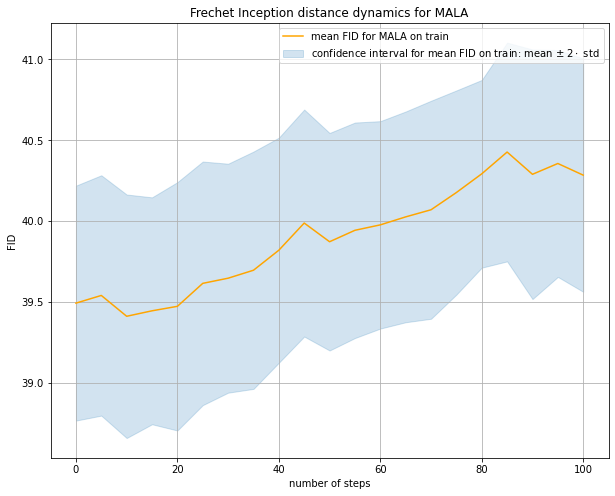

In [13]:
method_name = 'MALA'
every_step = 5
figsize = (10, 8)
grad_step = 0.01
eps_scale = 0.1
path_to_save = "/home/daniil/gans-mcmc/gans_sampling/figs"
plot_scores_cifar10_dynamics(scores,
                             every_step, 
                             method_name,
                             figsize,
                             path_to_save,
                             grad_step,
                             eps_scale,
                             coef = 2.0,
                             plot_is = False,
                             plot_fid_train = True,
                             plot_fid_test = False)

In [4]:
method_name = 'mala_continue_recalculate'
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_inception_mean = f'{method_name}_inception_scores_mean.npy'
path_to_save_inception_mean = os.path.join(path_to_np_files, name_inception_mean)
name_inception_std = f'{method_name}_inception_scores_std.npy'
path_to_save_inception_std = os.path.join(path_to_np_files, name_inception_std)
name_fid_mean_train = f'{method_name}_fid_scores_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
name_fid_mean_test = f'{method_name}_fid_scores_mean_test.npy'
path_to_save_fid_mean_test = os.path.join(path_to_np_files, name_fid_mean_test)
name_fid_std_train = f'{method_name}_fid_scores_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)
name_fid_std_test = f'{method_name}_fid_scores_std_test.npy'
path_to_save_fid_std_test = os.path.join(path_to_np_files, name_fid_std_test)

In [5]:
cont_inception_scores_mean = np.load(path_to_save_inception_mean)[1:]
cont_inception_scores_std = np.load(path_to_save_inception_std)[1:]
cont_fid_scores_mean_train = np.load(path_to_save_fid_mean_train)[1:]
cont_fid_scores_mean_test = np.load(path_to_save_fid_mean_test)[1:]
cont_fid_scores_std_train = np.load(path_to_save_fid_std_train)[1:]
cont_fid_scores_std_test = np.load(path_to_save_fid_std_test)[1:]

In [6]:
cont_fid_scores_mean_train

array([23.65446597, 23.31005891, 23.16305899, 23.11655718, 23.00605576,
       23.06434275, 23.133908  , 23.00471815, 23.00205276, 23.04954342,
       23.29233325, 23.43069388, 23.56013795, 23.82148011, 24.03627133,
       24.20368751, 24.35673141, 24.42931818, 24.74293953, 24.9228769 ])

In [7]:
cont_fid_scores_std_train

array([0.13752093, 0.1435224 , 0.1237562 , 0.11521097, 0.10018137,
       0.11571959, 0.10598312, 0.11468538, 0.10189372, 0.11448175,
       0.09426605, 0.1082958 , 0.09424869, 0.08702687, 0.07598668,
       0.11822705, 0.10836019, 0.12866782, 0.13955673, 0.09344891])

In [18]:
cont_inception_scores_mean

array([5.86350031, 5.89926274, 5.89360714, 5.95794576, 5.95512497,
       5.93867394, 5.97163832, 5.98427264, 6.03508608, 6.07418445,
       6.04576784, 6.04911712, 6.07201039, 6.05066387, 6.0660395 ,
       6.0498912 , 6.0721698 , 6.06715405, 6.07916078, 6.07225764])

In [19]:
cont_inception_scores_std

array([0.08362686, 0.06087194, 0.07726064, 0.06245822, 0.0685414 ,
       0.0568279 , 0.06758708, 0.04712166, 0.07258161, 0.05618417,
       0.08073813, 0.07552438, 0.09073186, 0.04626266, 0.08062651,
       0.05026396, 0.06939004, 0.06893837, 0.09977254, 0.08247653])

In [12]:
method_name = 'ula'
n_steps = 1000
grad_step = 0.01
eps_scale = 0.1
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_inception_mean = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_inception_mean.npy'
path_to_save_inception_mean = os.path.join(path_to_np_files, name_inception_mean)
#np.save(path_to_save_inception_mean, inception_scores_mean)
name_inception_std = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_inception_std.npy'
path_to_save_inception_std = os.path.join(path_to_np_files, name_inception_std)
#np.save(path_to_save_inception_std, inception_scores_std)
name_fid_mean_train = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
#np.save(path_to_save_fid_mean_train, fid_scores_mean_train)
name_fid_mean_test = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_mean_test.npy'
path_to_save_fid_mean_test = os.path.join(path_to_np_files, name_fid_mean_test)
#np.save(path_to_save_fid_mean_test, fid_scores_mean_test)

name_fid_std_train = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)
#np.save(path_to_save_fid_std_train, fid_scores_std_train)
name_fid_std_test = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}_fid_std_test.npy'
path_to_save_fid_std_test = os.path.join(path_to_np_files, name_fid_std_test)
#np.save(path_to_save_fid_std_test, fid_scores_std_test)

In [13]:
inception_scores_mean = np.load(path_to_save_inception_mean)
inception_scores_std = np.load(path_to_save_inception_std)
fid_scores_mean_train = np.load(path_to_save_fid_mean_train)
fid_scores_mean_test = np.load(path_to_save_fid_mean_test)
fid_scores_std_train = np.load(path_to_save_fid_std_train)
fid_scores_std_test = np.load(path_to_save_fid_std_test)

In [14]:
fid_scores_mean_train

array([35.71696744, 41.23658666, 34.94264839, 29.99145377, 26.83238766,
       25.4330189 , 24.85777145, 24.91446835, 25.51014069, 26.43138298,
       27.65998465, 28.87746921, 30.41964352, 31.89948227, 33.36489927,
       34.72285885, 36.21797335, 37.6261386 , 38.9148296 , 40.3451899 ,
       41.87512163])

In [15]:
fid_scores_std_train

array([0.22371321, 0.27416711, 0.25142799, 0.15178538, 0.17803871,
       0.20948116, 0.22552445, 0.16742129, 0.19986429, 0.19882782,
       0.19608401, 0.16089078, 0.1980648 , 0.1971616 , 0.17161143,
       0.21229464, 0.24326893, 0.23913441, 0.22333403, 0.21500754,
       0.24492522])

In [16]:
inception_scores_mean

array([5.45884757, 5.64533251, 5.93302677, 6.11075725, 6.26332335,
       6.33129226, 6.34728345, 6.44997479, 6.4698336 , 6.46627595,
       6.4951764 , 6.49804427, 6.50062138, 6.486893  , 6.45767814,
       6.48513536, 6.39664369, 6.41637201, 6.36567891, 6.35009991,
       6.30995073])

In [17]:
inception_scores_std

array([0.07988136, 0.06556845, 0.07513579, 0.09356253, 0.09139793,
       0.03638079, 0.06738577, 0.06851358, 0.08193226, 0.12731709,
       0.08449641, 0.06955036, 0.05162749, 0.05048257, 0.08984081,
       0.06764605, 0.06941958, 0.0837918 , 0.07713409, 0.08823519,
       0.06783956])